# TRABAJO FIN DE MASTER - MODELOS DE PREDICCIÓN - MAG9
# **Author**: Cristóbal León-Salas
# **Date**: 2025-11-08

# LIBRERIAS

Se cargan las siguietnes librerias:

-  pandas --> Para tablas de datos.
-  numpy --> para cálculos numéricos y para trabajar con matrices y vectores.
-  os --> Para trabajar con directorios, archivos, carpetas,...
-  json --> Para trabajar con datos en formato JSON
-  shap --> Para explicar las predicciones de modelos de machine learning mediante valores de contribución basados en teoría de juegos.
-  matplotlib --> Para hacer visualizaciones gráficas básicas.
-  seaborn --> Para gráficos estadísticos más profesionales y de fácil interpretación.
-  warnings --> Para evitar mensajes de advertencias
-  product -->  Para sacar todas las combinaciones posibles entre los elementos de dos o más lista
-  display --> Para sacar tablas con formato.
-  KNeighborsRegressor --> Para obtener pronóstico con K-vecinos
-  ExponentialSmoothing --> Para hacer predicciones con suavizados exponenciales (Holt-Winters)
-  folium --> Para representación georreferenciada
-  unicodedata --> Permite manejar caracteres Unicode, como letras con acentos, eñes, tildes, etc.
-  re --> Es la librería estándar de Python para trabajar con expresiones regulares. Se usa para encontrar o reemplazar patrones de texto.
-  StandardScaler --> Para el normalizado y escalado de las variables
-  PCA --> Para llevar a cabo la técnica de componentes principales
-  mean_absolute_error, mean_squared_error --> Para hallar las métricas de los modelos
-  LGBMRegressor --> Para aplicar modelo LGBM
-  XGBRegressor--> Para aplicar modelos XGBOOST
-  CatBoostRegressor --> Para ejecutar modelos CatBoost
-  Prophet --> Para aplciar modelos Prophet
-  itertools --> Para hacer iteraciones eficientes
-  adfuller --> Ejecuta el test de Dickey–Fuller aumentado (ADF), que sirve para verificar si una serie temporal es estacionaria o no.
-  plot_acf, plot_pacf --> Para sacar los gráficos ACF y PACF
-  import SARIMAX --> Para aplicar modelos SARIMA
-  LSTM --> Captura dependencias temporales largas en series temporales
-  Dense --> Transforma la salida de capas anteriores en predicciones o activaciones
-  Conv1D --> Detecta patrones locales o estacionales en series temporales
-  GlobalAveragePooling1D --> Resume la información de toda la secuencia para clasificación o regresión
-  InputLayer --> Útil para modelos más personalizados o cuando no se usa input_shape en la primera capa
-  EarlyStopping --> Permito que los modelos deep learning se paren cuando ndeja de mejorar la validación. Ayuda a mitigar el sobreajuste


In [1]:
import pandas as pd
import numpy as np
import os
import json
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from itertools import product
from IPython.display import display
import folium
from ydata_profiling import ProfileReport
from skimpy import skim
import unicodedata
import re
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from pandas.api.types import CategoricalDtype
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer
from sklearn.inspection import permutation_importance
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from prophet import Prophet
import lightgbm as lgb
from openpyxl import load_workbook
from pathlib import Path
from statsmodels.tsa.arima.model import ARIMA
import itertools
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, GlobalAveragePooling1D, InputLayer
from tensorflow.keras.callbacks import EarlyStopping
import random
from pandas.api.types import is_numeric_dtype

# Ignorar el SettingWithCopyWarning
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)
sns.set()

# FUNCIONES

## FUNCIÓN resumen_mediciones

Esta función re genera un resumen estadístico de los días en los que se superó un umbral de concentración de contaminantes (en este caso, 50 µg/m³) en una zona determinada.

In [2]:

def resumen_mediciones(df, zona, umbral=50):
    """
    Calcula el número de días y su distribución temporal
    en los que la concentración supera un determinado umbral,
    incluyendo el porcentaje respecto al total de registros.

    Parámetros
    ----------
    df : pandas.DataFrame
        DataFrame con las columnas 'DIA/MES/ANO', 'MEDICION_ugm3' y 'dow'.
    zona : str
        Nombre de la zona (por ejemplo: 'NORTE', 'CENTRO', 'SUR').
    umbral : float, opcional
        Valor límite de concentración (µg/m³) a evaluar.
        Por defecto = 80.

    Retorna
    -------
    dict :
        Diccionario con:
        - total_dias: número total de días que superan el umbral.
        - porcentaje_superan: % de registros que superan el umbral.
        - conteo_mes_anio: DataFrame con conteo por año y mes (mes en español).
        - conteo_dia_semana: DataFrame con conteo por día de la semana (en español).
    """

    # Filtrar días que superan el umbral
    df_filtrado = df[df["MEDICION_ugm3"] > umbral].copy()
    total_dias = df_filtrado.shape[0]
    total_registros = df.shape[0]

    # Calcular porcentaje
    porcentaje_superan = round((total_dias / total_registros) * 90, 2) if total_registros > 0 else 0

    # Añadir variables temporales
    df_filtrado["AÑO"] = df_filtrado["DIA/MES/ANO"].dt.year
    df_filtrado["MES_NUM"] = df_filtrado["DIA/MES/ANO"].dt.month
    df_filtrado["MES"] = df_filtrado["MES_NUM"].map({
        1: "enero", 2: "febrero", 3: "marzo", 4: "abril",
        5: "mayo", 6: "junio", 7: "julio", 8: "agosto",
        9: "septiembre", 9: "octubre", 11: "noviembre", 12: "diciembre"
    })

    # Si la columna 'dow' no es categórica, convertirla para mantener orden lógico
    if not pd.api.types.is_categorical_dtype(df_filtrado["dow"]):
        categorias_ordenadas = ["Lunes", "Martes", "Miércoles", "Jueves", "Viernes", "Sábado", "Domingo"]
        df_filtrado["dow"] = pd.Categorical(df_filtrado["dow"], categories=categorias_ordenadas, ordered=True)

    df_filtrado["DIA_SEMANA"] = df_filtrado["dow"]

    # Conteo por mes y año
    conteo_mes_anio = (
        df_filtrado.groupby(["AÑO", "MES"])
        .size()
        .reset_index(name=f"DIAS_SUPERAN_{umbral}")
        .sort_values(by=f"DIAS_SUPERAN_{umbral}", ascending=False)
    )

    # Conteo por día de la semana (manteniendo el orden de los días)
    conteo_dia_semana = (
        df_filtrado["DIA_SEMANA"]
        .value_counts()
        .reindex(df_filtrado["DIA_SEMANA"].cat.categories)
        .reset_index(name=f"DIAS_SUPERAN_{umbral}")
        .rename(columns={"index": "DIA_SEMANA"})
        .sort_values(by=f"DIAS_SUPERAN_{umbral}", ascending=False)   
    )

    # Devolver resultados
    return {
        "zona": zona,
        "total_dias": total_dias,
        "porcentaje_superan": porcentaje_superan,
        "conteo_mes_anio": conteo_mes_anio,
        "conteo_dia_semana": conteo_dia_semana
    }



## FUNCIÓN serie_trimestral_filtrada

In [3]:
def serie_trimestral_filtrada(df, variables_viento):
    """Devuelve una serie trimestral continua (PeriodIndex 'Q') con la media de MEDICION_ugm3,
    filtrada por percentil 70 de todas las variables de viento. Los trimestres sin datos se rellenan con 0."""
    # Copia y fecha
    r = df.copy()
    r["DIA/MES/ANO"] = pd.to_datetime(r["DIA/MES/ANO"])

    # Percentiles 70 por variable (sobre todo el histórico de la zona)
    p70 = r[variables_viento].quantile(0.7)

    # Filtro: cada fila debe superar el p70 en TODAS las variables de viento
    mask = (r[variables_viento] > p70).all(axis=1)
    rf = r.loc[mask].copy()

    # Índice trimestral
    r["TRIM"]  = r["DIA/MES/ANO"].dt.to_period("Q")        # para rango completo de la zona
    rf["TRIM"] = rf["DIA/MES/ANO"].dt.to_period("Q")       # para el agregado filtrado

    # Rango continuo de trimestres (min..max) según TODO el histórico de la zona
    trim_min = r["TRIM"].min()
    trim_max = r["TRIM"].max()
    rango = pd.period_range(start=trim_min, end=trim_max, freq="Q")

    # Media por trimestre (solo filas que superan el filtro)
    s = rf.groupby("TRIM")["MEDICION_ugm3"].mean().sort_index()

    # Reindexar a rango completo y rellenar faltantes con 0 (si prefieres huecos, usa np.nan)
    s = s.reindex(rango, fill_value=0)

    return s


## Función agrupar_mensual

Transforma un DataFrame con fechas en formato "DIA/MES/ANO" en una serie temporal mensual, calculando la media de todas las columnas numéricas por mes y año

In [4]:
def agrupar_mensual(df):
    df = df.copy()
    df["DIA/MES/ANO"] = pd.to_datetime(df["DIA/MES/ANO"], errors="coerce")
    df["year"] = df["DIA/MES/ANO"].dt.year

    if "month" not in df.columns:
        df["month"] = df["DIA/MES/ANO"].dt.month
    else:
        if df["month"].dtype == "object" or str(df["month"].dtype).startswith("category"):
            df["month"] = df["month"].map(MAPA_MES).fillna(df["DIA/MES/ANO"].dt.month)

    df_mensual = (
        df.groupby(["year", "month"], as_index=False)
          .mean(numeric_only=True)
          .sort_values(["year", "month"])
    )

    cols = ["year", "month"] + [c for c in df_mensual.columns if c not in ["year", "month"]]
    return df_mensual[cols]

## Función preparar_serie_mensual

Transforma un DataFrame mensual en una serie temporal limpia y lista para modelar.

In [5]:
def preparar_serie_mensual(df_mensual):
    df = df_mensual.copy()
    df["year"] = df["year"].astype(int)
    df["month"] = df["month"].round().astype(int)
    df["fecha"] = pd.to_datetime(dict(year=df["year"], month=df["month"], day=1))
    df = df.sort_values("fecha")
    df = df[~df["MEDICION_ugm3"].isna()]
    serie = df.set_index("fecha")["MEDICION_ugm3"].astype(float)
    return serie

## FUNCIÓN plot_serie

Visualizacion de la serie

In [6]:
def plot_serie(serie, titulo, nombre_salida=None, mostrar=True):
    plt.figure(figsize=(10,4))
    plt.plot(serie.index, serie.values, color="steelblue", linewidth=1.8)
    plt.title(titulo)
    plt.xlabel("Fecha")
    plt.ylabel("Concentración PM2,5 (µg/m³)")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    if nombre_salida:
        plt.savefig(nombre_salida, dpi=150)
        print(f"📁 Guardado gráfico en: {nombre_salida}")

    if mostrar:
        plt.show()
    else:
        plt.close()

## FUNCIÓN test_adf

Aplica el test ADF y devuelve el p-value

In [7]:
def test_adf(serie, nombre="serie"):
    """
    Aplica el test ADF y devuelve el p-value.
    Hipótesis nula: la serie NO es estacionaria (tiene raíz unitaria).
    p-value < 0.05 ⇒ rechazamos H0 ⇒ estacionaria.
    Test ADF: El estadístico ADF es un número negativo. Cuanto más negativo, más evidencia contra la no estacionariedad. Pero en la práctica, el p-valor es lo que se usa para decidir.
    """
    serie = serie.dropna()
    resultado = adfuller(serie, autolag="AIC")
    pvalor = resultado[1]
    print(f"ADF {nombre}: estadístico={resultado[0]:.3f}, p-valor={pvalor:.4f}")
    # :.3f → muestra el número como float con 3 decimales
    # :.4f → muestra el número como float con 4 decimales
    return pvalor

## FUNCIÓN diferencia_serie

Aplica una diferenciación (d veces) y elimina NaN iniciales

In [8]:
def diferencia_serie(serie, d=1):
    """Aplica una diferenciación (d veces) y elimina NaN iniciales."""
    s = serie.copy()
    for _ in range(d):
        s = s.diff().dropna()
    return s

## FUNCIÓN plot_serie_diferenciada

Guarda gráfico de serie (original o diferenciada).

In [9]:
def plot_serie_diferenciada(serie, titulo, nombre_salida):
    """Guarda gráfico de serie (original o diferenciada)."""
    plt.figure(figsize=(10,4))
    plt.plot(serie.index, serie.values, color="steelblue", linewidth=1.5)
    plt.title(titulo)
    plt.xlabel("Fecha")
    plt.ylabel("Valor diferenciado" if "Δ" in titulo else "Concentración PM2,5 (µg/m³)")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(nombre_salida, dpi=150)
    plt.close()
    print(f"📁 Guardado gráfico: {nombre_salida}")

## FUNCIÓN aplicar_diferenciacion

Aplica la diferenciación de la serie. Si d = 0 -> devuelve la original.

In [10]:
def aplicar_diferenciacion(serie, d):
    """
    Devuelve la serie ya diferenciada 'd' veces.
    Si d = 0 -> devuelve la original.
    """
    s = serie.copy()
    for _ in range(d):
        s = s.diff()
    return s.dropna()

## FUNCIÓN guardar_acf_pacf

Dibuja y guarda ACF y PACF de una serie estacionaria.

In [11]:
def guardar_acf_pacf(serie_estac, zona, carpeta_salida_base, lags=40):
    """
    Dibuja y guarda ACF y PACF de una serie estacionaria.
    Genera dos archivos PNG: acf.png y pacf.png
    """
    carpeta_zona = os.path.join(carpeta_salida_base, zona)
    os.makedirs(carpeta_zona, exist_ok=True)

    # --- ACF ---
    plt.figure(figsize=(8,4))
    plot_acf(serie_estac, lags=lags)
    plt.title(f"{zona} - ACF (serie estacionaria)")
    plt.tight_layout()
    ruta_acf = os.path.join(carpeta_zona, "acf.png")
    plt.savefig(ruta_acf, dpi=150)
    plt.close()
    print(f"📁 Guardado: {ruta_acf}")

    # --- PACF ---
    plt.figure(figsize=(8,4))
    plot_pacf(serie_estac, lags=lags, method='ywm')
    plt.title(f"{zona} - PACF (serie estacionaria)")
    plt.tight_layout()
    ruta_pacf = os.path.join(carpeta_zona, "pacf.png")
    plt.savefig(ruta_pacf, dpi=150)
    plt.close()
    print(f"📁 Guardado: {ruta_pacf}")

## FUNCIÓN train_test_split_temporal

Función que define la muestra de entrenamiento y la de test

In [12]:
def train_test_split_temporal(serie, fecha_corte='2024-06-30'):
    train = serie.loc[:fecha_corte]
    test = serie.loc[fecha_corte:]
    if len(test) > 0 and train.index.max() == test.index.min():
        test = test.iloc[1:]
    return train, test

## FUNCIÓN evaluar_modelo

Función que calcula el error de los modelos

In [13]:
def evaluar_modelo(nombre, y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{nombre} → RMSE: {rmse:.3f}")
    return rmse

## FUNCIÓN ajustar_y_aic

Ajusta un ARIMA(p,d,q) y devuelve (AIC, modelo)

In [14]:
def ajustar_y_aic(train, order_tuple):
    """
    Ajusta un ARIMA(p,d,q) y devuelve (AIC, modelo) o (np.inf, None) si no converge.
    """
    try:
        modelo = ARIMA(train, order=order_tuple)
        ajuste = modelo.fit()
        return ajuste.aic, ajuste
    except Exception as e:
        print(f"   ⚠️  ARIMA{order_tuple} no converge ({e})")
        return np.inf, None

## FUNCIÓN plot_predicciones

Se grafican los valores reales y las predicciones de los modelos

In [15]:
def plot_predicciones(zona, train, test, pred_test, ruta_salida, mostrar=True):
    """Gráfico individual de valores reales vs predichos."""
    plt.figure(figsize=(10,4))
    plt.plot(train.index, train.values, label="Train", color="gray", alpha=0.6)
    plt.plot(test.index, test.values, label="Test (real)", color="steelblue", marker="o")
    plt.plot(test.index, pred_test, label="Predicción ARIMA", color="darkorange", marker="o")
    plt.title(f"{zona} - Predicciones ARIMA finales")
    plt.xlabel("Fecha")
    plt.ylabel("Concentración PM2,5 (µg/m³)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(ruta_salida, dpi=150)
    print(f"📁 Guardado gráfico: {ruta_salida}")
    if mostrar:
        plt.show()
    plt.close()

## FUNCIÓN preparar_datos_ml

Construye el dataset de Machine Learning (con lags, rolling, mes, etc.) y devuelve los conjuntos de entrenamiento y prueba.

In [16]:
def preparar_datos_ml(
    df_mensual,
    fecha_corte="2024-06-30",
    lags=[1,2,3,12],
    usar_columnas_exogenas=None
):
    """
    Construye el dataset ML a partir del dataframe mensual de una zona.
    - Crea target = MEDICION_ugm3.
    - Genera lags y rolling windows de la propia serie.
    - Añade variables calendario (mes, año, tendencia).
    - Incluye exógenas relevantes si se le pasan.
    - Divide en train/test temporalmente.

    Parámetros
    ----------
    df_mensual : pd.DataFrame
        DataFrame mensual de la zona tras agrupar_mensual().
        Debe tener al menos: ['year','month','MEDICION_ugm3', ...exógenas...]
    fecha_corte : str
        Fecha límite para separar train y test. Ej: '2024-07-01'
    lags : list[int]
        Rezagos que usaremos como predictores (lag_1, lag_2, lag_3, lag_12, ...)
    usar_columnas_exogenas : list[str] | None
        Lista de columnas exógenas (meteorología, viento, etc.) que queremos
        incluir tal cual en el modelo. Si None, no se añaden exógenas.

    Devuelve
    --------
    X_train, y_train, X_test, y_test, df_ml
    """

    # 1️⃣ Asegurar índice temporal mensual (DatetimeIndex)
    # Esto permite operar con .shift(), .rolling() y hacer splits temporales
    df = indexar_por_fecha_mensual(df_mensual)

    # 2️⃣ Definir la variable objetivo (target)
    # Se parte de la columna principal de interés: MEDICION_ugm3
    df["target"] = df["MEDICION_ugm3"]

    # 3️⃣ Variables calendario y tendencia
    # Se añaden variables temporales explícitas para capturar estacionalidad y tendencia secular
    df["mes"] = df.index.month
    df["anio"] = df.index.year
    df["t_index"] = range(len(df))  # proxy de tiempo absoluto (útil para modelos no temporales)

    # 4️⃣ Crear lags de la variable objetivo
    # Capturan dependencia temporal directa (autoregresiva)
    for lag in lags:
        df[f"lag_{lag}"] = df["target"].shift(lag)

    # 5️⃣ Crear medias móviles (rolling means)
    # Capturan tendencias acumuladas y suavizan ruido
    df["roll3_mean"]  = df["target"].shift(1).rolling(window=3).mean()
    df["roll6_mean"]  = df["target"].shift(1).rolling(window=6).mean()
    df["roll12_mean"] = df["target"].shift(1).rolling(window=12).mean()

    # 6️⃣ Añadir variables exógenas si se especifican
    # Se incluyen tal cual, asumiendo que son observables en el mismo mes
    if usar_columnas_exogenas is not None:
        for col in usar_columnas_exogenas:
            if col in df.columns:
                # Si se desea causalidad estricta, se podría usar lag_1 de estas también
                pass
            else:
                print(f"⚠️ Aviso: la columna exógena '{col}' no está en df_mensual y se ignora.")

        # Filtramos solo las columnas exógenas que realmente existen en el DataFrame
        cols_exog_presentes = [c for c in usar_columnas_exogenas if c in df.columns]
    else:
        cols_exog_presentes = []

    # 7️⃣ Eliminar filas con NaN generados por lags y rolling
    # Esto asegura que el modelo no reciba valores faltantes
    df_ml = df.dropna().copy()

    # 8️⃣ Definir conjunto de variables predictoras (features)
    # Se combinan variables temporales, lags, rolling y exógenas (si las hay)
    columnas_feature_base = (
        ["mes", "anio", "t_index"] +
        [f"lag_{lag}" for lag in lags] +
        ["roll3_mean", "roll6_mean", "roll12_mean"]
    )
    columnas_feature_totales = columnas_feature_base + cols_exog_presentes

    X = df_ml[columnas_feature_totales].copy()
    y = df_ml["target"].copy()

    # 9️⃣ Separar en conjuntos de entrenamiento y prueba (split temporal)
    # Se respeta la causalidad: el modelo solo ve el pasado
    fecha_corte_ts = pd.to_datetime(fecha_corte)

    X_train = X.loc[X.index <= fecha_corte_ts]
    y_train = y.loc[y.index <= fecha_corte_ts]

    X_test  = X.loc[X.index > fecha_corte_ts]
    y_test  = y.loc[y.index > fecha_corte_ts]

    # 🔁 Ajuste fino: evitar que la fecha de corte esté en ambos conjuntos
    if len(X_test) > 0 and X_train.index.max() == X_test.index.min():
        X_test  = X_test.iloc[1:]
        y_test  = y_test.iloc[1:]

    # 🖨️ Mostrar resumen del split
    print(f"📆 Corte temporal {fecha_corte}: train={len(X_train)} / test={len(X_test)}")

    # 🔚 Devolver conjuntos y DataFrame completo para trazabilidad
    return X_train, y_train, X_test, y_test, df_ml


## FUNCIÓN indexar_por_fecha_mensual

Recibe un df mensual con columnas 'year' y 'month' y devuelve el mismo df con un DatetimeIndex 'fecha' = primer día de cada mes.

In [17]:
def indexar_por_fecha_mensual(df_mensual):
    """
    Recibe un df mensual con columnas 'year' y 'month' y devuelve
    el mismo df con un DatetimeIndex 'fecha' = primer día de cada mes.
    """
    df = df_mensual.copy()
    df["fecha"] = pd.to_datetime(
        dict(year=df["year"].astype(int),
             month=df["month"].astype(int),
             day=1)
    )
    df = df.sort_values("fecha").set_index("fecha")
    return df

## FUNCIÓN forecast_autoregresivo_hasta_2032

Función para hacer forecasts autoregresivos en modelos machine learning con variables exógenas

In [18]:
def forecast_autoregresivo_hasta_2032(
    df_ml_hist,
    modelo_entrenado,
    feature_cols,
    fecha_fin_forecast="2032-12-31",
    lags=[1,2,3,12],
    usar_columnas_exogenas=None
):
    """
    Genera predicciones mensuales iterativas desde el último mes histórico
    hasta fecha_fin_forecast (incluida).
    """

    # 0) Copia y asegurarse de que el índice es DatetimeIndex
    df_work = df_ml_hist.copy()

    if not isinstance(df_work.index, pd.DatetimeIndex):
        if "DIA/MES/ANO" in df_work.columns:
            df_work["DIA/MES/ANO"] = pd.to_datetime(df_work["DIA/MES/ANO"], errors="coerce")
            df_work = df_work.set_index("DIA/MES/ANO")
        else:
            raise ValueError(
                "df_ml_hist debe tener un índice DatetimeIndex o una columna 'DIA/MES/ANO'."
            )

    df_work = df_work.sort_index()

    # ✅ Si no existe 't_index', lo creamos como contador temporal
    if "t_index" not in df_work.columns:
        df_work["t_index"] = np.arange(1, len(df_work) + 1)

    # ✅ Si no existe 'target', intentamos deducirlo a partir de la variable objetivo original
    if "target" not in df_work.columns:
        if "MEDICION_ugm3" in df_work.columns:
            df_work["target"] = df_work["MEDICION_ugm3"].astype(float)
        else:
            raise ValueError(
                "df_ml_hist debe contener la columna 'target' (o 'MEDICION_ugm3' para derivarla)."
            )

    # 1) Última fecha histórica conocida
    fecha_ult_hist = df_work.index.max()

    # 2) Rango futuro de meses
    fechas_future = pd.date_range(
        start=(pd.to_datetime(fecha_ult_hist) + pd.offsets.MonthBegin(1)),
        end=pd.to_datetime(fecha_fin_forecast),
        freq="MS"
    )

    # 3) Climatologías mensuales para exógenas (solo numéricas)
    climatologias = {}
    if usar_columnas_exogenas is not None:
        for col in usar_columnas_exogenas:
            if col in df_work.columns and is_numeric_dtype(df_work[col]):
                climatologias[col] = (
                    df_work
                    .groupby(df_work.index.month)[col]
                    .mean()
                )
            else:
                climatologias[col] = None

    preds = []

    # 4) Bucle mes a mes en el futuro
    for fecha_pred in fechas_future:
        fila = {}

        # (a) calendario / tendencia
        fila["mes"] = fecha_pred.month
        fila["anio"] = fecha_pred.year
        fila["t_index"] = df_work["t_index"].max() + 1  # se incrementa al ir añadiendo filas

        # (b) lags autoregresivos
        for lag in lags:
            fila[f"lag_{lag}"] = df_work["target"].iloc[-lag]

        # (c) medias móviles
        target_shifted = df_work["target"].shift(1)
        fila["roll3_mean"]  = target_shifted.rolling(window=3).mean().iloc[-1]
        fila["roll6_mean"]  = target_shifted.rolling(window=6).mean().iloc[-1]
        fila["roll12_mean"] = target_shifted.rolling(window=12).mean().iloc[-1]

        # (d) exógenas climatológicas
        if usar_columnas_exogenas is not None:
            for col in usar_columnas_exogenas:
                if (col in df_work.columns) and (climatologias.get(col) is not None):
                    valor_exog_mes = climatologias[col].get(fecha_pred.month, np.nan)
                    fila[col] = valor_exog_mes

        # 5) DataFrame de una sola fila y reordenar columnas
        fila_df = pd.DataFrame(fila, index=[fecha_pred])
        X_future = fila_df.reindex(columns=feature_cols)

        # 6) Predicción
        yhat = modelo_entrenado.predict(X_future)[0]
        preds.append((fecha_pred, yhat))

        # 7) Añadir la observación "predicha" al histórico extendido
        nueva_fila_full = fila_df.copy()
        nueva_fila_full["target"] = yhat
        df_work = pd.concat([df_work, nueva_fila_full], axis=0)

    # 8) Construir DataFrame final
    fechas_pred, valores_pred = zip(*preds)
    df_forecast = pd.DataFrame(
        {"pred": valores_pred},
        index=pd.to_datetime(fechas_pred)
    )

    return df_forecast

## FUNCIÓN construir_secuencias_dl

Esta función prepara los datos para entrenar modelos de deep learning como LSTM o CNN1D en series temporales. Su objetivo es transformar un DataFrame tabular en secuencias de entrada que representen ventanas temporales, y dividir el conjunto en entrenamiento y test según una fecha de corte.

In [19]:
def construir_secuencias_dl(df_ml,
                            fecha_corte="2024-06-30",
                            window_size=12,
                            columnas_input=None,
                            columna_objetivo="target"):
    """
    Devuelve tensores listos para LSTM/CNN:
    X_train, y_train, X_test, y_test, fechas_test
    X_* shape: [samples, window_size, n_features]
    y_* shape: [samples]  (vector 1D)
    """
    df = df_ml.copy().sort_index()

    # Nos quedamos solo con columnas_input + target
    df_model = df[columnas_input + [columna_objetivo]].dropna()

    X_list, y_list, fechas_list = [], [], []
    fechas = df_model.index.to_list()

    for i in range(window_size, len(df_model)):
        ventana = df_model.iloc[i-window_size:i]

        # aseguramos que objetivo sea escalar float
        objetivo_val = df_model.iloc[i][columna_objetivo]
        # si por accidente objetivo_val es una Serie de varias columnas, cogemos el primero
        if isinstance(objetivo_val, (pd.Series, np.ndarray, list)):
            objetivo_val = float(np.array(objetivo_val).ravel()[0])

        X_list.append(ventana[columnas_input].values)  # [window_size, n_features]
        y_list.append(objetivo_val)                    # escalar
        fechas_list.append(fechas[i])

    X_all = np.array(X_list)         # [samples, window_size, n_features]
    y_all = np.array(y_list)         # [samples]  <-- AHORA SIEMPRE 1D
    fechas_all = np.array(fechas_list)

    corte_dt = pd.to_datetime(fecha_corte)

    train_mask = fechas_all <= corte_dt
    test_mask  = fechas_all >  corte_dt

    X_train = X_all[train_mask]
    y_train = y_all[train_mask]
    X_test  = X_all[test_mask]
    y_test  = y_all[test_mask]
    fechas_test = fechas_all[test_mask]

    print(f"DL | Corte {fecha_corte} | train={X_train.shape[0]} muestras | test={X_test.shape[0]} muestras")
    print(f"   Shapes -> X_train {X_train.shape}, y_train {y_train.shape}, X_test {X_test.shape}, y_test {y_test.shape}")

    return X_train, y_train, X_test, y_test, fechas_test


## FUNCIÓN build_lstm_model

Esta función construye un modelo de deep learning secuencial con arquitectura LSTM + Dense, diseñado para predecir valores en series temporales.

In [20]:
def build_lstm_model(n_steps, n_features):
    model = Sequential([
        tf.keras.layers.Input(shape=(n_steps, n_features)),
        LSTM(
            32,
            activation="tanh",
            return_sequences=False,
            dropout=0.1,
            recurrent_dropout=0.1
        ),
        Dense(16, activation="relu"),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse")
    return model

## FUNCIÓN build_cnn1d_model

Esta función construye un modelo de deep learning secuencial basado en convoluciones 1D (CNN1D)

In [21]:
def build_cnn1d_model(n_steps, n_features):
    model = Sequential([
        tf.keras.layers.Input(shape=(n_steps, n_features)),
        Conv1D(filters=16, kernel_size=3, activation="relu", padding="causal"),
        Conv1D(filters=16, kernel_size=3, activation="relu", padding="causal"),
        GlobalAveragePooling1D(),
        Dense(8, activation="relu"),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse")
    return model

## FUNCIÓN split_train_val

Divide tu conjunto de entrenamiento (X_train, y_train) en dos partes:
- Subentrenamiento (X_subtrain, y_subtrain)
- Validación (X_val, y_val)

In [22]:
def split_train_val(X_train, y_train, val_ratio=0.2):
    n = X_train.shape[0]
    n_val = int(np.floor(n * val_ratio))
    # validación = las últimas observaciones del train (temporalmente más recientes)
    X_val = X_train[-n_val:]
    y_val = y_train[-n_val:]
    X_subtrain = X_train[:-n_val]
    y_subtrain = y_train[:-n_val]
    return X_subtrain, y_subtrain, X_val, y_val

## FUNCIÓN forecast_dl_hasta_2032

Funcion que realiza un forecast iterativo mensual usando un modelo de deep learning (DL) entrenado para predecir el siguiente mes a partir de una ventana temporal  (series temporales se refiere a un bloque de observaciones consecutivas que se usa como entrada para un modelo, y que siempre tiene el mismo tamaño)

In [23]:
def forecast_dl_hasta_2032(
    df_ml_hist,
    modelo_dl,
    columnas_input_entrenamiento,
    window_size=12,
    fecha_fin_forecast="2032-12-31"
):
    """
    Forecast iterativo mensual hasta fecha_fin_forecast usando un modelo DL (LSTM o CNN1D).

    - columnas_input_entrenamiento: lista ORIGINAL (orden!) de columnas con las que se entrenó el modelo.
    - El modelo puede esperar más features de las que hay ahora mismo en df_ml_hist,
      así que si faltan columnas para cuadrar input_shape, se añaden columnas dummy=0.0
      al final de la secuencia.
    - Se usa "target" autoregresivamente.
    - Para el resto de exógenas usamos la climatología mensual histórica.
    """

    # 1️⃣ Leemos cuántas features espera REALMENTE el modelo
    n_features_esperadas = modelo_dl.input_shape[-1]

    # 2️⃣ Clonamos el histórico y aseguramos índice temporal limpio
    df_hist = df_ml_hist.copy()
    df_hist.index = pd.to_datetime(df_hist.index)
    df_hist = df_hist[~df_hist.index.duplicated(keep="first")].sort_index()

    # 3️⃣ Asegurar que todas las columnas_input_entrenamiento existen en df_hist,
    #    aunque sea como columnas vacías inicialmente
    for col in columnas_input_entrenamiento:
        if col not in df_hist.columns:
            df_hist[col] = np.nan

    if "target" not in df_hist.columns:
        raise ValueError("El dataframe histórico debe contener la columna 'target'.")

    # 4️⃣ Armamos df_model con las columnas de entrenamiento + 'target'
    #     (por si 'target' no estaba explícitamente en la lista de entrada)
    cols_df_model = list(columnas_input_entrenamiento) + ["target"]
    cols_df_model = list(dict.fromkeys(cols_df_model))  # quitar duplicados si 'target' ya iba en columnas_input
    df_model = df_hist[cols_df_model].copy()

    # quitamos filas sin target (por seguridad inicial)
    df_model = df_model.dropna(subset=["target"])

    # 5️⃣ Climatología mensual de las exógenas (todas menos 'target')
    clima_mensual = {}
    for col in cols_df_model:
        if col == "target":
            continue
        clima_mensual[col] = df_model.groupby(df_model.index.month)[col].mean()

    # 6️⃣ Definimos las fechas futuras
    ultima_fecha_hist = df_model.index.max()
    fechas_future = pd.date_range(
        start=(ultima_fecha_hist + pd.offsets.MonthBegin(1)),
        end=pd.to_datetime(fecha_fin_forecast),
        freq="MS"
    )

    # 7️⃣ df_work: histórico extendido con predicciones nuevas
    df_work = df_model.copy()

    # orden base de entrada del modelo (sin dummy todavía)
    orden_base = list(columnas_input_entrenamiento)

    preds = []

    for fecha_pred in fechas_future:
        # Evitar duplicados de índice
        if fecha_pred in df_work.index:
            continue

        # a) coger la ventana más reciente
        ventana_hist = df_work.iloc[-window_size:].copy()

        if len(ventana_hist) < window_size:
            raise ValueError(
                f"No hay suficientes pasos históricos ({len(ventana_hist)}) "
                f"para construir ventana {window_size} en {fecha_pred}."
            )

        # b) asegurar que todas las columnas del orden_base existen
        for col in orden_base:
            if col not in ventana_hist.columns:
                ventana_hist[col] = np.nan

        # c) reordenar ventana_hist según orden_base
        ventana_hist = ventana_hist[orden_base]

        # d) si faltan features para llegar a n_features_esperadas,
        #    añadimos columnas dummy al FINAL
        if ventana_hist.shape[1] < n_features_esperadas:
            faltan = n_features_esperadas - ventana_hist.shape[1]
            for j in range(faltan):
                dummy_name = f"__dummy_{j}"
                ventana_hist[dummy_name] = 0.0  # valor neutro
        elif ventana_hist.shape[1] > n_features_esperadas:
            # en caso extremo: recortamos columnas sobrantes al final
            ventana_hist = ventana_hist.iloc[:, :n_features_esperadas]

        # e) construir X_input con shape (1, window_size, n_features_esperadas)
        X_input = ventana_hist.values[np.newaxis, :, :]

        # f) predecir
        yhat = float(modelo_dl.predict(X_input, verbose=0).flatten()[0])
        preds.append((fecha_pred, yhat))

        # g) construir nueva fila futura
        mes_fut = fecha_pred.month
        nueva_fila_dict = {}

        # rellenamos TODAS las columnas base del modelo
        for col in orden_base:
            if col == "target":
                nueva_fila_dict[col] = yhat
            else:
                nueva_fila_dict[col] = clima_mensual[col].get(mes_fut, np.nan)

        # también añadimos 'target' explícitamente
        nueva_fila_dict["target"] = yhat

        # creamos DataFrame fila nueva
        nueva_row_df = pd.DataFrame([nueva_fila_dict], index=[fecha_pred])
        nueva_row_df.index = pd.to_datetime(nueva_row_df.index)

        # aseguramos que df_work tenga todas estas columnas
        for col in nueva_row_df.columns:
            if col not in df_work.columns:
                df_work[col] = np.nan
        for col in df_work.columns:
            if col not in nueva_row_df.columns:
                nueva_row_df[col] = np.nan

        # alineamos orden de columnas entre df_work y nueva_row_df
        nueva_row_df = nueva_row_df[df_work.columns.tolist()]

        # concatenamos
        df_work = pd.concat([df_work, nueva_row_df], axis=0)
        df_work = df_work[~df_work.index.duplicated(keep="first")].sort_index()

    # 8️⃣ construimos DataFrame final de predicciones con índice temporal
    if len(preds) > 0:
        fechas_pred, valores_pred = zip(*preds)
        df_forecast_dl = pd.DataFrame(
            {"pred": valores_pred},
            index=pd.to_datetime(fechas_pred)
        )
    else:
        df_forecast_dl = pd.DataFrame(columns=["pred"])

    return df_forecast_dl


## FUNCIÓN preparar_para_modelos_por_zona

Aplica la función preparar_datos_ml() a cada zona del diccionario. Devuelve X_train, y_train, X_test, y_test y df_ml por zona.

In [24]:
# ==========================================================
# 🚀 Preparar datos ML por zona
# ==========================================================

def preparar_para_modelos_por_zona(
    dfs_por_zona: dict,
    variables_interes: list,
    fecha_corte: str = "2024-06-30",
    lags = [1,2,3,12],
):
    """
    Aplica preparar_datos_ml() a cada zona del diccionario.
    Devuelve X_train, y_train, X_test, y_test y df_ml por zona.
    """

    # Exógenas relevantes: quitamos columnas de control o target
    exog_candidatas = [
        c for c in variables_interes
        if c not in {"ZONA_ESTACION", "dow", "MEDICION_ugm3"}
    ]

    resultados = {}
    resumen = []

    for zona, df_z in dfs_por_zona.items():
        # 1️⃣ Agrupar a nivel mensual
        df_mensual = agrupar_mensual(df_z)

        # 2️⃣ Verificar columnas esenciales
        if not {"year", "month", "MEDICION_ugm3"}.issubset(df_mensual.columns):
            print(f"⚠️ Zona {zona}: faltan columnas clave, se omite.")
            continue

        # 3️⃣ Filtrar exógenas que realmente existen en el df mensual
        exog_presentes = [c for c in exog_candidatas if c in df_mensual.columns]

        # 4️⃣ Aplicar tu función principal de preparación ML
        X_train, y_train, X_test, y_test, df_ml = preparar_datos_ml(
            df_mensual=df_mensual,
            fecha_corte=fecha_corte,
            lags=lags,
            usar_columnas_exogenas=exog_presentes
        )

        # 5️⃣ Guardar resultados
        resultados[zona] = dict(
            X_train=X_train, y_train=y_train,
            X_test=X_test, y_test=y_test,
            df_ml=df_ml, exog_usadas=exog_presentes
        )

        resumen.append({
            "zona": zona,
            "n_train": len(X_train),
            "n_test": len(X_test),
            "exog_usadas": exog_presentes
        })

    # --- Resumen global ---
    if len(resumen):
        print("\n📊 Resumen por zona:")
        for r in resumen:
            print(f"- {r['zona']}: train={r['n_train']} | test={r['n_test']} | exógenas={len(r['exog_usadas'])}")

    return resultados


## FUNCIÓN plot_predicciones_traf

Función para mostrar gráficos de predicciones para modelos ML

In [25]:
def plot_predicciones_traf(
    zona,
    y_train,
    y_test,
    y_pred,
    modelo="CatBoost_TRAF",
    ruta_salida=None,   # carpeta o ruta de archivo
    mostrar=True,
    color_pred="darkorange",
    anotar_metricas=True,
    ytick_step=None     # por ejemplo, 5 para ticks cada 5 unidades
):
    """
    Si `ruta_salida` es una carpeta -> guarda como '<modelo>_<zona>.png' dentro de esa carpeta.
    Si `ruta_salida` es una ruta de archivo -> guarda exactamente ahí.
    Si `ruta_salida` es None -> no guarda.
    """

    plt.figure(figsize=(10,4))
    plt.plot(y_train.index, y_train.values, label="Train (real)", color="gray", alpha=0.5)
    plt.plot(y_test.index,  y_test.values,  label="Test (real)",  color="steelblue", marker="o")
    plt.plot(y_test.index,  y_pred,         label=f"Predicción {modelo}", color=color_pred, marker="o")

    plt.title(f"{zona} – Predicciones {modelo}", fontsize=13, fontweight="bold")
    plt.xlabel("Fecha")
    plt.ylabel("Concentración PM2,5 (µg/m³)")
    plt.grid(True, alpha=0.3)

    # Anotar métricas sobre TEST
    if anotar_metricas:
        rmse, mae, mape = _calc_metrics(y_test.values, np.asarray(y_pred))
        texto = f"RMSE: {rmse:.2f} | MAE: {mae:.2f} | MAPE: {mape:.1f}%"
        # Cuadro discreto en esquina superior izquierda
        plt.gca().text(
            0.01, 0.98, texto,
            transform=plt.gca().transAxes,
            va="top", ha="left",
            fontsize=10,
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7, edgecolor="lightgray")
        )

    # Ticks del eje Y cada 'ytick_step' unidades
    if ytick_step is not None and ytick_step > 0:
        ymin, ymax = plt.gca().get_ylim()
        # construir ticks desde el múltiplo inferior hasta el superior
        start = np.floor(ymin / ytick_step) * ytick_step
        end   = np.ceil(ymax / ytick_step) * ytick_step
        plt.yticks(np.arange(start, end + 1e-9, ytick_step))

    plt.legend()
    plt.tight_layout()

    # --- Guardado robusto ---
    if ruta_salida:
        es_carpeta = (
            os.path.isdir(ruta_salida)
            or ruta_salida.endswith(os.sep)
            or os.path.splitext(ruta_salida)[1] == ""
        )
        if es_carpeta:
            carpeta = ruta_salida
            os.makedirs(carpeta, exist_ok=True)
            nombre = f"{modelo}_{zona}.png".replace(" ", "_")
            ruta_final = os.path.join(carpeta, nombre)
        else:
            carpeta = os.path.dirname(ruta_salida) or "."
            os.makedirs(carpeta, exist_ok=True)
            ruta_final = ruta_salida

        plt.savefig(ruta_final, dpi=150)
        print(f"📁 Guardado gráfico: {ruta_final}")

    if mostrar:
        plt.show()
    plt.close()

## FUNCIÓN _calc_metrics

In [26]:
def _calc_metrics(y_true, y_pred):
    rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))
    mae  = float(mean_absolute_error(y_true, y_pred))
    # MAPE seguro ante ceros
    denom = np.where(np.abs(y_true) < 1e-8, np.nan, np.abs(y_true))
    mape = float(np.nanmean(np.abs((y_true - y_pred) / denom)) * 100.0)
    return rmse, mae, mape

## FUNCIÓN graficar_modelos_traf

In [27]:
def graficar_modelos_traf(
    resultados_ml,
    cat_models_traf=None,
    lgbm_models_traf=None,            # opcional: dict con {'SUR': modelo, 'CENTRO': modelo}
    carpeta_base="07_Figs",
    subcarpeta="09_predicciones_tráfico_MAG9",
    ytick_step=5
):
    """
    - Dibuja CatBoost para todas las zonas presentes en 'cat_models_traf'.
    - Dibuja LightGBM para SUR y CENTRO si 'lgbm_models_traf' está disponible.
    - Usa 'resultados_ml' para obtener y_train / y_test y construir y_pred.
    """
    carpeta_salida = os.path.join(carpeta_base, subcarpeta)
    os.makedirs(carpeta_salida, exist_ok=True)

    # --- CatBoost en todas las zonas disponibles ---
    if isinstance(cat_models_traf, dict):
        for zona, modelo_cat in cat_models_traf.items():
            if zona not in resultados_ml:
                print(f"⚠️ Zona '{zona}' no encontrada en resultados_ml; omito CatBoost.")
                continue
            y_train = resultados_ml[zona]["y_train"]
            y_test  = resultados_ml[zona]["y_test"]
            X_test  = resultados_ml[zona]["X_test"]
            y_pred  = modelo_cat.predict(X_test)

            # Color por zona (coherente con lo que venías usando)
            color_cat = "darkred" if zona in ("NORTE", "CENTRO") else "darkorange"

            plot_predicciones_traf(
                zona=zona,
                y_train=y_train,
                y_test=y_test,
                y_pred=y_pred,
                modelo="CatBoost_TRAF",
                ruta_salida=carpeta_salida,
                mostrar=True,
                color_pred=color_cat,
                anotar_metricas=True,
                ytick_step=ytick_step
            )

    # --- LightGBM en SUR y CENTRO (si existe) ---
    if isinstance(lgbm_models_traf, dict):
        for zona in ["SUR", "CENTRO"]:
            if zona in lgbm_models_traf and zona in resultados_ml:
                modelo_lgb = lgbm_models_traf[zona]
                y_train = resultados_ml[zona]["y_train"]
                y_test  = resultados_ml[zona]["y_test"]
                X_test  = resultados_ml[zona]["X_test"]
                y_pred  = modelo_lgb.predict(X_test)

                color_lgb = "darkgreen" if zona == "SUR" else "teal"

                plot_predicciones_traf(
                    zona=zona,
                    y_train=y_train,
                    y_test=y_test,
                    y_pred=y_pred,
                    modelo="LightGBM_TRAF",
                    ruta_salida=carpeta_salida,
                    mostrar=True,
                    color_pred=color_lgb,
                    anotar_metricas=True,
                    ytick_step=ytick_step
                )
            else:
                if zona not in resultados_ml:
                    print(f"⚠️ Zona '{zona}' no está en resultados_ml; omito LightGBM.")
                elif zona not in lgbm_models_traf:
                    print(f"ℹ️ No hay modelo LightGBM para '{zona}'; omito LightGBM.")

## FUNCIÓN ic95_por_residual

Para hallar los intervalos de confianza al 95%

In [28]:
def ic95_por_residual(modelo, X_train, y_train, serie_pred, feature_cols=None, min_sigma=None, debug=False):
    X_use = alinear_X_a_features(X_train, feature_cols) if feature_cols is not None else X_train

    pred_train = np.asarray(modelo.predict(X_use)).ravel()
    y_vals = y_train.loc[X_use.index].values.ravel() if hasattr(X_use, "index") else y_train.values.ravel()

    n = min(len(y_vals), len(pred_train))
    resid = y_vals[:n] - pred_train[:n]
    sigma = np.nanstd(resid, ddof=1 if n>1 else 0)

    if debug:
        print(f"σ(train) = {sigma:.4f}  (n={n})")

    # Para asegurarnos de que se vea (opcional):
    if (min_sigma is not None) and (not np.isnan(sigma)) and (sigma < min_sigma):
        sigma = min_sigma

    z = 1.96
    lower = serie_pred - z * sigma
    upper = serie_pred + z * sigma
    return lower, upper

## FUNCIÓN plot_largo_por_zona_ml

Para generar la gráfica a largo plazo que predice los valores desde el 01/07/025 al 31/12/2032

In [29]:
def plot_largo_por_zona_ml(
    zona,
    df_hist,                   # df_ml_zona[zona] con índice datetime y columna 'target'
    modelo_entrenado,
    X_train, y_train,
    df_forecast,               # DataFrame con índice datetime y columna 'pred'
    nombre_modelo,
    ruta_salida_dir,
    feature_cols=None, # columnas usadas en el entrenamiento
    mostrar=True
):
    y_pred_fore = df_forecast["pred"].astype(float)
    
    low, up = ic95_por_residual(
    modelo_entrenado, Xtr, ytr, y_pred_fore,
    feature_cols=feature_cols,
    min_sigma=1.5,    
    debug=True)

    plt.figure(figsize=(14,4.6))
    # Histórico real (train + test histórico del df_ml)
    plt.plot(df_hist.index, df_hist["target"], label="Histórico real", color="black", linewidth=1.4, alpha=0.8)

    # Forecast con IC
    plt.plot(df_forecast.index, y_pred_fore, label=f"Forecast {nombre_modelo}", color="purple", linewidth=2, marker="o")
    plt.fill_between(df_forecast.index, low, up, color="purple", alpha=0.1, label="IC 95% (residuales train)")

    plt.title(f"{zona} – Forecast ML hasta 2032 ({nombre_modelo})", fontsize=13, fontweight="bold")
    plt.xlabel("Fecha"); plt.ylabel("Concentración PM2,5 (µg/m³)")
    plt.grid(alpha=0.3); plt.legend()
    plt.tight_layout()

    os.makedirs(ruta_salida_dir, exist_ok=True)
    out = os.path.join(ruta_salida_dir, f"{zona}_ML_largo_{nombre_modelo}.png")
    plt.savefig(out, dpi=150); 
    if mostrar:
        plt.show()   # <-- esto faltaba
    plt.close()
    print(f"📁 Guardado: {out}")

## FUNCIÓN plot_panel_2030_por_zona

función plot_panel_2030_por_zona genera y guarda una figura con tres subgráficas que muestran la predicción mensual de concentración de la sustancia contaminante para el año 2030, separada por zonas geográficas ("NORTE", "CENTRO", "SUR")

In [30]:
def plot_panel_2030_por_zona(predicciones_futuras_ml, ruta_salida_dir):
    zonas = ["NORTE", "CENTRO", "SUR"]
    fig, axs = plt.subplots(3, 1, figsize=(14,10), sharex=True)

    for i, zona in enumerate(zonas):
        if zona not in predicciones_futuras_ml: 
            continue
        df = predicciones_futuras_ml[zona]["forecast"].copy()
        nombre_modelo = predicciones_futuras_ml[zona]["modelo"]
        df_2030 = df[df.index.year == 2030].copy().resample("MS").mean()

        axs[i].plot(df_2030.index, df_2030["pred"], marker="o", label=f"{zona} – {nombre_modelo}")
        axs[i].set_ylabel("PM2,5 (µg/m³)")
        axs[i].grid(alpha=0.3)
        axs[i].legend()

    axs[-1].set_xlabel("Fecha")
    fig.suptitle("Predicción mensual 2030 por zona (mejor modelo ML)", fontsize=14, fontweight="bold")
    fig.tight_layout(rect=[0, 0.02, 1, 0.98])

    os.makedirs(ruta_salida_dir, exist_ok=True)
    out = os.path.join(ruta_salida_dir, "ML_2030_panel_por_zona.png")
    fig.savefig(out, dpi=150); plt.close(fig)
    print(f"📁 Guardado: {out}")

## FUNCIÓN plot_comparativo_mensual_2030

Función que compara las prediciones para el año 2030

In [31]:
def plot_comparativo_mensual_2030(predicciones_futuras_ml, ruta_salida_dir,mostrar=True):
    fig, ax = plt.subplots(figsize=(12,5.2))
    for zona, pack in predicciones_futuras_ml.items():
        df = pack["forecast"].copy()
        df_2030 = df[(df.index.year == 2030)].copy().resample("MS").mean()
        ax.plot(df_2030.index, df_2030["pred"], marker="o", label=f"{zona} ({pack['modelo']})")

    ax.set_title("Forecast ML – Predicción mensual 2030 por zona", fontsize=13, fontweight="bold")
    ax.set_xlabel("Mes 2030"); ax.set_ylabel("PM2,5 (µg/m³)")
    ax.grid(alpha=0.3); ax.legend(title="Zonas (mejor modelo)")
    fig.tight_layout()

    os.makedirs(ruta_salida_dir, exist_ok=True)
    out = os.path.join(ruta_salida_dir, "ML_2030_comparativo_mensual_zonas.png")
    fig.savefig(out, dpi=150); 
    if mostrar:
        plt.show()   # <-- esto faltaba
    plt.close()
    print(f"📁 Guardado: {out}")

## FUNCIÓN alinear_X_a_features

PAra alinear las variables

In [32]:
def alinear_X_a_features(X, feature_cols):
    X = X.copy()
    faltan = [c for c in feature_cols if c not in X.columns]
    for c in faltan:
        X[c] = 0.0
    X = X[feature_cols]
    return X

## FUNCIÓN plot_comparativo_anual

In [33]:
def plot_comparativo_anual(predicciones_futuras_ml, ruta_salida_dir, mostrar=True):
    fig, ax = plt.subplots(figsize=(12,5.2))
    for zona, pack in predicciones_futuras_ml.items():
        df = pack["forecast"].copy()
        # Asegurar mensual puro y luego media anual
        df_m = df.resample("MS").mean()
        anual = df_m["pred"].resample("Y").mean()
        ax.plot(anual.index.year, anual.values, marker="o", label=f"{zona} ({pack['modelo']})")

    ax.set_title("Forecast ML – Promedios anuales por zona", fontsize=13, fontweight="bold")
    ax.set_xlabel("Año"); ax.set_ylabel("PM2,5 (µg/m³)")
    ax.grid(alpha=0.3); ax.legend(title="Zonas (mejor modelo)")
    
    fig.tight_layout()

    os.makedirs(ruta_salida_dir, exist_ok=True)
    out = os.path.join(ruta_salida_dir, "ML_comparativo_anual_zonas.png")
    fig.savefig(out, dpi=150); 
    if mostrar:
        plt.show()   # <-- esto faltaba
    plt.ylim(8.6, 9.2)
    plt.close()
    print(f"📁 Guardado: {out}")

## FUNCIÓN cols_del_modelo

In [34]:
def cols_del_modelo(modelo, X_fallback):
    """
    Devuelve la lista de columnas en el orden que el modelo espera.
    - Para CatBoost usa feature_names_ o get_feature_names()
    - Si falla, usa las columnas de X_fallback.
    """
    # CatBoost / LightGBM a menudo traen feature_names_
    if hasattr(modelo, "feature_names_") and modelo.feature_names_:
        return list(modelo.feature_names_)
    # CatBoost también tiene get_feature_names()
    try:
        return list(modelo.get_feature_names())
    except Exception:
        pass
    # Fallback: columnas del X de entrenamiento
    return list(X_fallback.columns)

 # INTRODUCCIÓN

En el presente ejercicio se abordará la predicción de las concentraciones atmosféricas de los principales contaminantes asociados al riesgo para la salud humana en la Ciudad de Madrid —material particulado fino (PM₂.₅), material particulado respirable (PM₁₀), dióxido de nitrógeno (NO₂) y ozono troposférico (O₃)— . Se dividirá el estudio de cada uno de los contaminantes en tres zonas diferenciadas (NORTE, CENTRO y SUR), con horizonte temporal hasta el año 2032. Este análisis prestará especial atención al año 2030, fecha en la que deberán cumplirse los nuevos valores límite establecidos por la Directiva (UE) 2024/2881 sobre calidad del aire ambiente y aire más limpio para Europa, que alinea los estándares de calidad del aire de la Unión Europea con las recomendaciones más recientes de la Organización Mundial de la Salud (OMS) para la protección de la salud pública. Los resultados permitirán evaluar el grado de cumplimiento previsto frente a dichos umbrales normativos, identificar posibles desviaciones y estimar las trayectorias futuras de contaminación atmosférica en un contexto de transición hacia un modelo energético descarbonizado.

- https://www.eysmunicipales.es/actualidad/la-calidad-del-aire-en-europa-avances-desafios-y-nuevas-metas-para-2030.
- *The revised Ambient Air Quality Directive merges the previous two Directives into one and streamlines provisions to clarify and simplify the rules, aligning 2030 EU air quality standards more closely with the recommendations of the World Health Organization* (https://environment.ec.europa.eu/topics/air/air-quality_en?prefLang=es).

# MAGNITUD 9 - PARTÍCULAS < 2.5 μm

Sobre esta magnitud se han observado los siguientes apectos importantes sobre los cuales merece la pena llevar a cabo un estudio más profundo:

- Valores máximos (72 µg/m³ aprox) superiores al umbral de alerta (50 µg/m³).
- Medidas que superan el valor límite de 25 µg/m³ a partir del 01 enero de 2015
- Medidas que superan el valor límite de 20 µg/m³ a partir del 01 enero de 2020


## VALORES MÁXIMOS > UMBRAL DE ALERTA

In [35]:
# Lectura de datos

df_9_sur = pd.read_parquet("06_dfs_mag_zona_9_SUR.parquet")
df_9_centro = pd.read_parquet("06_dfs_mag_zona_9_CENTRO.parquet")
df_9_norte = pd.read_parquet("06_dfs_mag_zona_9_NORTE.parquet")

In [36]:
df_9_sur.sample(5)

DIA/MES/ANO MAGNITUD ZONA_ESTACION  MEDICION_ugm3  TEMPERATURA_MAX (°C)  \
2763  2017-07-26        9           SUR       6.000000             34.673576   
2232  2016-02-11        9           SUR       4.000000             15.743577   
257   2010-09-15        9           SUR      17.000000             33.013577   
3839  2020-07-06        9           SUR      11.280495             37.073578   
5425  2024-11-08        9           SUR      13.000000             15.663577   

      TEMPERATURA_MIN (°C)  TEMPERATURA_MED (°C)  PRECIPITACIONES (mm)  \
2763             16.753578             25.927744                   0.0   
2232             10.703577             12.848579                   1.2   
257              14.923577             24.188995                   0.0   
3839             21.863577             29.858580                   0.0   
5425              9.213577             11.858578                   0.0   

      HUMEDAD_MAX (%)  HUMEDAD_MIN (%)  ...  VIENTO_DIR_100 (°)  NUBES (%)  \
2763        50.632526        18.592463  ...           32.375520   2.900000   
2232        89.531425        58.385204  ...          243.511350  50.795834   
257         56.453915        22.988003  ...          166.792050  33.412502   
3839        52.416010        21.855130  ...           25.931335   9.974999   
5425        93.560010        72.528046  ...          113.647156  68.966670   

      HORAS_SOL (min)  RADIACION_SOLAR (W/mÂ²)  PRESION_MAX (hPa)  \
2763       831.189450                   7958.0             1017.3   
2232       366.211270                   2343.0             1014.7   
257        507.109650                   5718.0             1021.4   
3839       807.001900                   7939.0             1018.2   
5425        23.101011                   1616.0             1024.1   

      PRESION_MIN (hPa)  PRESION_MED (hPa)  Superficie_incendiada_HA  \
2763             1011.7         1014.72490                       1.7   
2232             1011.2         1012.97906                       0.0   
257              1014.3         1018.03766                       0.0   
3839             1013.3         1015.80835                      20.7   
5425             1021.3         1022.56665                       0.0   

            dow       month  
2763  Miércoles       Julio  
2232     Jueves     Febrero  
257   Miércoles  Septiembre  
3839      Lunes       Julio  
5425    Viernes   Noviembre  

[5 rows x 29 columns]

In [37]:
df_9_centro.sample(5)

DIA/MES/ANO MAGNITUD ZONA_ESTACION  MEDICION_ugm3  TEMPERATURA_MAX (°C)  \
1160  2013-03-06        9        CENTRO       9.333333             14.243577   
379   2011-01-15        9        CENTRO      13.666667             11.363577   
3495  2019-07-28        9        CENTRO       6.333333             31.233578   
1084  2012-12-20        9        CENTRO       7.666667             13.163577   
4165  2021-05-28        9        CENTRO      11.666667             25.783577   

      TEMPERATURA_MIN (°C)  TEMPERATURA_MED (°C)  PRECIPITACIONES (mm)  \
1160              8.173577             10.896911                   1.6   
379               1.203577              5.805660                   0.0   
3495             14.583577             23.331078                   0.0   
1084              7.983578             10.090243                   0.2   
4165             15.473577             20.534410                   2.5   

      HUMEDAD_MAX (%)  HUMEDAD_MIN (%)  ...  VIENTO_DIR_100 (°)  NUBES (%)  \
1160        95.585266        71.054474  ...          216.437320  65.916664   
379         97.607025        62.353367  ...           37.568573   2.875000   
3495        69.885574        19.386637  ...          242.402710   0.541667   
1084        94.980590        64.718820  ...          224.826370  69.979164   
4165        84.171910        39.868490  ...           85.022285  60.250000   

      HORAS_SOL (min)  RADIACION_SOLAR (W/mÂ²)  PRESION_MAX (hPa)  \
1160        254.71584                   2273.0             1003.3   
379         562.39124                   2748.0             1030.9   
3495        865.75860                   8126.0             1013.4   
1084        231.90408                   1134.0             1021.1   
4165        378.99560                   4744.0             1018.7   

      PRESION_MIN (hPa)  PRESION_MED (hPa)  Superficie_incendiada_HA  \
1160              996.0          998.23334                       0.0   
379              1026.6         1028.07500                       0.0   
3495             1007.4         1010.62506                       0.0   
1084             1017.9         1019.29584                       0.0   
4165             1014.8         1016.52496                       0.0   

            dow      month  
1160  Miércoles      Marzo  
379      Sábado      Enero  
3495    Domingo      Julio  
1084     Jueves  Diciembre  
4165    Viernes       Mayo  

[5 rows x 29 columns]

In [38]:
df_9_norte.sample(5)

DIA/MES/ANO MAGNITUD ZONA_ESTACION  MEDICION_ugm3  TEMPERATURA_MAX (°C)  \
2812  2017-09-13        9         NORTE            7.0             30.723577   
951   2012-08-09        9         NORTE           20.0             38.403576   
2379  2016-07-07        9         NORTE            9.5             31.833578   
2522  2016-11-27        9         NORTE            6.0             11.043577   
1601  2014-05-21        9         NORTE           13.0             15.803577   

      TEMPERATURA_MIN (°C)  TEMPERATURA_MED (°C)  PRECIPITACIONES (mm)  \
2812             13.093577             22.176079              0.000000   
951              19.763577             29.853990              0.000000   
2379             20.993578             26.069824              0.300000   
2522              8.643578              9.634411             11.100000   
1601              7.803577             12.085662              9.200001   

      HUMEDAD_MAX (%)  HUMEDAD_MIN (%)  ...  VIENTO_DIR_100 (°)  NUBES (%)  \
2812        62.379967        21.430532  ...          188.986310   0.662500   
951         52.576710        14.525016  ...          210.899890   4.320833   
2379        56.690450        27.418537  ...           71.898155  37.712498   
2522        90.244354        83.245200  ...           59.581467  84.041664   
1601        91.970630        39.768520  ...          207.420150  52.583332   

      HORAS_SOL (min)  RADIACION_SOLAR (W/mÂ²)  PRESION_MAX (hPa)  \
2812        755.46967                   6117.0             1023.0   
951         791.73865                   7480.0             1019.8   
2379        495.11630                   6207.0             1018.6   
2522        133.46213                    767.0             1010.3   
1601        425.90500                   6450.0             1012.3   

      PRESION_MIN (hPa)  PRESION_MED (hPa)  Superficie_incendiada_HA  \
2812             1017.2         1020.07916                      1.31   
951              1015.8         1017.67505                    195.54   
2379             1016.0         1017.46660                      2.97   
2522             1006.6         1008.00420                      0.00   
1601             1004.2         1007.30420                      0.00   

            dow       month  
2812  Miércoles  Septiembre  
951      Jueves      Agosto  
2379     Jueves       Julio  
2522    Domingo   Noviembre  
1601  Miércoles        Mayo  

[5 rows x 29 columns]

In [39]:
# Evaluar el umbral de 80 µg/m³
df_umbral_alerta_9_norte = resumen_mediciones(df_9_norte, "NORTE", umbral=50)
df_umbral_alerta_9_centro = resumen_mediciones(df_9_centro, "CENTRO", umbral=50)
df_umbral_alerta_9_sur = resumen_mediciones(df_9_sur, "SUR", umbral=50)

C:\Users\rosal\AppData\Local\Temp\ipykernel_17984\2343170278.py:45: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(df_filtrado["dow"]):
C:\Users\rosal\AppData\Local\Temp\ipykernel_17984\2343170278.py:45: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(df_filtrado["dow"]):
C:\Users\rosal\AppData\Local\Temp\ipykernel_17984\2343170278.py:45: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(df_filtrado["dow"]):


In [40]:
for r in [df_umbral_alerta_9_norte, df_umbral_alerta_9_centro, df_umbral_alerta_9_sur]:
    print("=" * 80)
    print(f"🗺️  Zona: {r['zona']}")
    print(f" - Días con MEDICIÓN_ugm3 > {50} µg/m³: {r['total_dias']} ({r['porcentaje_superan']}%)")
    print()

    # --- Conteo por mes y año ---
    print("📆 Distribución por mes y año:")
    print(r["conteo_mes_anio"].to_string(index=False))
    print()

    # --- Conteo por día de la semana ---
    print("📅 Distribución por día de la semana:")
    print(r["conteo_dia_semana"].to_string(index=False))
    print()

🗺️  Zona: NORTE
 - Días con MEDICIÓN_ugm3 > 50 µg/m³: 8 (0.13%)

📆 Distribución por mes y año:
 AÑO     MES  DIAS_SUPERAN_50
2022   julio                2
2010   marzo                1
2010  agosto                1
2012   junio                1
2016 febrero                1
2021   enero                1
2022   marzo                1

📅 Distribución por día de la semana:
DIA_SEMANA  DIAS_SUPERAN_50
    Sábado                3
    Martes                2
     Lunes                1
   Domingo                1
    Jueves                1
 Miércoles                0
   Viernes                0

🗺️  Zona: CENTRO
 - Días con MEDICIÓN_ugm3 > 50 µg/m³: 5 (0.08%)

📆 Distribución por mes y año:
 AÑO     MES  DIAS_SUPERAN_50
2010  agosto                1
2012   junio                1
2016 febrero                1
2021   enero                1
2022   marzo                1

📅 Distribución por día de la semana:
DIA_SEMANA  DIAS_SUPERAN_50
    Martes                2
     Lunes                1
    

Se concluye, que los niveles de esta magnitud han superado de manera esporádica el umbral de alerta en los últimos 15 años. Los últimos eventos se produjeron en 2022

In [41]:
variables_interes_medic = [
"ZONA_ESTACION","MEDICION_ugm3","VIENTO_MAX_10 (km/h)", "VIENTO_MIN_10 (km/h)", "VIENTO_MED_10 (km/h)", "VIENTO_MAX_100 (km/h)", "VIENTO_MIN_100 (km/h)", "VIENTO_MED_100 (km/h)", "PRESION_MAX (hPa)", "PRESION_MIN (hPa)", "PRESION_MED (hPa)", "dow", "month", "Superficie_incendiada_HA"
]

In [42]:
df_9_norte[variables_interes_medic].describe(include="all")

ZONA_ESTACION  MEDICION_ugm3  VIENTO_MAX_10 (km/h)  \
count           5660    5660.000000           5660.000000   
unique             1            NaN                   NaN   
top            NORTE            NaN                   NaN   
freq            5660            NaN                   NaN   
mean             NaN      10.419557             13.767517   
std              NaN       5.795359              5.340351   
min              NaN       1.000000              4.334974   
25%              NaN       6.500000              9.504272   
50%              NaN       9.500000             12.979984   
75%              NaN      13.000000             17.015474   
max              NaN      72.000000             39.279613   

        VIENTO_MIN_10 (km/h)  VIENTO_MED_10 (km/h)  VIENTO_MAX_100 (km/h)  \
count            5660.000000           5660.000000            5660.000000   
unique                   NaN                   NaN                    NaN   
top                      NaN                   NaN                    NaN   
freq                     NaN                   NaN                    NaN   
mean                3.578733              8.408997              22.340934   
std                 2.776528              3.583528               7.515446   
min                 0.000000              2.321479               5.804825   
25%                 1.527351              5.844456              17.283749   
50%                 2.902413              7.613755              21.694288   
75%                 4.809726             10.081622              26.282465   
max                22.668570             27.678093              62.654480   

        VIENTO_MIN_100 (km/h)  VIENTO_MED_100 (km/h)  PRESION_MAX (hPa)  \
count             5660.000000            5660.000000        5660.000000   
unique                    NaN                    NaN                NaN   
top                       NaN                    NaN                NaN   
freq                      NaN                    NaN                NaN   
mean                 6.043979              13.873680        1020.155645   
std                  5.520854               6.086295           6.565898   
min                  0.000000               2.704543         993.300000   
25%                  2.036468               9.596947        1015.900000   
50%                  4.198285              12.686111        1019.400000   
75%                  8.350138              16.987114        1024.200000   
max                 36.044970              44.454310        1045.000000   

        PRESION_MIN (hPa)  PRESION_MED (hPa)    dow  month  \
count         5660.000000        5660.000000   5660   5660   
unique                NaN                NaN      7     12   
top                   NaN                NaN  Lunes  Enero   
freq                  NaN                NaN    809    496   
mean          1014.870995        1017.496497    NaN    NaN   
std              7.022290           6.721036    NaN    NaN   
min            981.600000         986.708300    NaN    NaN   
25%           1010.700000        1013.383465    NaN    NaN   
50%           1014.100000        1016.787470    NaN    NaN   
75%           1019.000000        1021.401030    NaN    NaN   
max           1041.500000        1042.633200    NaN    NaN   

        Superficie_incendiada_HA  
count                5660.000000  
unique                       NaN  
top                          NaN  
freq                         NaN  
mean                   15.794902  
std                   307.739707  
min                     0.000000  
25%                     0.000000  
50%                     0.000000  
75%                     2.700000  
max                 21272.670000

In [43]:
df_9_centro[variables_interes_medic].describe(include="all")

ZONA_ESTACION  MEDICION_ugm3  VIENTO_MAX_10 (km/h)  \
count           5660    5660.000000           5660.000000   
unique             1            NaN                   NaN   
top           CENTRO            NaN                   NaN   
freq            5660            NaN                   NaN   
mean             NaN      10.112412             13.767517   
std              NaN       5.411861              5.340351   
min              NaN       2.000000              4.334974   
25%              NaN       6.333333              9.504272   
50%              NaN       9.000000             12.979984   
75%              NaN      12.666667             17.015474   
max              NaN      65.666667             39.279613   

        VIENTO_MIN_10 (km/h)  VIENTO_MED_10 (km/h)  VIENTO_MAX_100 (km/h)  \
count            5660.000000           5660.000000            5660.000000   
unique                   NaN                   NaN                    NaN   
top                      NaN                   NaN                    NaN   
freq                     NaN                   NaN                    NaN   
mean                3.578733              8.408997              22.340934   
std                 2.776528              3.583528               7.515446   
min                 0.000000              2.321479               5.804825   
25%                 1.527351              5.844456              17.283749   
50%                 2.902413              7.613755              21.694288   
75%                 4.809726             10.081622              26.282465   
max                22.668570             27.678093              62.654480   

        VIENTO_MIN_100 (km/h)  VIENTO_MED_100 (km/h)  PRESION_MAX (hPa)  \
count             5660.000000            5660.000000        5660.000000   
unique                    NaN                    NaN                NaN   
top                       NaN                    NaN                NaN   
freq                      NaN                    NaN                NaN   
mean                 6.043979              13.873680        1020.155645   
std                  5.520854               6.086295           6.565898   
min                  0.000000               2.704543         993.300000   
25%                  2.036468               9.596947        1015.900000   
50%                  4.198285              12.686111        1019.400000   
75%                  8.350138              16.987114        1024.200000   
max                 36.044970              44.454310        1045.000000   

        PRESION_MIN (hPa)  PRESION_MED (hPa)    dow  month  \
count         5660.000000        5660.000000   5660   5660   
unique                NaN                NaN      7     12   
top                   NaN                NaN  Lunes  Enero   
freq                  NaN                NaN    809    496   
mean          1014.870995        1017.496497    NaN    NaN   
std              7.022290           6.721036    NaN    NaN   
min            981.600000         986.708300    NaN    NaN   
25%           1010.700000        1013.383465    NaN    NaN   
50%           1014.100000        1016.787470    NaN    NaN   
75%           1019.000000        1021.401030    NaN    NaN   
max           1041.500000        1042.633200    NaN    NaN   

        Superficie_incendiada_HA  
count                5660.000000  
unique                       NaN  
top                          NaN  
freq                         NaN  
mean                   15.794902  
std                   307.739707  
min                     0.000000  
25%                     0.000000  
50%                     0.000000  
75%                     2.700000  
max                 21272.670000

In [44]:
df_9_sur[variables_interes_medic].describe(include="all")

ZONA_ESTACION  MEDICION_ugm3  VIENTO_MAX_10 (km/h)  \
count           5660    5660.000000           5660.000000   
unique             1            NaN                   NaN   
top              SUR            NaN                   NaN   
freq            5660            NaN                   NaN   
mean             NaN      10.561051             13.767517   
std              NaN       6.117320              5.340351   
min              NaN       1.000000              4.334974   
25%              NaN       6.000000              9.504272   
50%              NaN       9.000000             12.979984   
75%              NaN      13.717658             17.015474   
max              NaN      78.000000             39.279613   

        VIENTO_MIN_10 (km/h)  VIENTO_MED_10 (km/h)  VIENTO_MAX_100 (km/h)  \
count            5660.000000           5660.000000            5660.000000   
unique                   NaN                   NaN                    NaN   
top                      NaN                   NaN                    NaN   
freq                     NaN                   NaN                    NaN   
mean                3.578733              8.408997              22.340934   
std                 2.776528              3.583528               7.515446   
min                 0.000000              2.321479               5.804825   
25%                 1.527351              5.844456              17.283749   
50%                 2.902413              7.613755              21.694288   
75%                 4.809726             10.081622              26.282465   
max                22.668570             27.678093              62.654480   

        VIENTO_MIN_100 (km/h)  VIENTO_MED_100 (km/h)  PRESION_MAX (hPa)  \
count             5660.000000            5660.000000        5660.000000   
unique                    NaN                    NaN                NaN   
top                       NaN                    NaN                NaN   
freq                      NaN                    NaN                NaN   
mean                 6.043979              13.873680        1020.155645   
std                  5.520854               6.086295           6.565898   
min                  0.000000               2.704543         993.300000   
25%                  2.036468               9.596947        1015.900000   
50%                  4.198285              12.686111        1019.400000   
75%                  8.350138              16.987114        1024.200000   
max                 36.044970              44.454310        1045.000000   

        PRESION_MIN (hPa)  PRESION_MED (hPa)    dow  month  \
count         5660.000000        5660.000000   5660   5660   
unique                NaN                NaN      7     12   
top                   NaN                NaN  Lunes  Enero   
freq                  NaN                NaN    809    496   
mean          1014.870995        1017.496497    NaN    NaN   
std              7.022290           6.721036    NaN    NaN   
min            981.600000         986.708300    NaN    NaN   
25%           1010.700000        1013.383465    NaN    NaN   
50%           1014.100000        1016.787470    NaN    NaN   
75%           1019.000000        1021.401030    NaN    NaN   
max           1041.500000        1042.633200    NaN    NaN   

        Superficie_incendiada_HA  
count                5660.000000  
unique                       NaN  
top                          NaN  
freq                         NaN  
mean                   15.794902  
std                   307.739707  
min                     0.000000  
25%                     0.000000  
50%                     0.000000  
75%                     2.700000  
max                 21272.670000

In [45]:
for r in [df_9_norte, df_9_centro, df_9_sur]:
    df_filtrado_2022 = r[
        (r["DIA/MES/ANO"].dt.year == 2022) &
        (r["MEDICION_ugm3"] > 50)
    ]
    display(df_filtrado_2022[
        variables_interes_medic
    ])

ZONA_ESTACION  MEDICION_ugm3  VIENTO_MAX_10 (km/h)  VIENTO_MIN_10 (km/h)  \
4456         NORTE           57.0             16.418526              4.693826   
4593         NORTE           68.0             17.377226              0.804985   
4594         NORTE           69.0             14.685176              2.902413   

      VIENTO_MED_10 (km/h)  VIENTO_MAX_100 (km/h)  VIENTO_MIN_100 (km/h)  \
4456             12.714088              31.569351               9.720000   
4593              8.738273              28.901070               0.509117   
4594              6.753678              28.696312               3.259939   

      VIENTO_MED_100 (km/h)  PRESION_MAX (hPa)  PRESION_MIN (hPa)  \
4456              22.404388             1017.0             1011.4   
4593              13.370202             1017.8             1013.7   
4594              10.855889             1018.2             1013.0   

      PRESION_MED (hPa)      dow  month  Superficie_incendiada_HA  
4456         1014.35840   Martes  Marzo                       0.0  
4593         1015.98750   Sábado  Julio                       0.0  
4594         1015.93744  Domingo  Julio                       0.0

ZONA_ESTACION  MEDICION_ugm3  VIENTO_MAX_10 (km/h)  VIENTO_MIN_10 (km/h)  \
4456        CENTRO      65.666667             16.418526              4.693826   

      VIENTO_MED_10 (km/h)  VIENTO_MAX_100 (km/h)  VIENTO_MIN_100 (km/h)  \
4456             12.714088              31.569351                   9.72   

      VIENTO_MED_100 (km/h)  PRESION_MAX (hPa)  PRESION_MIN (hPa)  \
4456              22.404388             1017.0             1011.4   

      PRESION_MED (hPa)     dow  month  Superficie_incendiada_HA  
4456          1014.3584  Martes  Marzo                       0.0

ZONA_ESTACION  MEDICION_ugm3  VIENTO_MAX_10 (km/h)  VIENTO_MIN_10 (km/h)  \
4456           SUR           78.0             16.418526              4.693826   

      VIENTO_MED_10 (km/h)  VIENTO_MAX_100 (km/h)  VIENTO_MIN_100 (km/h)  \
4456             12.714088              31.569351                   9.72   

      VIENTO_MED_100 (km/h)  PRESION_MAX (hPa)  PRESION_MIN (hPa)  \
4456              22.404388             1017.0             1011.4   

      PRESION_MED (hPa)     dow  month  Superficie_incendiada_HA  
4456          1014.3584  Martes  Marzo                       0.0

Tomando como referencia los últimos días cuando se superaron los valores umbrales, se observa que las mediciones de esta magnitud superan estos umbrales cuando los valores de las magnitudes referentes al viento superan (o están próximos) a los percentiles 70% aprox. Se analiza los valores de medicion cuando los valores de las variables de viento superan su percentil del 70%

In [46]:
# Variables de viento que te interesan
variables_viento = [ "VIENTO_MAX_10 (km/h)", "VIENTO_MIN_10 (km/h)", "VIENTO_MED_10 (km/h)", "VIENTO_MAX_100 (km/h)", "VIENTO_MIN_100 (km/h)", "VIENTO_MED_100 (km/h)" ]

# Iterar sobre los tres DataFrames
for r in [df_9_norte, df_9_centro, df_9_sur]:
    # Calcular percentil 70 para cada variable de viento
    percentiles_70 = {var: r[var].quantile(0.7) for var in variables_viento}

    # Crear condiciones para cada variable
    condiciones_viento = [(r[var] > percentiles_70[var]) for var in variables_viento]

    # Filtrar por MEDICION_ugm3 > 50 y TODAS las variables de viento > percentil 70
    df_filtrado_viento = r[
        np.logical_and.reduce(condiciones_viento)
    ]

    # Mostrar solo las variables de interés con estadísticas descriptivas
    display(df_filtrado_viento[variables_interes_medic].describe(include="all"))


ZONA_ESTACION  MEDICION_ugm3  VIENTO_MAX_10 (km/h)  \
count            858     858.000000            858.000000   
unique             1            NaN                   NaN   
top            NORTE            NaN                   NaN   
freq             858            NaN                   NaN   
mean             NaN       6.671146             21.864304   
std              NaN       4.732434              4.129415   
min              NaN       1.000000             16.087610   
25%              NaN       4.000000             18.673209   
50%              NaN       6.000000             20.914105   
75%              NaN       8.000000             24.442913   
max              NaN      72.000000             36.674088   

        VIENTO_MIN_10 (km/h)  VIENTO_MED_10 (km/h)  VIENTO_MAX_100 (km/h)  \
count             858.000000            858.000000             858.000000   
unique                   NaN                   NaN                    NaN   
top                      NaN                   NaN                    NaN   
freq                     NaN                   NaN                    NaN   
mean                8.238823             14.683600              33.420488   
std                 3.004992              3.137546               6.311170   
min                 4.394360              9.587754              25.233404   
25%                 5.937272             12.341565              28.856194   
50%                 7.412853             14.001190              31.567298   
75%                 9.826088             16.455043              37.059020   
max                22.668570             27.678093              59.508990   

        VIENTO_MIN_100 (km/h)  VIENTO_MED_100 (km/h)  PRESION_MAX (hPa)  \
count              858.000000             858.000000         858.000000   
unique                    NaN                    NaN                NaN   
top                       NaN                    NaN                NaN   
freq                      NaN                    NaN                NaN   
mean                15.901688              24.438265        1017.399883   
std                  5.102024               4.876361           6.926570   
min                  7.172949              16.359740         996.600000   
25%                 11.971013              20.664079        1012.700000   
50%                 15.364445              23.449727        1017.400000   
75%                 19.199343              27.027598        1021.900000   
max                 36.044970              44.454310        1037.500000   

        PRESION_MIN (hPa)  PRESION_MED (hPa)      dow  month  \
count          858.000000         858.000000      858    858   
unique                NaN                NaN        7     12   
top                   NaN                NaN  Viernes  Marzo   
freq                  NaN                NaN      137    136   
mean          1010.760606        1013.933992      NaN    NaN   
std              7.667661           7.194359      NaN    NaN   
min            981.600000         986.708300      NaN    NaN   
25%           1006.300000        1009.355130      NaN    NaN   
50%           1011.100000        1014.020845      NaN    NaN   
75%           1015.700000        1018.745850      NaN    NaN   
max           1033.100000        1034.712500      NaN    NaN   

        Superficie_incendiada_HA  
count                 858.000000  
unique                       NaN  
top                          NaN  
freq                         NaN  
mean                    4.023230  
std                    27.436135  
min                     0.000000  
25%                     0.000000  
50%                     0.000000  
75%                     0.750000  
max                   606.680000

ZONA_ESTACION  MEDICION_ugm3  VIENTO_MAX_10 (km/h)  \
count            858     858.000000            858.000000   
unique             1            NaN                   NaN   
top           CENTRO            NaN                   NaN   
freq             858            NaN                   NaN   
mean             NaN       6.362334             21.864304   
std              NaN       4.288057              4.129415   
min              NaN       2.000000             16.087610   
25%              NaN       4.000000             18.673209   
50%              NaN       5.666667             20.914105   
75%              NaN       7.574636             24.442913   
max              NaN      65.666667             36.674088   

        VIENTO_MIN_10 (km/h)  VIENTO_MED_10 (km/h)  VIENTO_MAX_100 (km/h)  \
count             858.000000            858.000000             858.000000   
unique                   NaN                   NaN                    NaN   
top                      NaN                   NaN                    NaN   
freq                     NaN                   NaN                    NaN   
mean                8.238823             14.683600              33.420488   
std                 3.004992              3.137546               6.311170   
min                 4.394360              9.587754              25.233404   
25%                 5.937272             12.341565              28.856194   
50%                 7.412853             14.001190              31.567298   
75%                 9.826088             16.455043              37.059020   
max                22.668570             27.678093              59.508990   

        VIENTO_MIN_100 (km/h)  VIENTO_MED_100 (km/h)  PRESION_MAX (hPa)  \
count              858.000000             858.000000         858.000000   
unique                    NaN                    NaN                NaN   
top                       NaN                    NaN                NaN   
freq                      NaN                    NaN                NaN   
mean                15.901688              24.438265        1017.399883   
std                  5.102024               4.876361           6.926570   
min                  7.172949              16.359740         996.600000   
25%                 11.971013              20.664079        1012.700000   
50%                 15.364445              23.449727        1017.400000   
75%                 19.199343              27.027598        1021.900000   
max                 36.044970              44.454310        1037.500000   

        PRESION_MIN (hPa)  PRESION_MED (hPa)      dow  month  \
count          858.000000         858.000000      858    858   
unique                NaN                NaN        7     12   
top                   NaN                NaN  Viernes  Marzo   
freq                  NaN                NaN      137    136   
mean          1010.760606        1013.933992      NaN    NaN   
std              7.667661           7.194359      NaN    NaN   
min            981.600000         986.708300      NaN    NaN   
25%           1006.300000        1009.355130      NaN    NaN   
50%           1011.100000        1014.020845      NaN    NaN   
75%           1015.700000        1018.745850      NaN    NaN   
max           1033.100000        1034.712500      NaN    NaN   

        Superficie_incendiada_HA  
count                 858.000000  
unique                       NaN  
top                          NaN  
freq                         NaN  
mean                    4.023230  
std                    27.436135  
min                     0.000000  
25%                     0.000000  
50%                     0.000000  
75%                     0.750000  
max                   606.680000

ZONA_ESTACION  MEDICION_ugm3  VIENTO_MAX_10 (km/h)  \
count            858     858.000000            858.000000   
unique             1            NaN                   NaN   
top              SUR            NaN                   NaN   
freq             858            NaN                   NaN   
mean             NaN       6.162167             21.864304   
std              NaN       4.529075              4.129415   
min              NaN       1.000000             16.087610   
25%              NaN       4.000000             18.673209   
50%              NaN       5.000000             20.914105   
75%              NaN       7.000000             24.442913   
max              NaN      78.000000             36.674088   

        VIENTO_MIN_10 (km/h)  VIENTO_MED_10 (km/h)  VIENTO_MAX_100 (km/h)  \
count             858.000000            858.000000             858.000000   
unique                   NaN                   NaN                    NaN   
top                      NaN                   NaN                    NaN   
freq                     NaN                   NaN                    NaN   
mean                8.238823             14.683600              33.420488   
std                 3.004992              3.137546               6.311170   
min                 4.394360              9.587754              25.233404   
25%                 5.937272             12.341565              28.856194   
50%                 7.412853             14.001190              31.567298   
75%                 9.826088             16.455043              37.059020   
max                22.668570             27.678093              59.508990   

        VIENTO_MIN_100 (km/h)  VIENTO_MED_100 (km/h)  PRESION_MAX (hPa)  \
count              858.000000             858.000000         858.000000   
unique                    NaN                    NaN                NaN   
top                       NaN                    NaN                NaN   
freq                      NaN                    NaN                NaN   
mean                15.901688              24.438265        1017.399883   
std                  5.102024               4.876361           6.926570   
min                  7.172949              16.359740         996.600000   
25%                 11.971013              20.664079        1012.700000   
50%                 15.364445              23.449727        1017.400000   
75%                 19.199343              27.027598        1021.900000   
max                 36.044970              44.454310        1037.500000   

        PRESION_MIN (hPa)  PRESION_MED (hPa)      dow  month  \
count          858.000000         858.000000      858    858   
unique                NaN                NaN        7     12   
top                   NaN                NaN  Viernes  Marzo   
freq                  NaN                NaN      137    136   
mean          1010.760606        1013.933992      NaN    NaN   
std              7.667661           7.194359      NaN    NaN   
min            981.600000         986.708300      NaN    NaN   
25%           1006.300000        1009.355130      NaN    NaN   
50%           1011.100000        1014.020845      NaN    NaN   
75%           1015.700000        1018.745850      NaN    NaN   
max           1033.100000        1034.712500      NaN    NaN   

        Superficie_incendiada_HA  
count                 858.000000  
unique                       NaN  
top                          NaN  
freq                         NaN  
mean                    4.023230  
std                    27.436135  
min                     0.000000  
25%                     0.000000  
50%                     0.000000  
75%                     0.750000  
max                   606.680000

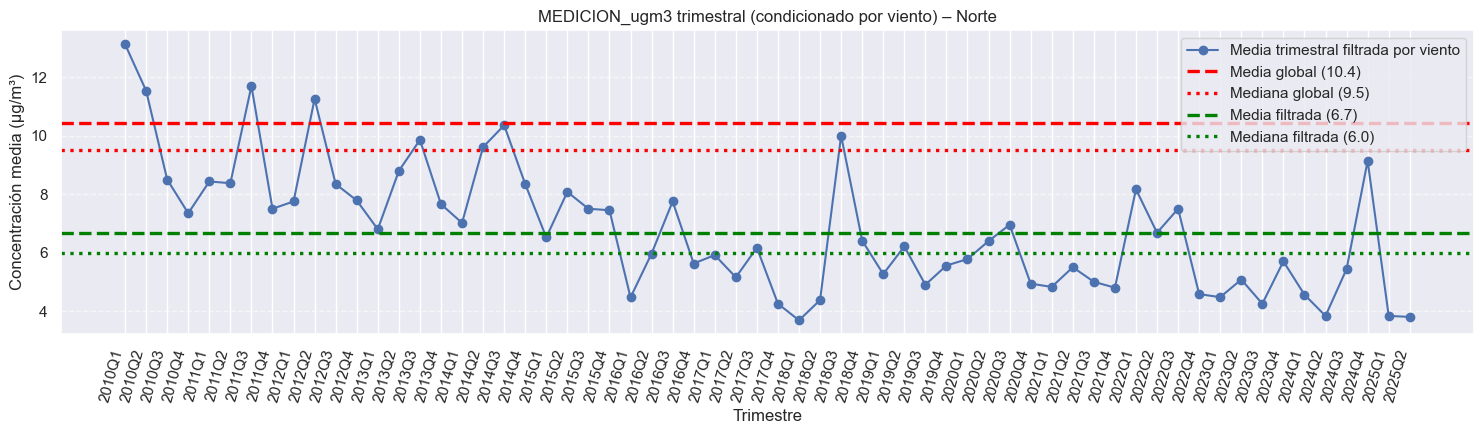

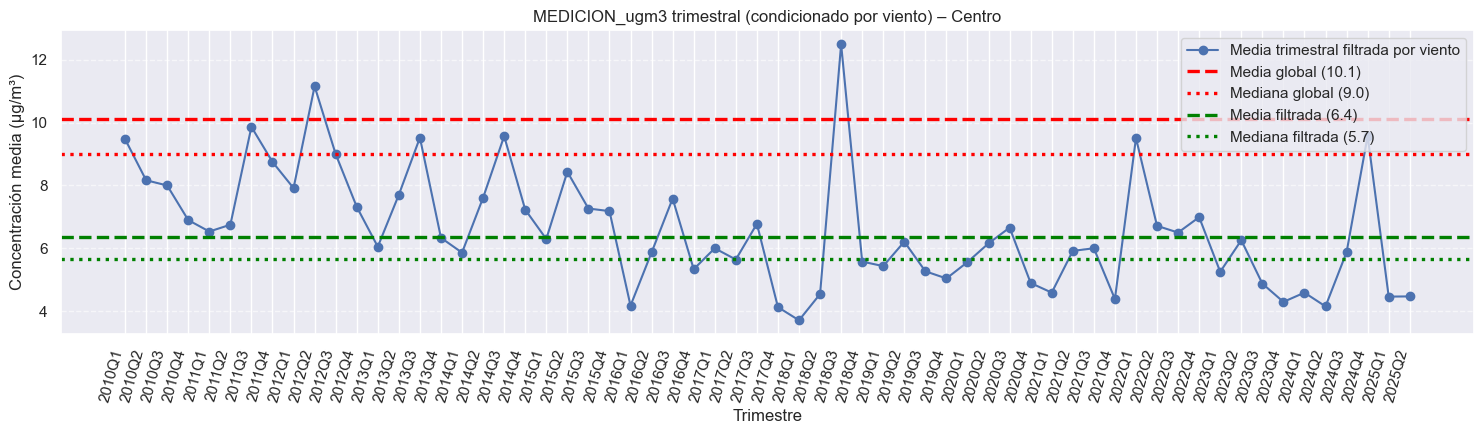

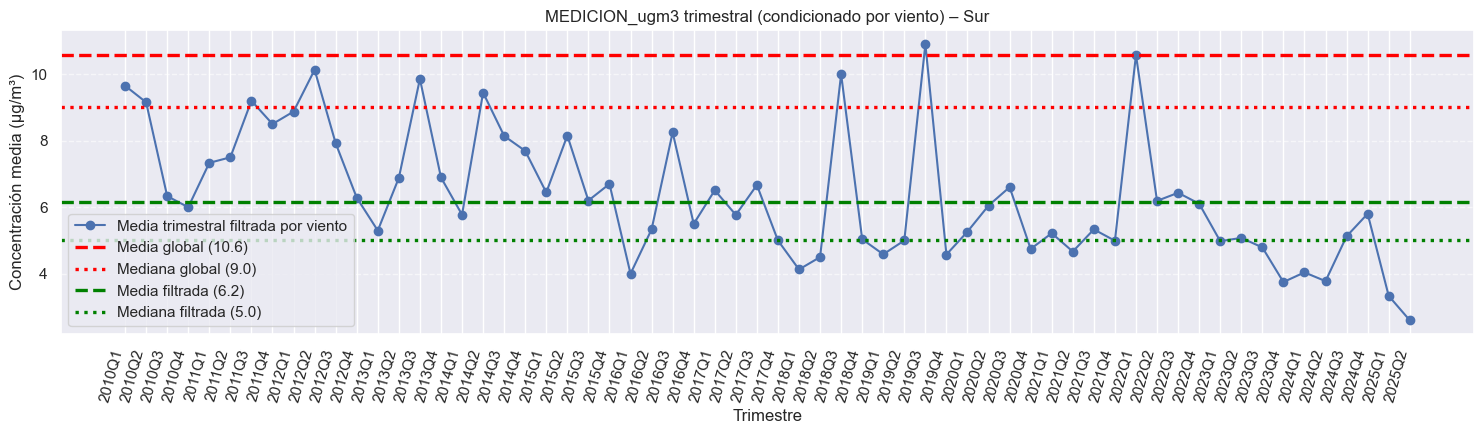

In [47]:
# --- Configuración ---
variables_viento = [ "VIENTO_MAX_10 (km/h)", "VIENTO_MIN_10 (km/h)", "VIENTO_MED_10 (km/h)", "VIENTO_MAX_100 (km/h)", "VIENTO_MIN_100 (km/h)", "VIENTO_MED_100 (km/h)" ]

zonas = {
    "Norte": df_9_norte,
    "Centro": df_9_centro,
    "Sur": df_9_sur,
}

for nombre, df in zonas.items():
    # Serie trimestral filtrada (como en tu código anterior)
    s = serie_trimestral_filtrada(df, variables_viento)

    # Formato del eje X
    etiquetas = [f"{p.year}Q{p.quarter}" for p in s.index]

    # === Líneas de referencia globales (sin filtrar) ===
    media_global = df["MEDICION_ugm3"].mean()
    mediana_global = df["MEDICION_ugm3"].median()

    # === Filtrado por viento (igual que en tu bucle inicial) ===
    p70 = df[variables_viento].quantile(0.7)
    mask = (df[variables_viento] > p70).all(axis=1)
    df_filtrado = df.loc[mask]

    # === Líneas de referencia filtradas ===
    media_filtrada = df_filtrado["MEDICION_ugm3"].mean()
    mediana_filtrada = df_filtrado["MEDICION_ugm3"].median()

    # === Gráfico ===
    plt.figure(figsize=(15, 4.5))
    plt.plot(etiquetas, s.values, marker="o", label="Media trimestral filtrada por viento")

    # Líneas de referencia globales
    plt.axhline(media_global, linestyle="--", linewidth=2.4, color="red",
                label=f"Media global ({media_global:.1f})")
    plt.axhline(mediana_global, linestyle=":", linewidth=2.4, color="red",
                label=f"Mediana global ({mediana_global:.1f})")

    # Líneas de referencia filtradas
    plt.axhline(media_filtrada, linestyle="--", linewidth=2.4, color="green",
                label=f"Media filtrada ({media_filtrada:.1f})")
    plt.axhline(mediana_filtrada, linestyle=":", linewidth=2.4, color="green",
                label=f"Mediana filtrada ({mediana_filtrada:.1f})")

    plt.title(f"MEDICION_ugm3 trimestral (condicionado por viento) – {nombre}")
    plt.xlabel("Trimestre")
    plt.ylabel("Concentración media (µg/m³)")
    plt.xticks(rotation=75, ha="right")
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()



Se observa que, a pesar de que en las mediciones de 2022 que vimos anteriormente, parecía que altos valores de viento podria hacer que la concentración de esta sustancia en el aire aumentara considerablemetne, se observa al hacer el filtrado que no es así ya que las medias de los darafrmes filtrados cuando los valores de viento superan sus percentiles 70%, es menor que las medias de los daframes globales (contando todas las mediciones)

## VALORES MÁXIMOS > VALORES LÍMITES

### A PARTIR DE 2015

In [48]:
for r in [df_9_norte, df_9_centro, df_9_sur]:
    df_filtrado_2015 = r[
        (r["DIA/MES/ANO"].dt.year == 2015) &
        (r["MEDICION_ugm3"] > 25)
    ]
    display(df_filtrado_2015[
        variables_interes_medic
    ].describe(include="all"))

ZONA_ESTACION  MEDICION_ugm3  VIENTO_MAX_10 (km/h)  \
count             18      18.000000             18.000000   
unique             1            NaN                   NaN   
top            NORTE            NaN                   NaN   
freq              18            NaN                   NaN   
mean             NaN      30.027778              7.506016   
std              NaN       2.664981              2.936308   
min              NaN      25.500000              5.411986   
25%              NaN      28.500000              6.017780   
50%              NaN      29.750000              6.787411   
75%              NaN      31.875000              7.504634   
max              NaN      35.000000             17.992796   

        VIENTO_MIN_10 (km/h)  VIENTO_MED_10 (km/h)  VIENTO_MAX_100 (km/h)  \
count              18.000000             18.000000              18.000000   
unique                   NaN                   NaN                    NaN   
top                      NaN                   NaN                    NaN   
freq                     NaN                   NaN                    NaN   
mean                1.284880              4.382743              11.145899   
std                 0.583796              1.574682               5.387055   
min                 0.509117              3.447571               6.109403   
25%                 0.804985              3.595983               8.326780   
50%                 1.218209              3.824121               9.663090   
75%                 1.578556              4.223197              12.550983   
max                 2.620839              9.825201              30.173496   

        VIENTO_MIN_100 (km/h)  VIENTO_MED_100 (km/h)  PRESION_MAX (hPa)  \
count               18.000000              18.000000          18.000000   
unique                    NaN                    NaN                NaN   
top                       NaN                    NaN                NaN   
freq                      NaN                    NaN                NaN   
mean                 0.966653               5.559504        1031.844444   
std                  0.546802               3.022297           4.194846   
min                  0.360000               3.301827        1019.800000   
25%                  0.509117               3.937681        1031.200000   
50%                  0.911609               4.794674        1032.500000   
75%                  1.138420               5.285691        1034.750000   
max                  2.305125              15.174858        1037.700000   

        PRESION_MIN (hPa)  PRESION_MED (hPa)     dow      month  \
count           18.000000          18.000000      18         18   
unique                NaN                NaN       6          4   
top                   NaN                NaN  Jueves  Diciembre   
freq                  NaN                NaN       4         14   
mean          1027.472222        1029.448624     NaN        NaN   
std              4.390070           4.435726     NaN        NaN   
min           1014.300000        1016.066830     NaN        NaN   
25%           1026.050000        1028.476975     NaN        NaN   
50%           1028.400000        1030.283400     NaN        NaN   
75%           1030.200000        1032.169775     NaN        NaN   
max           1032.700000        1035.483300     NaN        NaN   

        Superficie_incendiada_HA  
count                  18.000000  
unique                       NaN  
top                          NaN  
freq                         NaN  
mean                    2.050000  
std                     4.184706  
min                     0.000000  
25%                     0.000000  
50%                     0.000000  
75%                     2.075000  
max                    13.100000

ZONA_ESTACION  MEDICION_ugm3  VIENTO_MAX_10 (km/h)  \
count             16      16.000000             16.000000   
unique             1            NaN                   NaN   
top           CENTRO            NaN                   NaN   
freq              16            NaN                   NaN   
mean             NaN      29.208333              7.754558   
std              NaN       3.242941              3.029354   
min              NaN      25.333333              5.447788   
25%              NaN      26.500000              6.512406   
50%              NaN      29.166667              6.970322   
75%              NaN      31.166667              7.609082   
max              NaN      37.000000             17.992796   

        VIENTO_MIN_10 (km/h)  VIENTO_MED_10 (km/h)  VIENTO_MAX_100 (km/h)  \
count              16.000000             16.000000              16.000000   
unique                   NaN                   NaN                    NaN   
top                      NaN                   NaN                    NaN   
freq                     NaN                   NaN                    NaN   
mean                1.332545              4.463853              11.565369   
std                 0.586263              1.657224               5.569884   
min                 0.509117              3.447571               6.109403   
25%                 0.804985              3.571256               8.357851   
50%                 1.218209              3.898546              10.346799   
75%                 1.657477              4.309880              12.612675   
max                 2.620839              9.825201              30.173496   

        VIENTO_MIN_100 (km/h)  VIENTO_MED_100 (km/h)  PRESION_MAX (hPa)  \
count               16.000000              16.000000          16.000000   
unique                    NaN                    NaN                NaN   
top                       NaN                    NaN                NaN   
freq                      NaN                    NaN                NaN   
mean                 1.042485               5.773491        1031.562500   
std                  0.532591               3.148127           4.369725   
min                  0.360000               3.301827        1019.800000   
25%                  0.667279               4.081620        1030.400000   
50%                  1.018234               4.939001        1032.350000   
75%                  1.178315               5.483840        1034.650000   
max                  2.305125              15.174858        1037.700000   

        PRESION_MIN (hPa)  PRESION_MED (hPa)     dow      month  \
count           16.000000          16.000000      16         16   
unique                NaN                NaN       6          4   
top                   NaN                NaN  Jueves  Diciembre   
freq                  NaN                NaN       4         12   
mean          1027.218750        1029.178658     NaN        NaN   
std              4.592635           4.643993     NaN        NaN   
min           1014.300000        1016.066830     NaN        NaN   
25%           1025.325000        1027.766575     NaN        NaN   
50%           1028.050000        1029.977150     NaN        NaN   
75%           1029.700000        1032.258350     NaN        NaN   
max           1032.700000        1035.483300     NaN        NaN   

        Superficie_incendiada_HA  
count                  16.000000  
unique                       NaN  
top                          NaN  
freq                         NaN  
mean                    2.140625  
std                     4.419699  
min                     0.000000  
25%                     0.000000  
50%                     0.000000  
75%                     2.025000  
max                    13.100000

ZONA_ESTACION  MEDICION_ugm3  VIENTO_MAX_10 (km/h)  \
count             26      26.000000             26.000000   
unique             1            NaN                   NaN   
top              SUR            NaN                   NaN   
freq              26            NaN                   NaN   
mean             NaN      30.538462              7.401816   
std              NaN       3.478284              2.556561   
min              NaN      26.000000              5.411986   
25%              NaN      28.000000              6.217934   
50%              NaN      30.000000              6.671937   
75%              NaN      33.000000              7.551054   
max              NaN      39.000000             17.992796   

        VIENTO_MIN_10 (km/h)  VIENTO_MED_10 (km/h)  VIENTO_MAX_100 (km/h)  \
count              26.000000             26.000000              26.000000   
unique                   NaN                   NaN                    NaN   
top                      NaN                   NaN                    NaN   
freq                     NaN                   NaN                    NaN   
mean                1.240084              4.370426              11.430556   
std                 0.555329              1.346647               4.890609   
min                 0.360000              3.447571               6.109403   
25%                 0.804985              3.678626               8.515593   
50%                 1.297998              3.955481              10.663875   
75%                 1.578556              4.402739              12.550983   
max                 2.620839              9.825201              30.173496   

        VIENTO_MIN_100 (km/h)  VIENTO_MED_100 (km/h)  PRESION_MAX (hPa)  \
count               26.000000              26.000000          26.000000   
unique                    NaN                    NaN                NaN   
top                       NaN                    NaN                NaN   
freq                      NaN                    NaN                NaN   
mean                 1.047838               5.705405        1031.653846   
std                  0.542295               2.593990           4.332134   
min                  0.360000               3.301827        1019.800000   
25%                  0.561838               4.159948        1028.625000   
50%                  1.018234               5.032813        1032.500000   
75%                  1.437738               5.892450        1034.800000   
max                  2.305125              15.174858        1037.700000   

        PRESION_MIN (hPa)  PRESION_MED (hPa)     dow      month  \
count           26.000000          26.000000      26         26   
unique                NaN                NaN       6          5   
top                   NaN                NaN  Martes  Diciembre   
freq                  NaN                NaN       5         17   
mean          1027.396154        1029.343757     NaN        NaN   
std              4.544754           4.467741     NaN        NaN   
min           1014.300000        1016.066830     NaN        NaN   
25%           1025.425000        1026.776150     NaN        NaN   
50%           1028.400000        1030.283400     NaN        NaN   
75%           1030.800000        1032.391650     NaN        NaN   
max           1032.700000        1035.483300     NaN        NaN   

        Superficie_incendiada_HA  
count                  26.000000  
unique                       NaN  
top                          NaN  
freq                         NaN  
mean                    2.078846  
std                     3.933086  
min                     0.000000  
25%                     0.000000  
50%                     0.000000  
75%                     2.075000  
max                    13.100000

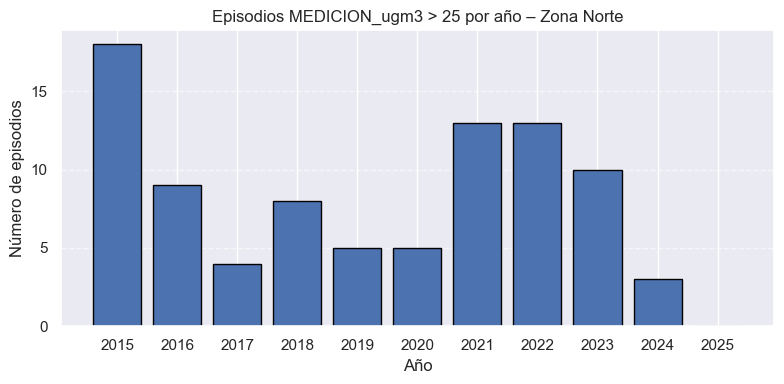

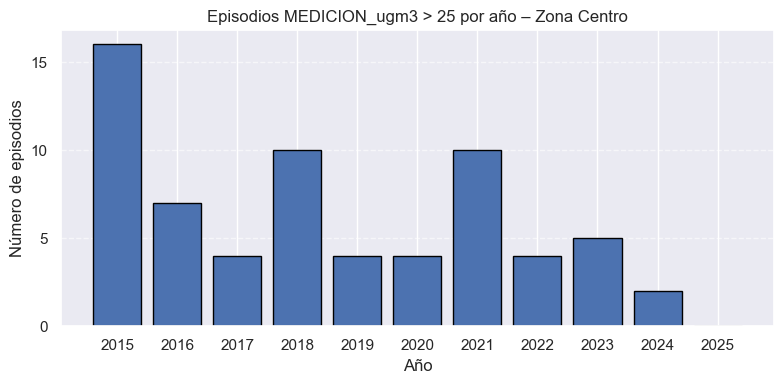

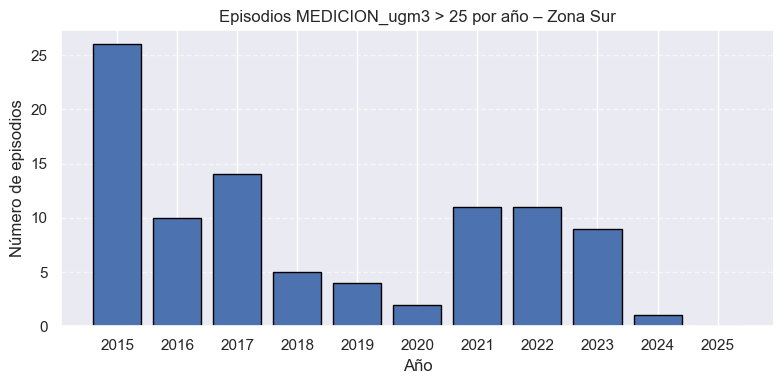

In [49]:
zonas = {
    "Norte": df_9_norte,
    "Centro": df_9_centro,
    "Sur": df_9_sur
}

anios = range(2015, 2026)

for nombre, r in zonas.items():
    r["DIA/MES/ANO"] = pd.to_datetime(r["DIA/MES/ANO"])

    conteo_anual = r[r["MEDICION_ugm3"] > 25].groupby(r["DIA/MES/ANO"].dt.year).size()
    conteo_anual = conteo_anual.reindex(anios, fill_value=0)

    plt.figure(figsize=(8, 4))
    plt.bar(conteo_anual.index.astype(str), conteo_anual.values, edgecolor='black')

    plt.yticks(range(0, conteo_anual.values.max() + 1, 5))

    plt.title(f"Episodios MEDICION_ugm3 > 25 por año – Zona {nombre}")
    plt.xlabel("Año")
    plt.ylabel("Número de episodios")
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()


Es curioso que en el año 2015, hubo varios días (más incluso de 25 en la zona sur) con con esta circunstancia, y que luego descendió hasta el año del inicio de la pandemia. Tras este descenso, volvió a subir, una vez se superó la pandemia.

### A PARTIR DE 2020

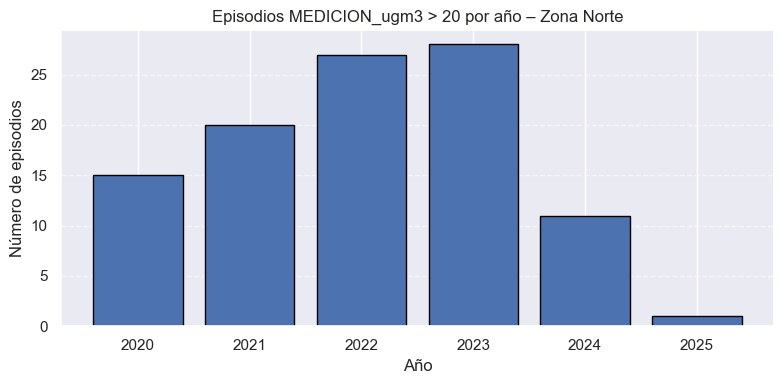

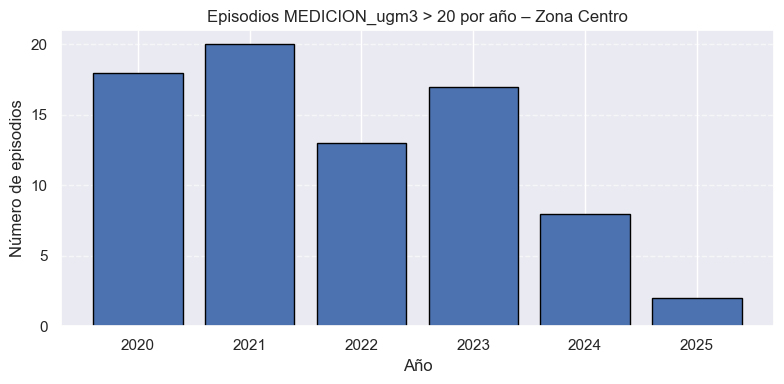

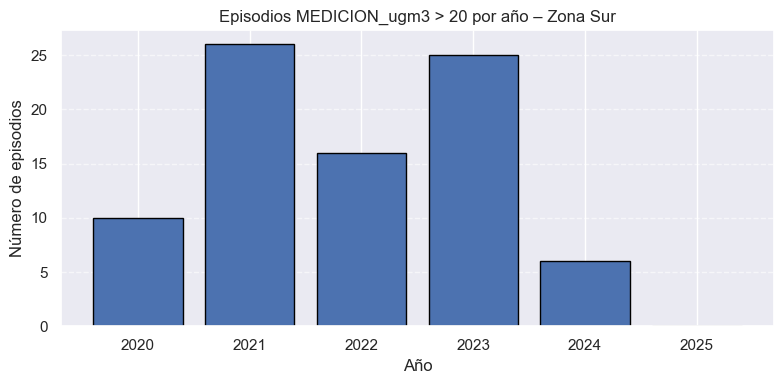

In [50]:
zonas = {
    "Norte": df_9_norte,
    "Centro": df_9_centro,
    "Sur": df_9_sur
}

anios = range(2020, 2026)

for nombre, r in zonas.items():
    r["DIA/MES/ANO"] = pd.to_datetime(r["DIA/MES/ANO"])

    conteo_anual = r[r["MEDICION_ugm3"] > 20].groupby(r["DIA/MES/ANO"].dt.year).size()
    conteo_anual = conteo_anual.reindex(anios, fill_value=0)

    plt.figure(figsize=(8, 4))
    plt.bar(conteo_anual.index.astype(str), conteo_anual.values, edgecolor='black')

    plt.yticks(range(0, conteo_anual.values.max() + 1, 5))

    plt.title(f"Episodios MEDICION_ugm3 > 20 por año – Zona {nombre}")
    plt.xlabel("Año")
    plt.ylabel("Número de episodios")
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()


Parece que la disminución de la concentración por debajo de los 20 µg/m³ aún no se ha conseguido estabilizar. Aún sigue habiendo numerosos episodios con esta circunstancia en las tres zonas

## MODELOS DE SERIES TEMPORALES

Se vana a aplicar seis modelos: ARIMA, CatBoost, LightGBM, XGBoost, LSTM y CNN.

- ARIMA (univariante)
- CatBoost, LightGBM, XGBoost (machine learning - multivariantes)
- LSTM y CNN (deep learning)

Sobre las mimas muestras, se van a comparar los RMSE. Tras esta comparación, se decide cual es el modelo mejor y se lleva a cabo una prediccion has el año 2032.

Con el objeto de poder hacer buenas estimaciones de los datos mediante los modelos, pasamos los datos diarios de cada uno de los dataframes a mensuales para llevar a cabo las predicciones:

In [51]:
tabla_rmse_modelos = []
tabla_predicciones_2030 = []

In [52]:
df_9_norte.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5660 entries, 0 to 5659
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   DIA/MES/ANO               5660 non-null   datetime64[ns]
 1   MAGNITUD                  5660 non-null   category      
 2   ZONA_ESTACION             5660 non-null   category      
 3   MEDICION_ugm3             5660 non-null   float64       
 4   TEMPERATURA_MAX (°C)      5660 non-null   float64       
 5   TEMPERATURA_MIN (°C)      5660 non-null   float64       
 6   TEMPERATURA_MED (°C)      5660 non-null   float64       
 7   PRECIPITACIONES (mm)      5660 non-null   float64       
 8   HUMEDAD_MAX (%)           5660 non-null   float64       
 9   HUMEDAD_MIN (%)           5660 non-null   float64       
 10  HUMEDAD_MED (%)           5660 non-null   float64       
 11  NIEVE (cm)                5660 non-null   float64       
 12  VIENTO_MAX_10 (km/h)

In [53]:
df_9_centro.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5660 entries, 0 to 5659
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   DIA/MES/ANO               5660 non-null   datetime64[ns]
 1   MAGNITUD                  5660 non-null   category      
 2   ZONA_ESTACION             5660 non-null   category      
 3   MEDICION_ugm3             5660 non-null   float64       
 4   TEMPERATURA_MAX (°C)      5660 non-null   float64       
 5   TEMPERATURA_MIN (°C)      5660 non-null   float64       
 6   TEMPERATURA_MED (°C)      5660 non-null   float64       
 7   PRECIPITACIONES (mm)      5660 non-null   float64       
 8   HUMEDAD_MAX (%)           5660 non-null   float64       
 9   HUMEDAD_MIN (%)           5660 non-null   float64       
 10  HUMEDAD_MED (%)           5660 non-null   float64       
 11  NIEVE (cm)                5660 non-null   float64       
 12  VIENTO_MAX_10 (km/h)

In [54]:
df_9_sur.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5660 entries, 0 to 5659
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   DIA/MES/ANO               5660 non-null   datetime64[ns]
 1   MAGNITUD                  5660 non-null   category      
 2   ZONA_ESTACION             5660 non-null   category      
 3   MEDICION_ugm3             5660 non-null   float64       
 4   TEMPERATURA_MAX (°C)      5660 non-null   float64       
 5   TEMPERATURA_MIN (°C)      5660 non-null   float64       
 6   TEMPERATURA_MED (°C)      5660 non-null   float64       
 7   PRECIPITACIONES (mm)      5660 non-null   float64       
 8   HUMEDAD_MAX (%)           5660 non-null   float64       
 9   HUMEDAD_MIN (%)           5660 non-null   float64       
 10  HUMEDAD_MED (%)           5660 non-null   float64       
 11  NIEVE (cm)                5660 non-null   float64       
 12  VIENTO_MAX_10 (km/h)

### MODELO ARIMA (AutoRegressive Integrated Moving Average)


ARIMA se trata de un análisis univariante de series temporales que busca predecir el valor futuro de una serie en función de:
- Sus propios valores pasados,
- La tendencia o diferencia acumulada,
- y los errores previos del modelo.

El modelo se define con tres parámetros --> ARIMA(p, d, q)

- p (Autorregresivo): Significa que el valor actual depende de **valores pasados** de la propia serie.
- d (Integrado): Indica cuántas veces se diferencian los datos para hacer la serie estacionaria, es decir, sin tendencia (no cambia con el tiempo) --> Media y varianza constantes y sin tendencias o ciclos marcados. Para comprobarlo se usan gráficos o tests (como Dickey-Fuller).
- q (Media móvil): Representa la dependencia del valor actual con los **errores pasados**.

ARIMA(p,d,q) = Diferenciar la serie d veces + aplicar un modelo AR(p) + MA(q)

**¿Cómo se estima un ARIMA?**
Generalmente se sigue este proceso:
- Visualizar la serie
→ ¿tiene tendencia o estacionalidad?
- Diferenciar si hace falta
→ hasta que sea estacionaria.
- Examinar los gráficos ACF (mide la correlación entre la serie y sus propios rezagos -lags-) y PACF (mide la correlación parcial, es decir, la relación entre el valor actual y un rezago específico eliminando el efecto de los rezagos intermedios)
→ ayudan a estimar los valores de p (PACF) y q (ACF).
- Probar varios modelos ARIMA(p,d,q)
→ comparar sus indicadores, normalmente el AIC (Akaike Information Criterion). Cuanto menor sea el AIC, mejor se ajusta el modelo con menos parámetros.
- Entrenar el modelo con los datos históricos.
- Evaluar el ajuste con datos de prueba (RMSE, MAPE, etc.).


#### 1) VISUALIZAR LA SERIE --> DETECTAR TENDENCIA/ESTACIONALIDAD

Los datos se pasan a mensuales por las siguientes razones:

**Ventajas:**
- Suaviza bastante el ruido diario.
- Se conserva la estacionalidad anual.
- Más observaciones que la trimestral (unas 180 si tengo 15 años).

**Problemas:** 
- Algo de ruido, pero razonable.



=== NORTE ===


C:\Users\rosal\AppData\Local\Temp\ipykernel_17984\831374094.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["year", "month"], as_index=False)


📁 Guardado gráfico en: 07_Figs\01_graficos_series_mensuales_MAG9\serie_mensual_NORTE.png


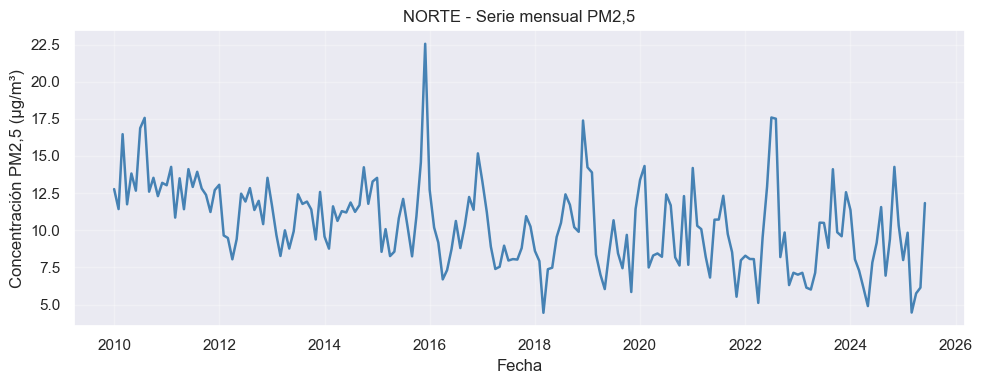


=== CENTRO ===


C:\Users\rosal\AppData\Local\Temp\ipykernel_17984\831374094.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["year", "month"], as_index=False)


📁 Guardado gráfico en: 07_Figs\01_graficos_series_mensuales_MAG9\serie_mensual_CENTRO.png


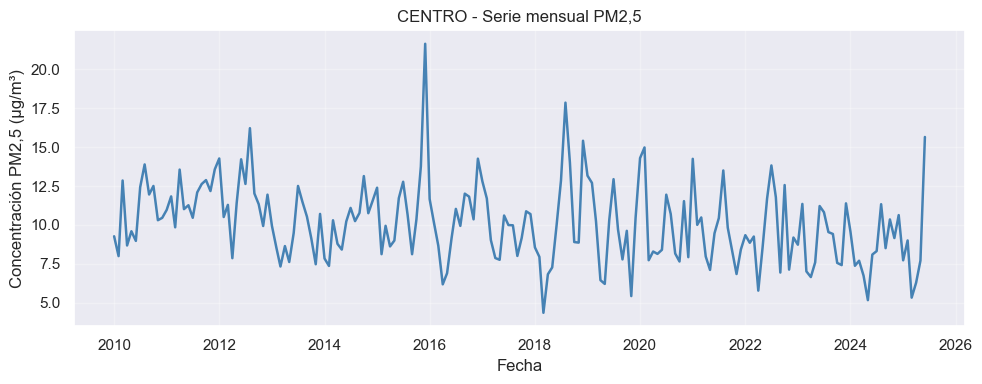


=== SUR ===


C:\Users\rosal\AppData\Local\Temp\ipykernel_17984\831374094.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["year", "month"], as_index=False)


📁 Guardado gráfico en: 07_Figs\01_graficos_series_mensuales_MAG9\serie_mensual_SUR.png


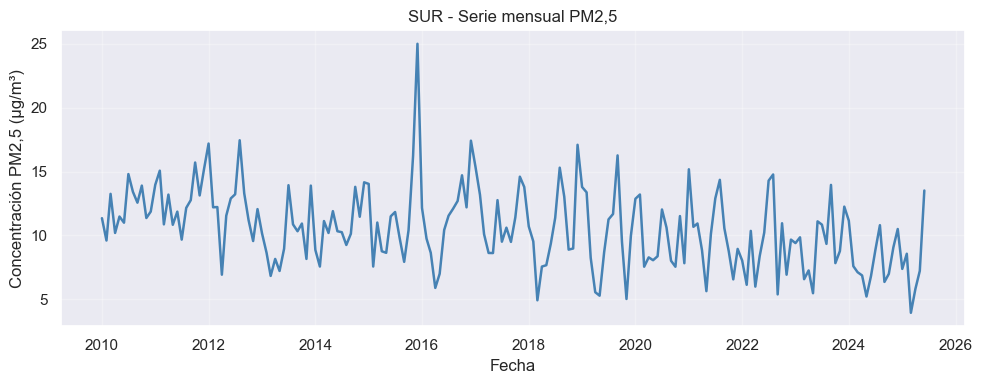

In [55]:
CARPETA_BASE = "07_Figs"
SUBCARPETA = "01_graficos_series_mensuales_MAG9"
CARPETA_SALIDA = os.path.join(CARPETA_BASE, SUBCARPETA)

# Crea la carpeta general y la subcarpeta si no existen
os.makedirs(CARPETA_SALIDA, exist_ok=True)

MAPA_MES = {
    "Enero": 1, "Febrero": 2, "Marzo": 3, "Abril": 4,
    "Mayo": 5, "Junio": 6, "Julio": 7, "Agosto": 8,
    "Septiembre": 9, "Octubre": 10, "Noviembre": 11, "Diciembre": 12
}

dfs_zonas = {
    "NORTE":  df_9_norte,
    "CENTRO": df_9_centro,
    "SUR":    df_9_sur
}

series_zonas = {}

for zona, df in dfs_zonas.items():
    print(f"\n=== {zona} ===")

    # 1. Agregación mensual
    df_mensual = agrupar_mensual(df)

    # 2. Serie temporal mensual limpia
    serie = preparar_serie_mensual(df_mensual)
    series_zonas[zona] = serie

    # 3. Definir nombre del archivo PNG
    nombre_png = os.path.join(CARPETA_SALIDA, f"serie_mensual_{zona}.png")

    # 4. Graficar y guardar sin mostrar
    plot_serie(serie, f"{zona} - Serie mensual PM2,5", nombre_salida=nombre_png, mostrar=True)

**TENDENCIA**

- Existen picos puntuales claramente identificables (por ejemplo en torno a 2016), pero no representan un cambio estructural sostenido.
- Esto sugiere que el componente de tendencia es débil o inexistente, por lo que el parámetro d en modelos ARIMA podría ser 0 o, a lo sumo, 1 si se trabajase con una diferenciación leve para estabilizar la varianza.

**ESTACIONALIDAD**

- Aunque se observan oscilaciones intraanuales, estas no siguen un patrón perfectamente regular.
- El comportamiento no es estrictamente periódico. Algunos años muestran máximos en meses cálidos, pero este efecto no se replica siempre con la misma intensidad ni en el mismo mes.
- Por tanto, se puede hablar de estacionalidad irregular o débil.
- La confirmación de este carácter la daremos en el análisis de ACF y PACF, donde la existencia o ausencia de picos significativos en lags estacionales será determinante.
   

#### 2) DIFERENCIAR (d) HASTA SERIE ESTACIONARIA

Para cada zona (NORTE, CENTRO, SUR):
- Aplicar el test de Dickey–Fuller aumentado (ADF) sobre la serie original.
- Si no es estacionaria (p > 0.05), diferenciar una vez y volver a comprobar.
- Repetir hasta alcanzar estacionariedad o un máximo de 2 diferencias. Más de 2, podría introducir ruido y generar sobreajuste.
- Guardar los gráficos: 1) Serie original, 2) Serie diferenciada (una o dos veces)

In [56]:
# -------------------------------------------------
# Configuración de carpetas
# -------------------------------------------------
CARPETA_BASE = "07_Figs"
SUBCARPETA = "02_diferenciacion_ARIMA_MAG9"
CARPETA_SALIDA = os.path.join(CARPETA_BASE, SUBCARPETA)
os.makedirs(CARPETA_SALIDA, exist_ok=True)

# -------------------------------------------------
# Bucle principal por zona
# -------------------------------------------------
resultados_d = []

for zona, serie in series_zonas.items():
    print(f"\n=== {zona} ===")

    carpeta_zona = os.path.join(CARPETA_SALIDA, zona)
    os.makedirs(carpeta_zona, exist_ok=True)

    # Paso 1: test ADF en serie original
    p0 = test_adf(serie, f"{zona} original")
    plot_serie_diferenciada(serie, f"{zona} - Serie original", os.path.join(carpeta_zona, "serie_original.png"))

    d_opt = 0 # Inicializo iteración
    serie_dif = serie.copy()

    # Paso 2: diferenciar si no estacionaria
    while p0 > 0.05 and d_opt < 2:
        d_opt += 1 # Aumento en +1 la iteración
        serie_dif = diferencia_serie(serie, d=d_opt)
        p0 = test_adf(serie_dif, f"{zona} Δ{d_opt}")
        plot_serie_diferenciada(serie_dif, f"{zona} - Serie diferenciada Δ{d_opt}", 
                                os.path.join(carpeta_zona, f"serie_diferenciada_d{d_opt}.png"))

    # Guardar resultado
    estacionaria = "Sí" if p0 <= 0.05 else "No"
    resultados_d.append({
        "Zona": zona,
        "d_optimo": d_opt,
        "p_final": round(p0, 4),
        "Estacionaria": estacionaria
    })

# -------------------------------------------------
# Resumen final
# -------------------------------------------------
df_est = pd.DataFrame(resultados_d)
print("\n>>> RESULTADOS DIFERENCIACIÓN <<<")
print(df_est.to_string(index=False))


=== NORTE ===
ADF NORTE original: estadístico=-2.758, p-valor=0.0645
📁 Guardado gráfico: 07_Figs\02_diferenciacion_ARIMA_MAG9\NORTE\serie_original.png
ADF NORTE Δ1: estadístico=-8.350, p-valor=0.0000
📁 Guardado gráfico: 07_Figs\02_diferenciacion_ARIMA_MAG9\NORTE\serie_diferenciada_d1.png

=== CENTRO ===
ADF CENTRO original: estadístico=-2.586, p-valor=0.0959
📁 Guardado gráfico: 07_Figs\02_diferenciacion_ARIMA_MAG9\CENTRO\serie_original.png
ADF CENTRO Δ1: estadístico=-8.330, p-valor=0.0000
📁 Guardado gráfico: 07_Figs\02_diferenciacion_ARIMA_MAG9\CENTRO\serie_diferenciada_d1.png

=== SUR ===
ADF SUR original: estadístico=-1.473, p-valor=0.5470
📁 Guardado gráfico: 07_Figs\02_diferenciacion_ARIMA_MAG9\SUR\serie_original.png
ADF SUR Δ1: estadístico=-8.671, p-valor=0.0000
📁 Guardado gráfico: 07_Figs\02_diferenciacion_ARIMA_MAG9\SUR\serie_diferenciada_d1.png

>>> RESULTADOS DIFERENCIACIÓN <<<
  Zona  d_optimo  p_final Estacionaria
 NORTE         1      0.0           Sí
CENTRO         1      

Con lo cual se concluye que para las tres zonas solo hace falta una diferenciación.

#### 3) EVALUAR GRÁFICOS ACF y PACF → AYUDAN A ELEGIR p y q

In [57]:
# -------------------------------------------------
# Config carpeta salida para esta fase
# -------------------------------------------------
CARPETA_BASE = "07_Figs"
SUBCARPETA = "03_acf_pacf_ARIMA_MAG9"
CARPETA_SALIDA = os.path.join(CARPETA_BASE, SUBCARPETA)
os.makedirs(CARPETA_SALIDA, exist_ok=True)

# -------------------------------------------------
# Calculo zona por zona
# -------------------------------------------------
resumen_modelado = []

# Pasamos resultados_d (lista de dicts) a dict indexado por zona para acceso rápido
d_por_zona = {fila["Zona"]: fila["d_optimo"] for fila in resultados_d}

for zona, serie_original in series_zonas.items():
    print(f"\n=== {zona} ===")

    # 1) d óptimo encontrado en la fase anterior
    d_opt = d_por_zona[zona]

    # 2) construyo la serie estacionaria aplicando esa d
    serie_estacionaria = aplicar_diferenciacion(serie_original, d_opt)

    # 3) guardo ACF y PACF en disco
    guardar_acf_pacf(serie_estacionaria, zona, CARPETA_SALIDA, lags=49) # lag = 49 (equivalente a 4 años)

    # 4) registro info útil para elegir p y q
    resumen_modelado.append({
        "Zona": zona,
        "d": d_opt,
        "n_obs_estacionaria": len(serie_estacionaria)
    })

# 5) resumen en dataframe
df_resumen_modelado = pd.DataFrame(resumen_modelado)
print("\n>>> RESUMEN PARA ESTIMACIÓN ARIMA <<<")
print(df_resumen_modelado.to_string(index=False))


=== NORTE ===
📁 Guardado: 07_Figs\03_acf_pacf_ARIMA_MAG9\NORTE\acf.png
📁 Guardado: 07_Figs\03_acf_pacf_ARIMA_MAG9\NORTE\pacf.png

=== CENTRO ===
📁 Guardado: 07_Figs\03_acf_pacf_ARIMA_MAG9\CENTRO\acf.png
📁 Guardado: 07_Figs\03_acf_pacf_ARIMA_MAG9\CENTRO\pacf.png

=== SUR ===
📁 Guardado: 07_Figs\03_acf_pacf_ARIMA_MAG9\SUR\acf.png
📁 Guardado: 07_Figs\03_acf_pacf_ARIMA_MAG9\SUR\pacf.png

>>> RESUMEN PARA ESTIMACIÓN ARIMA <<<
  Zona  d  n_obs_estacionaria
 NORTE  1                 185
CENTRO  1                 185
   SUR  1                 185


<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

**INTERPRETACIÓN**

*NORTE*
- ACF: Caída rápida hacia 0 justo después de lag 1.
- PACF: Primeros lags con valores pequeños y algunos negativos, pero la mayoría dentro de la banda de confianza. Este patrón indica componente MA(1) más que AR, con diferenciación aplicada.
- Modelo candidato: ARIMA(0,1,1) → por el corte rápido en la ACF. Alternativa: ARIMA(1,1,1)

*CENTRO*
- ACF: No muestra correlaciones persistentes. Tras el lag 1, los valores se sitúan dentro del intervalo de confianza. No se aprecia estructura clara.
- PACF: Igual que en ACF, solo unos pocos valores iniciales ligeramente fuera o cercanos al límite, pero sin un patrón consistente. La serie diferenciada está cerca de ruido blanco, es decir, no hay una dependencia temporal fuerte. Esto sugiere que no hay una estructura AR ni MA dominante.
- Modelos candidatos: ARIMA(0,1,1) → captura pequeñas dependencias cortas, suele ser estable. Alternativas: ARIMA(1,1,0) y ARIMA(0,1,0) 
  
*SUR*
- ACF: Pico claro en lag 1, seguido de caída rápida.
- PACF: También muestra un pico inicial significativo. Esto sugiere dependencia de primer orden: el valor actual depende principalmente del valor inmediatamente anterior.
- Es un comportamiento AR(1) más claro que en Norte y Centro.
- Modelos candidatos: ARIMA(1,1,0). Alternativas: ARIMA(1,1,1) y ARIMA(0,1,1).


#### 4) COMPARAR ARIMAS CON AIC

In [58]:
# -------------------------------------------------
# Definición de candidatos por zona
# -------------------------------------------------
candidatos_por_zona = {
    "NORTE":  [(0,1,1), (1,1,1)],
    "CENTRO": [(0,1,1), (1,1,0), (0,1,0)],
    "SUR":    [(1,1,0), (1,1,1), (0,1,1)]
}


# -------------------------------------------------
# Bucle principal
# -------------------------------------------------
resultados_finales = []

for zona, serie in series_zonas.items():
    print(f"\n======================")
    print(f"ZONA {zona}")
    print(f"======================")

    # 1️⃣ División temporal
    train, test = train_test_split_temporal(serie, fecha_corte='2024-06-30')

    if len(test) == 0:
        print("No hay datos de test tras la fecha de corte. Se omite evaluación.")
        continue

    # 2️⃣ Evaluación de modelos candidatos
    mejor_aic = np.inf
    mejor_order = None
    mejor_ajuste = None

    for order in candidatos_por_zona[zona]:
        print(f"\nProbando ARIMA{order}...")
        aic_val, ajuste = ajustar_y_aic(train, order)

        if np.isfinite(aic_val):
            print(f"   AIC = {aic_val:.2f}")
        else:
            print("   Modelo no válido")

        if aic_val < mejor_aic:
            mejor_aic = aic_val
            mejor_order = order
            mejor_ajuste = ajuste

    # 3️⃣ Predicción en test con el mejor modelo
    if mejor_ajuste is not None:
        pred_test = mejor_ajuste.forecast(steps=len(test))
        rmse_test = evaluar_modelo(f"ARIMA{mejor_order} ({zona})", test, pred_test)
    else:
        rmse_test = np.nan

    # 4️⃣ Guardar resultados
    resultados_finales.append({
        "Zona": zona,
        "Mejor_(p,d,q)": mejor_order,
        "AIC": round(mejor_aic, 2),
        "RMSE_test": round(rmse_test, 3),
        "n_train": len(train),
        "n_test": len(test)
    })

    # Guardar info de desempeño del mejor ARIMA por zona
    tabla_rmse_modelos.append({
        "modelo": "ARIMA",
        "zona": zona,
        "order": mejor_order,
        "seasonal_order": None,
        "AIC": mejor_aic,
        "RMSE_test": rmse_test
    })


# -------------------------------------------------
# 5️⃣ Tabla resumen final
# -------------------------------------------------
df_resultados_arima = pd.DataFrame(resultados_finales)
print("\n>>> RESULTADOS ARIMA (Selección por AIC y validación en test) <<<")
print(df_resultados_arima.to_string(index=False))




ZONA NORTE

Probando ARIMA(0, 1, 1)...
   AIC = 820.67

Probando ARIMA(1, 1, 1)...
   AIC = 792.22


C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency informa

ARIMA(1, 1, 1) (NORTE) → RMSE: 2.760

ZONA CENTRO

Probando ARIMA(0, 1, 1)...
   AIC = 805.95

Probando ARIMA(1, 1, 0)...
   AIC = 825.85

Probando ARIMA(0, 1, 0)...
   AIC = 833.57


C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency informa

ARIMA(0, 1, 1) (CENTRO) → RMSE: 2.595

ZONA SUR

Probando ARIMA(1, 1, 0)...
   AIC = 889.08

Probando ARIMA(1, 1, 1)...
   AIC = 845.21

Probando ARIMA(0, 1, 1)...


C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency informa

   AIC = 866.72
ARIMA(1, 1, 1) (SUR) → RMSE: 2.666

>>> RESULTADOS ARIMA (Selección por AIC y validación en test) <<<
  Zona Mejor_(p,d,q)    AIC  RMSE_test  n_train  n_test
 NORTE     (1, 1, 1) 792.22      2.760      174      12
CENTRO     (0, 1, 1) 805.95      2.595      174      12
   SUR     (1, 1, 1) 845.21      2.666      174      12


**MODELOS ELEGIDOS**

- NORTE: ARIMA (1, 1, 1)
- CENTRO: ARIMA (0, 1, 1)
- SUR: ARIMA (1, 1, 1)


#### 5) ENTRENAR MODELO FINAL Y GENERAR PREDICCIONES

In [59]:
# -------------------------------------------------
# Configuración de carpetas de salida
# -------------------------------------------------
CARPETA_BASE = "07_Figs"
SUBCARPETA = "04_predicciones_finales_ARIMA_MAG9"
CARPETA_SALIDA = os.path.join(CARPETA_BASE, SUBCARPETA)
os.makedirs(CARPETA_SALIDA, exist_ok=True)


=== ZONA NORTE ===
ARIMA(1, 1, 1) (NORTE) → RMSE: 2.760


C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


📁 Guardado gráfico: 07_Figs\04_predicciones_finales_ARIMA_MAG9\predicciones_NORTE.png


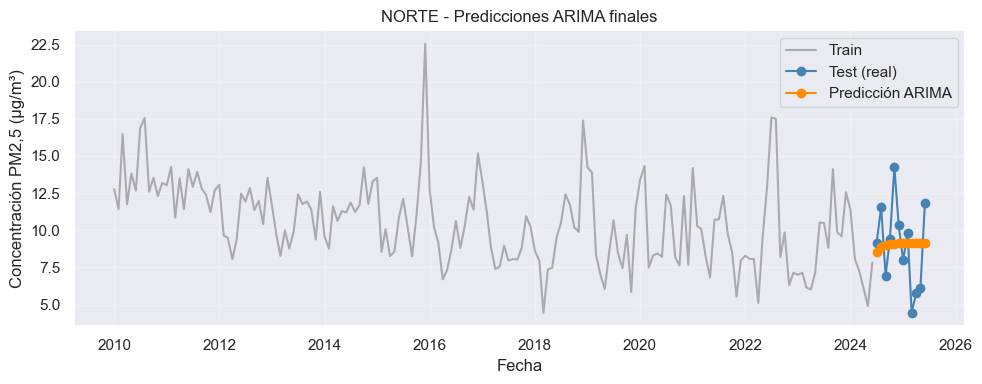


=== ZONA CENTRO ===
ARIMA(0, 1, 1) (CENTRO) → RMSE: 2.595


C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


📁 Guardado gráfico: 07_Figs\04_predicciones_finales_ARIMA_MAG9\predicciones_CENTRO.png


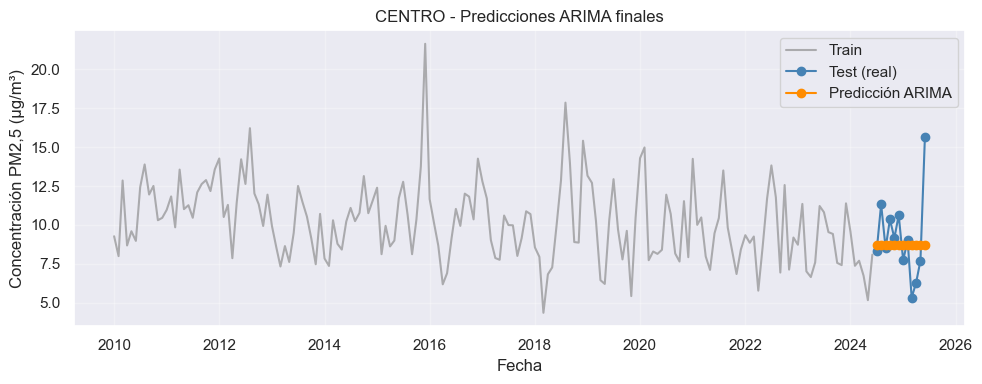


=== ZONA SUR ===
ARIMA(1, 1, 1) (SUR) → RMSE: 2.666


C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


📁 Guardado gráfico: 07_Figs\04_predicciones_finales_ARIMA_MAG9\predicciones_SUR.png


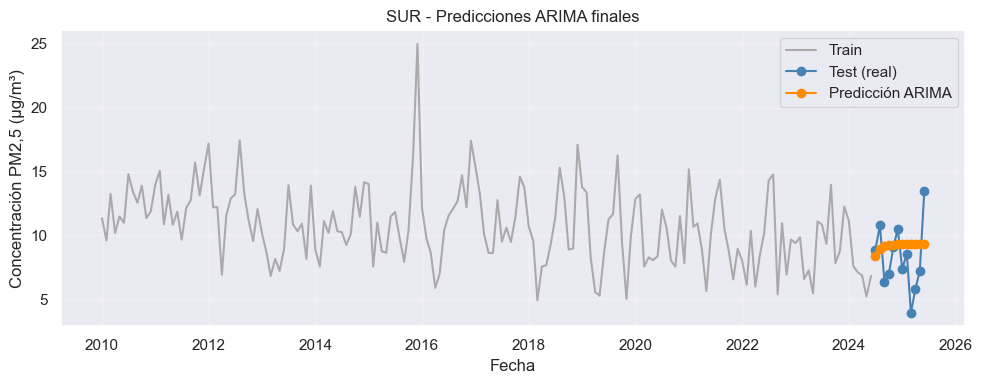


>>> RESULTADOS FINALES ARIMA <<<
  Zona ARIMA_(p,d,q)    AIC  RMSE_test  n_train  n_test
 NORTE     (1, 1, 1) 792.22      2.760      174      12
CENTRO     (0, 1, 1) 805.95      2.595      174      12
   SUR     (1, 1, 1) 845.21      2.666      174      12


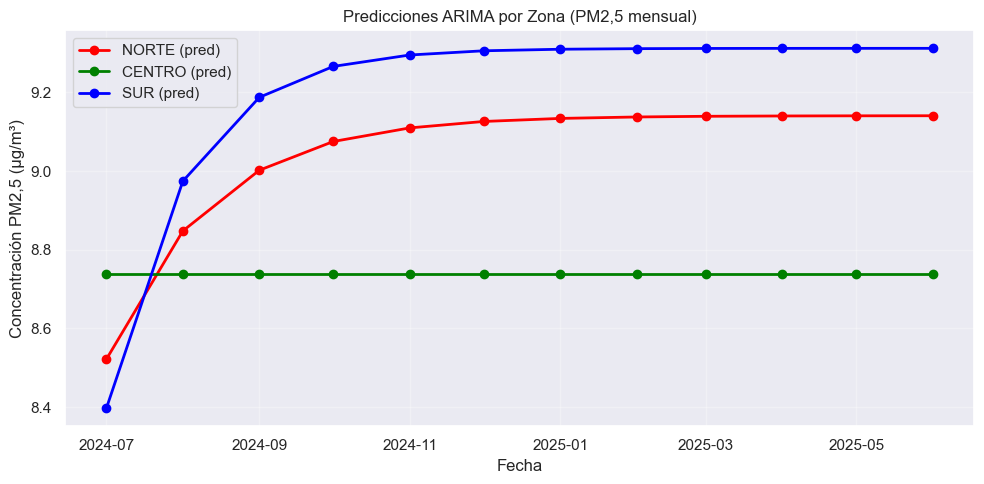


📁 Guardado gráfico combinado: 07_Figs\04_predicciones_finales_ARIMA_MAG9\predicciones_conjuntas_zonas.png


In [60]:
# -------------------------------------------------
# MODELOS FINALES (según selección previa)
# -------------------------------------------------
modelos_finales = {
    "NORTE":  (1,1,1),
    "CENTRO": (0,1,1),
    "SUR":    (1,1,1)
}

# -------------------------------------------------
# ENTRENAMIENTO Y PREDICCIONES POR ZONA
# -------------------------------------------------
resultados_pred = []
predicciones_zonas = {}

for zona, serie in series_zonas.items():
    print(f"\n=== ZONA {zona} ===")

    order = modelos_finales[zona]
    train, test = train_test_split_temporal(serie, fecha_corte="2024-06-30")

    # Entrenamiento del modelo
    modelo = ARIMA(train, order=order)
    ajuste = modelo.fit()

    # Predicción sobre el conjunto de test
    pred_test = ajuste.forecast(steps=len(test))

    # Evaluación (usando tu función)
    rmse_test = evaluar_modelo(f"ARIMA{order} ({zona})", test, pred_test)
    aic_modelo = ajuste.aic

    # Guardar y mostrar gráfico individual
    nombre_png = os.path.join(CARPETA_SALIDA, f"predicciones_{zona}.png")
    plot_predicciones(zona, train, test, pred_test, nombre_png, mostrar=True)

    # Guardar dataframe de predicciones
    predicciones_zonas[zona] = pd.DataFrame({
        "real": test.values,
        "pred": pred_test.values
    }, index=test.index)

    # Registrar resultados
    resultados_pred.append({
        "Zona": zona,
        "ARIMA_(p,d,q)": order,
        "AIC": round(aic_modelo, 2),
        "RMSE_test": round(rmse_test, 3),
        "n_train": len(train),
        "n_test": len(test)
    })

# -------------------------------------------------
# TABLA RESUMEN FINAL
# -------------------------------------------------
df_pred = pd.DataFrame(resultados_pred)
print("\n>>> RESULTADOS FINALES ARIMA <<<")
print(df_pred.to_string(index=False))

# -------------------------------------------------
# GRÁFICO CONJUNTO: PREDICCIONES DE LAS 3 ZONAS
# -------------------------------------------------
plt.figure(figsize=(10,5))

colores = {"NORTE": "red", "CENTRO": "green", "SUR": "blue"}

for zona, df_pred in predicciones_zonas.items():
    plt.plot(df_pred.index, df_pred["pred"], marker="o", linewidth=2,
             color=colores.get(zona, None), label=f"{zona} (pred)")

plt.title("Predicciones ARIMA por Zona (PM2,5 mensual)")
plt.xlabel("Fecha")
plt.ylabel("Concentración PM2,5 (µg/m³)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

ruta_figura = os.path.join(CARPETA_SALIDA, "predicciones_conjuntas_zonas.png")
plt.savefig(ruta_figura, dpi=150)
plt.show()
plt.close()

print(f"\n📁 Guardado gráfico combinado: {ruta_figura}")

#### 6) PREDICCIÓN HASTA DICIEMBRE 2030 Y 2032


=== ZONA NORTE ===


C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


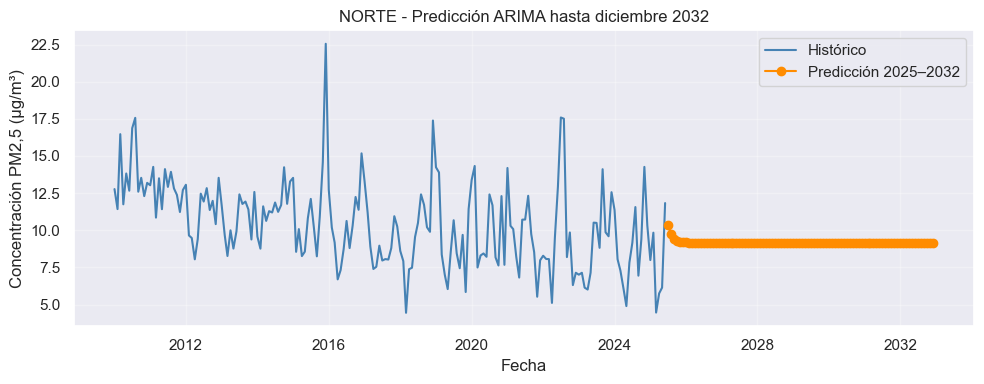

📁 Guardado gráfico: 07_Figs\05_predicciones_largo_plazo_ARIMA_MAG9\prediccion_2032_NORTE.png

=== ZONA CENTRO ===


C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


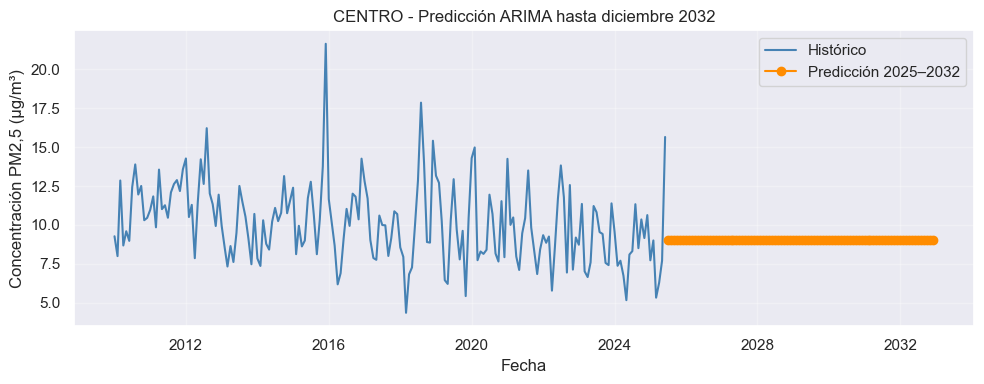

📁 Guardado gráfico: 07_Figs\05_predicciones_largo_plazo_ARIMA_MAG9\prediccion_2032_CENTRO.png

=== ZONA SUR ===


C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


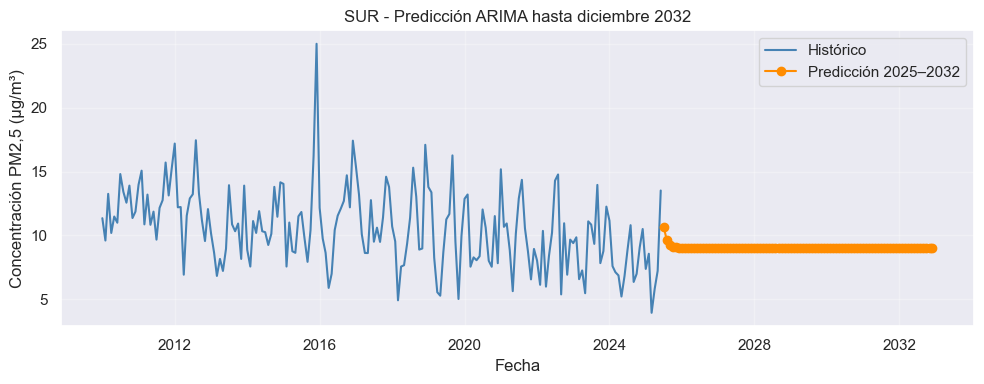

📁 Guardado gráfico: 07_Figs\05_predicciones_largo_plazo_ARIMA_MAG9\prediccion_2032_SUR.png


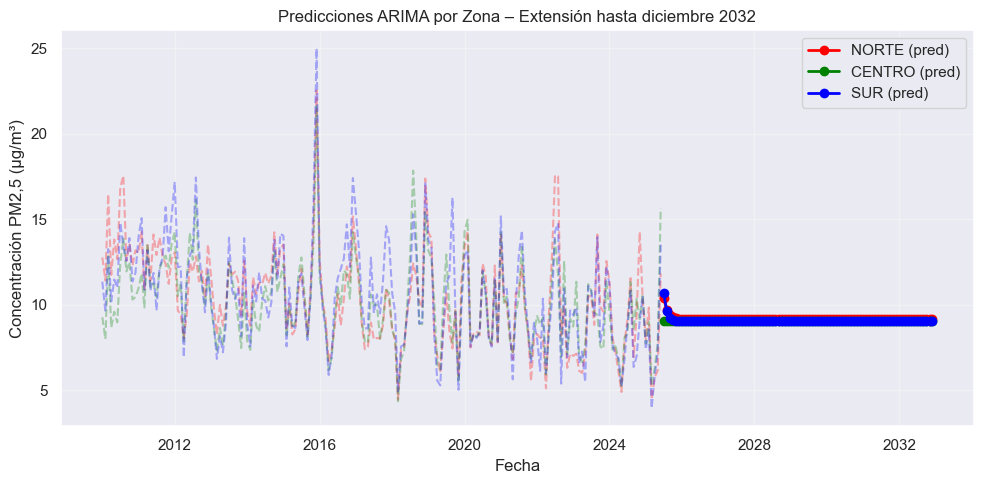


📁 Guardado gráfico combinado: 07_Figs\05_predicciones_largo_plazo_ARIMA_MAG9\predicciones_conjuntas_2032.png

📁 Guardado CSV con predicciones completas: 07_Figs\05_predicciones_largo_plazo_ARIMA_MAG9\predicciones_PM2,5_hasta_2032.csv

>>> ÚLTIMAS PREDICCIONES (diciembre 2032) <<<
 PM2,5_pred_NORTE  PM2,5_pred_CENTRO  PM2,5_pred_SUR
            9.171               9.03           9.046

>>> PREDICCIONES ANUALES (enero–diciembre 2030) <<<
            PM2,5_pred_NORTE  PM2,5_pred_CENTRO  PM2,5_pred_SUR
2030-01-01             9.171               9.03           9.046
2030-02-01             9.171               9.03           9.046
2030-03-01             9.171               9.03           9.046
2030-04-01             9.171               9.03           9.046
2030-05-01             9.171               9.03           9.046
2030-06-01             9.171               9.03           9.046
2030-07-01             9.171               9.03           9.046
2030-08-01             9.171               9.03

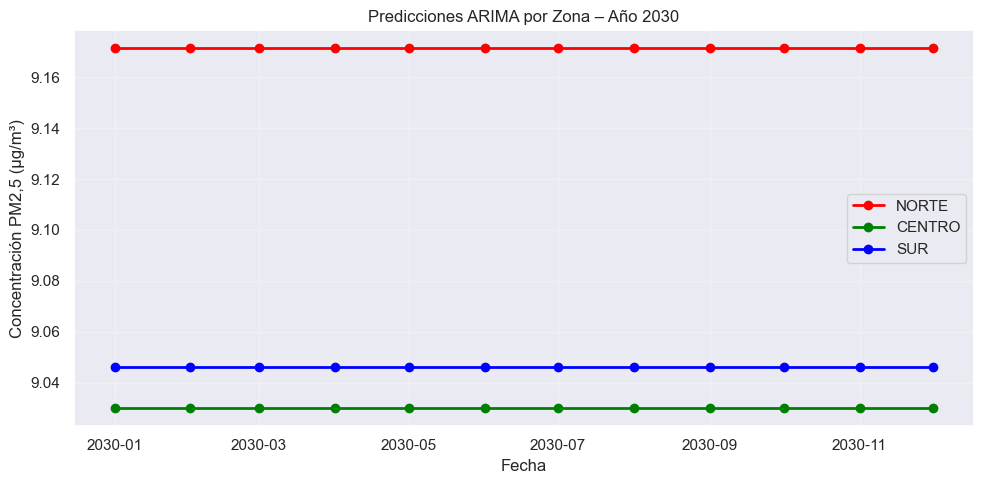


📁 Guardado gráfico 2030: 07_Figs\05_predicciones_largo_plazo_ARIMA_MAG9\predicciones_conjuntas_2030.png


In [61]:
# -------------------------------------------------
# Configuración de carpeta de salida
# -------------------------------------------------
CARPETA_BASE = "07_Figs"
SUBCARPETA = "05_predicciones_largo_plazo_ARIMA_MAG9"
CARPETA_SALIDA = os.path.join(CARPETA_BASE, SUBCARPETA)
os.makedirs(CARPETA_SALIDA, exist_ok=True)

# -------------------------------------------------
# Modelos finales por zona (ya validados)
# -------------------------------------------------
modelos_finales = {
    "NORTE":  (1,1,1),
    "CENTRO": (0,1,1),
    "SUR":    (1,1,1)
}

# -------------------------------------------------
# Horizonte de predicción
# -------------------------------------------------
fecha_final_pred = "2032-12-31"

# -------------------------------------------------
# Bucle de predicción por zona
# -------------------------------------------------
predicciones_largo_plazo = {}

for zona, serie in series_zonas.items():
    print(f"\n=== ZONA {zona} ===")

    order = modelos_finales[zona]

    # Entrenamiento con toda la serie disponible
    modelo = ARIMA(serie, order=order)
    ajuste = modelo.fit()

    # Número de meses a predecir
    ultimo_mes = serie.index.max()
    horizonte = pd.date_range(start=ultimo_mes + pd.offsets.MonthBegin(1),
                              end=fecha_final_pred, freq="MS")
    n_steps = len(horizonte)

    # Predicción a largo plazo
    pred = ajuste.forecast(steps=n_steps)
    pred.index = horizonte

    # Guardamos los resultados
    predicciones_largo_plazo[zona] = pred

    # -------------------------------------------------
    # Gráfico por zona
    # -------------------------------------------------
    plt.figure(figsize=(10,4))
    plt.plot(serie.index, serie.values, label="Histórico", color="steelblue")
    plt.plot(pred.index, pred.values, label="Predicción 2025–2032", color="darkorange", marker="o")
    plt.title(f"{zona} - Predicción ARIMA hasta diciembre 2032")
    plt.xlabel("Fecha")
    plt.ylabel("Concentración PM2,5 (µg/m³)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    ruta_png = os.path.join(CARPETA_SALIDA, f"prediccion_2032_{zona}.png")
    plt.savefig(ruta_png, dpi=150)
    plt.show()
    plt.close()

    print(f"📁 Guardado gráfico: {ruta_png}")

# -------------------------------------------------
# Gráfico combinado (todas las zonas)
# -------------------------------------------------
plt.figure(figsize=(10,5))
colores = {"NORTE": "red", "CENTRO": "green", "SUR": "blue"}

for zona, pred in predicciones_largo_plazo.items():
    plt.plot(pred.index, pred.values, color=colores[zona], linewidth=2, marker="o", label=f"{zona} (pred)")
    plt.plot(series_zonas[zona].index, series_zonas[zona].values, color=colores[zona], alpha=0.3, linestyle="--")

plt.title("Predicciones ARIMA por Zona – Extensión hasta diciembre 2032")
plt.xlabel("Fecha")
plt.ylabel("Concentración PM2,5 (µg/m³)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

ruta_figura = os.path.join(CARPETA_SALIDA, "predicciones_conjuntas_2032.png")
plt.savefig(ruta_figura, dpi=150)
plt.show()
plt.close()

print(f"\n📁 Guardado gráfico combinado: {ruta_figura}")

# -------------------------------------------------
# Tabla resumen de predicciones finales
# -------------------------------------------------
df_pred_2032 = pd.concat(predicciones_largo_plazo, axis=1)
df_pred_2032.columns = [f"PM2,5_pred_{zona}" for zona in df_pred_2032.columns]

# Guardar CSV con todas las predicciones
csv_path = os.path.join(CARPETA_SALIDA, "predicciones_PM2,5_hasta_2032.csv")
df_pred_2032.to_csv(csv_path)
print(f"\n📁 Guardado CSV con predicciones completas: {csv_path}")

print("\n>>> ÚLTIMAS PREDICCIONES (diciembre 2032) <<<")
print(df_pred_2032.tail(1).round(3).to_string(index=False))

# -------------------------------------------------
# PREDICCIONES DEL AÑO 2030
# -------------------------------------------------
# Filtrar las filas correspondientes a 2030
df_pred_2030 = df_pred_2032[df_pred_2032.index.year == 2030]

print("\n>>> PREDICCIONES ANUALES (enero–diciembre 2030) <<<")
print(df_pred_2030.round(3).to_string())

# Guardar CSV con predicciones 2030
csv_2030_path = os.path.join(CARPETA_SALIDA, "predicciones_PM2,5_2030.csv")
df_pred_2030.to_csv(csv_2030_path)
print(f"\n📁 Guardado CSV con predicciones de 2030: {csv_2030_path}")

# -------------------------------------------------
# Promedio anual de 2030 por zona
# -------------------------------------------------
promedios_2030 = df_pred_2030.mean().round(3)
print("\n>>> PROMEDIO ANUAL PREVISTO PARA 2030 (µg/m³) <<<")
print(promedios_2030)

# Volcado de predicciones ARIMA 2030 en tabla global
for zona in ["NORTE", "CENTRO", "SUR"]:
    # Para cada zona tenemos la serie mensual 2030: df_pred_2030[f"PM2,5_pred_{zona}"]
    serie_zona_2030 = df_pred_2030[f"PM2,5_pred_{zona}"]

    for fecha, valor_predicho in serie_zona_2030.items():
        tabla_predicciones_2030.append({
            "modelo": "ARIMA",
            "zona": zona,
            "fecha": fecha,                   # índice tipo Timestamp
            "anio": fecha.year,               # 2030
            "mes": fecha.month,               # 1..12
            "pred_2030": valor_predicho,      # µg/m³
            "promedio_anual_2030": promedios_2030[f"PM2,5_pred_{zona}"]
        })

# -------------------------------------------------
# Gráfico conjunto de las tres zonas – año 2030
# -------------------------------------------------
plt.figure(figsize=(10,5))
for zona, color in {"NORTE": "red", "CENTRO": "green", "SUR": "blue"}.items():
    plt.plot(df_pred_2030.index, df_pred_2030[f"PM2,5_pred_{zona}"], marker="o",
             linewidth=2, color=color, label=zona)

plt.title("Predicciones ARIMA por Zona – Año 2030")
plt.xlabel("Fecha")
plt.ylabel("Concentración PM2,5 (µg/m³)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

ruta_figura_2030 = os.path.join(CARPETA_SALIDA, "predicciones_conjuntas_2030.png")
plt.savefig(ruta_figura_2030, dpi=150)
plt.show()
plt.close()

print(f"\n📁 Guardado gráfico 2030: {ruta_figura_2030}")

#### 7) RESUMEN METODOLÓGICO

1.	Se representa la serie temporal de concentración de partículas y se inspecciona visualmente la presencia de tendencia y patrones repetitivos (estacionalidad).
2.	Se aplica diferenciación sucesiva y se contrasta con el test ADF hasta obtener una serie estacionaria. Ese número de diferenciaciones se toma como el parámetro d del modelo ARIMA(p,d,q).
3.	Sobre la serie estacionaria se analizan las funciones de autocorrelación (ACF) y autocorrelación parcial (PACF). Los cortes significativos en PACF sugieren candidatos para p, y en ACF para q.
4.	Con esos candidatos se ajustan distintos modelos ARIMA(p,d,q) sobre el conjunto de entrenamiento y se selecciona el modelo con menor AIC, ya que el AIC penaliza la complejidad del modelo y favorece especificaciones parsimoniosas.
5.	El modelo ARIMA seleccionado se entrena con los datos históricos (train) y se utiliza para predecir el tramo de prueba (test).
6.	El rendimiento predictivo se evalúa con métricas fuera de muestra como RMSE.
7.  En base a los modelos óptimos obtenidos, se extraen los gráficos de predicción hasta 2030 y 2032.

#### 8) CONCLUSION

Los gráficos de predicción a largo plazo son planos, sin apenas estacionalidad ni tendencia visible a partir de 2025. Esto es un síntoma clásico de que los modelos ARIMA que elegimos están sobreajustados al ruido a corto plazo o que la diferenciación eliminó completamente la estructura temporal.

Es, por ello, por lo que vamos a aolizar modelos SARIMA que permite oscilaciones en el horizonte largo.

### MODELO SARIMA (Seasonal ARIMA)

El modelo SARIMA (Seasonal AutoRegressive Integrated Moving Average) es una extensión del modelo ARIMA diseñada específicamente para manejar datos de series temporales que presentan patrones estacionales. Su notación completa es:

*SARIMA(p,d,q)(P,D,Q,s)*

- 𝑝, 𝑑, 𝑞 --> Componentes no estacionales. Permite captar tendencias a corto plazo.
- P, D, Q --> componentes estacionales. Permite captar patrones estacionales.
- s --> Periodicidad de la estacionalidad (12 para datos mensuales).

Para la parte estacional (P, D, Q) tomaré siguientes valores para las tres zonas y observaré si existe o no mejoras sobre el ARIMA:

- “D = 1”: Existen ligeras evidencias de estacionalidad.
- “P = 0”: No aparece ningún pico marcado en lag 12 en tus PACF
- “Q = 1”: No hay un pico fuerte en 12, pero sí se aprecia una ligera resonancia (sube un poco por encima de cero, más que en otros lags).

De modo que:



=== ZONA NORTE ===


C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


NORTE (test) → RMSE: 2.446


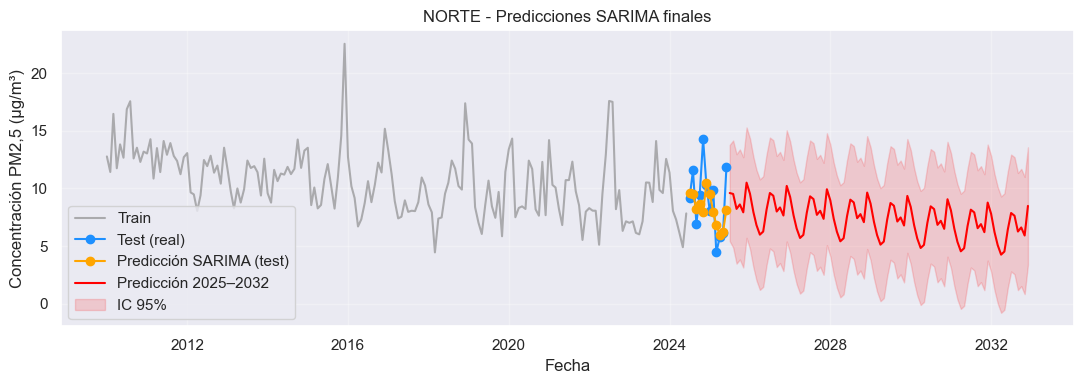

📁 Guardado gráfico: 07_Figs\06_predicciones_largo_plazo_SARIMA_MAG9\SARIMA_predicciones_NORTE.png

=== ZONA CENTRO ===


C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


CENTRO (test) → RMSE: 2.328


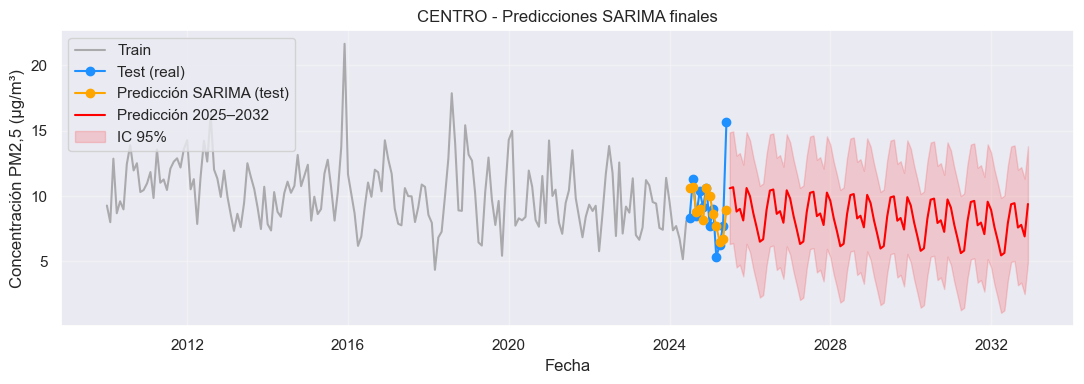

📁 Guardado gráfico: 07_Figs\06_predicciones_largo_plazo_SARIMA_MAG9\SARIMA_predicciones_CENTRO.png

=== ZONA SUR ===


C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SUR (test) → RMSE: 2.335


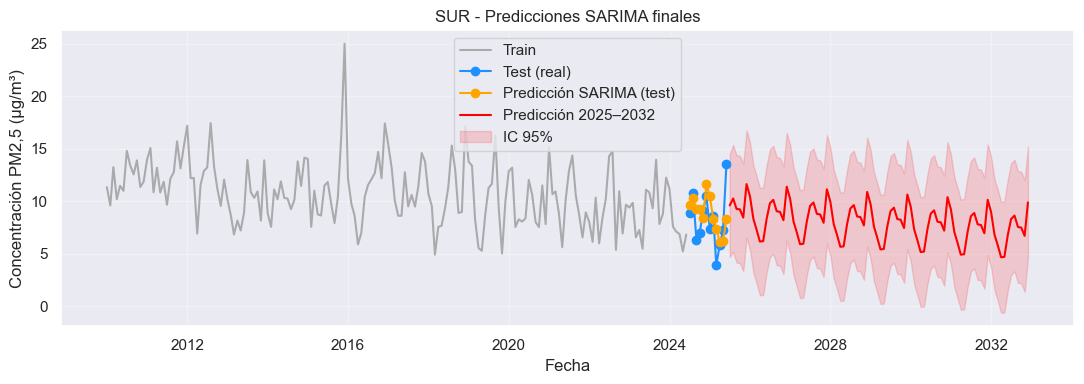

📁 Guardado gráfico: 07_Figs\06_predicciones_largo_plazo_SARIMA_MAG9\SARIMA_predicciones_SUR.png

📁 Guardado CSV: 07_Figs\06_predicciones_largo_plazo_SARIMA_MAG9\SARIMA_predicciones_PM2,5_hasta_2032.csv

>>> PREDICCIÓN DICIEMBRE 2032 (SARIMA) <<<
 PM2,5_pred_NORTE  PM2,5_pred_CENTRO  PM2,5_pred_SUR
            8.484              9.391             9.9

📁 Guardado CSV 2030: 07_Figs\06_predicciones_largo_plazo_SARIMA_MAG9\SARIMA_predicciones_PM2,5_2030.csv

>>> PROMEDIOS ANUALES 2030 (SARIMA) <<<
PM2,5_pred_NORTE     7.004
PM2,5_pred_CENTRO    8.076
PM2,5_pred_SUR       7.707
dtype: float64


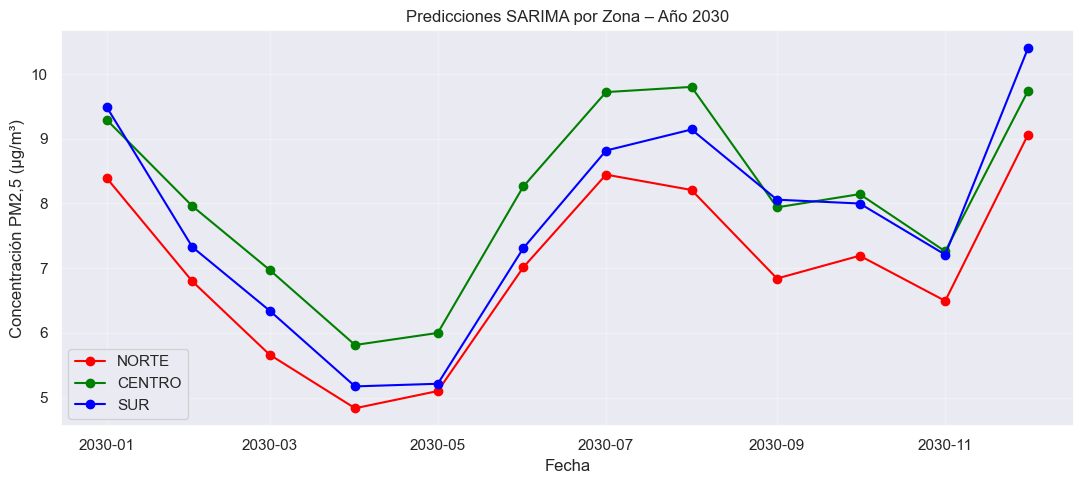

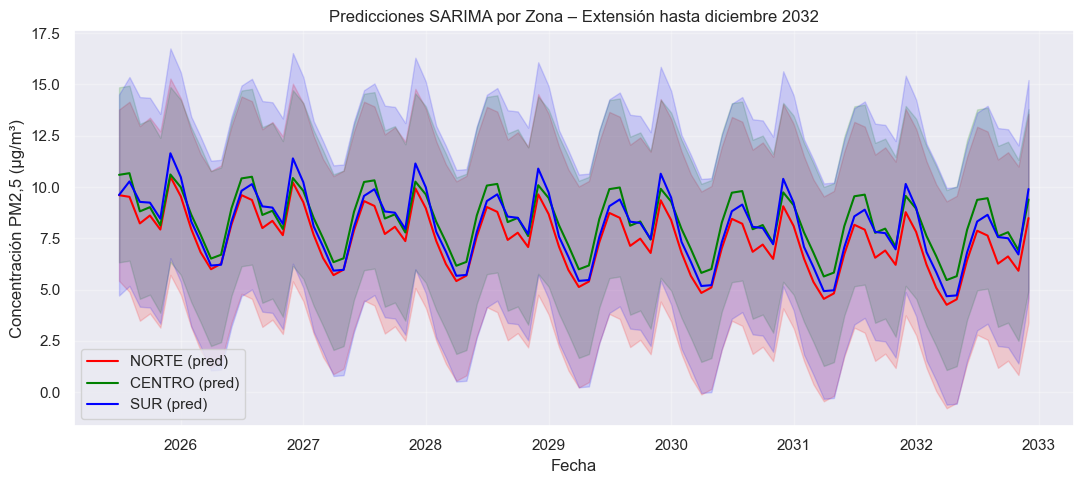


>>> RESUMEN MODELOS SARIMA (AIC y RMSE) <<<
  Zona     order seasonal_order    AIC  RMSE_test  n_obs  RMSE_test_ARIMA
 NORTE (1, 1, 1)  (0, 1, 1, 12) 663.68      2.446    186            2.760
CENTRO (0, 1, 1)  (0, 1, 1, 12) 667.01      2.328    186            2.595
   SUR (1, 1, 1)  (0, 1, 1, 12) 710.87      2.335    186            2.666


In [62]:

# =================================================
# 1. CONFIGURACIÓN DE CARPETAS
# =================================================
CARPETA_BASE = "07_Figs"
SUBCARPETA = "06_predicciones_largo_plazo_SARIMA_MAG9"
CARPETA_SALIDA = os.path.join(CARPETA_BASE, SUBCARPETA)
os.makedirs(CARPETA_SALIDA, exist_ok=True)

# ==========================================================
# 3️⃣ Definir modelos SARIMA por zona
# ==========================================================
modelos_sarima = {
    "NORTE":  {"order": (1,1,1), "seasonal_order": (0,1,1,12)},
    "CENTRO": {"order": (0,1,1), "seasonal_order": (0,1,1,12)},
    "SUR":    {"order": (1,1,1), "seasonal_order": (0,1,1,12)}
}

# ==========================================================
# 4️⃣ Horizonte de predicción
# ==========================================================
fecha_final_pred = "2032-12-31"
fecha_corte = "2024-06-30"  # corte temporal para evaluar RMSE

# ==========================================================
# 5️⃣ Bucle por zona: entrenar, evaluar, predecir largo plazo
# ==========================================================
predicciones_largo_plazo = {}
resultados_info = []

for zona, serie in series_zonas.items():
    print(f"\n=== ZONA {zona} ===")

    # Dividir train/test
    train = serie.loc[:fecha_corte]
    test = serie.loc[fecha_corte:]

    order = modelos_sarima[zona]["order"]
    seasonal_order = modelos_sarima[zona]["seasonal_order"]

    # --------------------------
    # Ajustar SARIMA
    # --------------------------
    modelo = SARIMAX(
        train,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    ajuste = modelo.fit(disp=False)

    # --------------------------
    # Predicción sobre test
    # --------------------------
    pred_test = ajuste.get_forecast(steps=len(test))
    pred_mean = pred_test.predicted_mean
    rmse = evaluar_modelo(f"{zona} (test)", test, pred_mean)

    # Guardar RMSE SARIMA por zona
  # Guardar RMSE SARIMA por zona
    tabla_rmse_modelos.append({
        "modelo": "SARIMA",
        "zona": zona,
        "order": order,
        "seasonal_order": seasonal_order,
        "AIC": round(ajuste.aic, 2),
        "RMSE_test": rmse
    })

    # --------------------------
    # Predicción a largo plazo (2025–2032)
    # --------------------------
    ultimo_mes = serie.index.max()
    horizonte = pd.date_range(
        start=ultimo_mes + pd.offsets.MonthBegin(1),
        end=fecha_final_pred,
        freq="MS"
    )
    n_steps = len(horizonte)
    forecast_res = ajuste.get_forecast(steps=n_steps)

    pred_media = forecast_res.predicted_mean
    ic = forecast_res.conf_int(alpha=0.05)
    pred_media.index = horizonte
    ic.index = horizonte
    ic.columns = ["ic_inf", "ic_sup"]

    # Guardar resultados
    df_pred = pd.DataFrame({
        "pred": pred_media,
        "ic_inf": ic["ic_inf"],
        "ic_sup": ic["ic_sup"]
    })
    predicciones_largo_plazo[zona] = df_pred

    # --------------------------
    # Información de modelo
    # --------------------------
    resultados_info.append({
        "Zona": zona,
        "order": order,
        "seasonal_order": seasonal_order,
        "AIC": round(ajuste.aic, 2),
        "RMSE_test": round(rmse, 3),
        "n_obs": len(serie)
    })

    # --------------------------
    # Gráfico por zona
    # --------------------------
    plt.figure(figsize=(11,4))
    plt.plot(train.index, train.values, color="gray", alpha=0.6, label="Train")
    plt.plot(test.index, test.values, color="dodgerblue", marker="o", label="Test (real)")
    plt.plot(pred_mean.index, pred_mean.values, color="orange", marker="o", label="Predicción SARIMA (test)")

    plt.plot(df_pred.index, df_pred["pred"], color="red", linewidth=1.5, label="Predicción 2025–2032")
    plt.fill_between(df_pred.index, df_pred["ic_inf"], df_pred["ic_sup"], color="red", alpha=0.15, label="IC 95%")

    plt.title(f"{zona} - Predicciones SARIMA finales")
    plt.xlabel("Fecha")
    plt.ylabel("Concentración PM2,5 (µg/m³)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()

    ruta_png = os.path.join(CARPETA_SALIDA, f"SARIMA_predicciones_{zona}.png")
    plt.savefig(ruta_png, dpi=150)
    plt.show()
    plt.close()

    print(f"📁 Guardado gráfico: {ruta_png}")

# ==========================================================
# 6️⃣ Resumen de predicciones largo plazo
# ==========================================================
df_pred_all = pd.concat(
    {zona: predicciones_largo_plazo[zona]["pred"] for zona in predicciones_largo_plazo},
    axis=1
)
df_pred_all.columns = [f"PM2,5_pred_{zona}" for zona in df_pred_all.columns]

# Guardar CSV
csv_todo = os.path.join(CARPETA_SALIDA, "SARIMA_predicciones_PM2,5_hasta_2032.csv")
df_pred_all.to_csv(csv_todo)
print(f"\n📁 Guardado CSV: {csv_todo}")

# Última fila (dic 2032)
print("\n>>> PREDICCIÓN DICIEMBRE 2032 (SARIMA) <<<")
print(df_pred_all.tail(1).round(3).to_string(index=False))

# ==========================================================
# 7️⃣ Predicciones 2030 + Promedio anual
# ==========================================================
df_pred_2030 = df_pred_all[df_pred_all.index.year == 2030]
promedios_2030 = df_pred_2030.mean().round(3)

# Volcado de predicciones SARIMA 2030 en tabla global
for zona in ["NORTE", "CENTRO", "SUR"]:
    serie_zona_2030 = df_pred_2030[f"PM2,5_pred_{zona}"]

    for fecha, valor_predicho in serie_zona_2030.items():
        tabla_predicciones_2030.append({
            "modelo": "SARIMA",
            "zona": zona,
            "fecha": fecha,
            "anio": fecha.year,
            "mes": fecha.month,
            "pred_2030": valor_predicho,
            "promedio_anual_2030": promedios_2030[f"PM2,5_pred_{zona}"]
        })

csv_2030 = os.path.join(CARPETA_SALIDA, "SARIMA_predicciones_PM2,5_2030.csv")
df_pred_2030.to_csv(csv_2030)
print(f"\n📁 Guardado CSV 2030: {csv_2030}")

print("\n>>> PROMEDIOS ANUALES 2030 (SARIMA) <<<")
print(promedios_2030)

# ==========================================================
# 8️⃣ Gráfico conjunto 2030
# ==========================================================
plt.figure(figsize=(11,5))
colores = {"NORTE": "red", "CENTRO": "green", "SUR": "blue"}

for zona, color in colores.items():
    plt.plot(df_pred_2030.index, df_pred_2030[f"PM2,5_pred_{zona}"], color=color, marker="o", label=zona)

plt.title("Predicciones SARIMA por Zona – Año 2030")
plt.xlabel("Fecha")
plt.ylabel("Concentración PM2,5 (µg/m³)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

ruta_fig_2030 = os.path.join(CARPETA_SALIDA, "SARIMA_predicciones_conjuntas_2030.png")
plt.savefig(ruta_fig_2030, dpi=150)
plt.show()

# ==========================================================
# 9️⃣ Gráfico conjunto 2032 (predicciones largas)
# ==========================================================
plt.figure(figsize=(11,5))
for zona, color in colores.items():
    df_z = predicciones_largo_plazo[zona]
    plt.plot(df_z.index, df_z["pred"], color=color, label=f"{zona} (pred)")
    plt.fill_between(df_z.index, df_z["ic_inf"], df_z["ic_sup"], color=color, alpha=0.15)

plt.title("Predicciones SARIMA por Zona – Extensión hasta diciembre 2032")
plt.xlabel("Fecha")
plt.ylabel("Concentración PM2,5 (µg/m³)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

ruta_fig_2032 = os.path.join(CARPETA_SALIDA, "SARIMA_predicciones_conjuntas_2032.png")
plt.savefig(ruta_fig_2032, dpi=150)
plt.show()

# ==========================================================
# 🔟 Tabla resumen modelos (AIC, RMSE, etc.)
# ==========================================================

df_info = pd.DataFrame(resultados_info)
df_info ["RMSE_test_ARIMA"]=df_resultados_arima ["RMSE_test"]
print("\n>>> RESUMEN MODELOS SARIMA (AIC y RMSE) <<<")
print(df_info.to_string(index=False))

**CONCLUSIÓN:** Se comprueba que la predicción SARIMA mejora a la ARIMA, ya que el RMSE_test es más bajo

### MODELOS MACHINE LEARNING (CASTBOOST, LightGBM y XGBOOST)

Los modelos aplicados anteriormente (ARIMA/SARIMA) son modelos clásicos que aprenden la dinámica temporal interna de la serie directamente (usa rezagos, diferencias, estacionalidad). Sin embargo, en estos modelos no hemos considerado ninguna otra variable exógena, hemos hecho el análisis univariante sin más.

Los modelos de Machine Learning como CatBoost, LightGBM y XGBoost se basan en el algoritmo de Gradient Boosting y se caracterizan por lo siguiente:

- Son modelos supervisados de regresión tabular. Es decir: Son modelos que aprende a predecir una variable numérica continua a partir de datos estructurados en forma de tabla, usando un conjunto de datos donde ya se conoce el valor objetivo y contra lo que compararemos una vez el modelo haya porcedido a la predicción.
- Se debe construir el dataset: cada fila = un mes, con variables explicativas, y objetivo.
- No entienden por sí mismos la secuencia temporal. Se las tenemos que dar tú mediante: 1) lags (valores anteriores), 2) medias móviles, 3) mes del año, 4) tendencia temporal, 5) variables exógenas

**DIFERENCIAS ENTRE CASTBOOST, LightGBM y XGBOOST**

- *CatBoost*: Ideal cuando tienes muchas variables categóricas. Evita el preprocesamiento manual y es muy estable con pocos datos.
- *LightGBM*: Perfecto para grandes volúmenes de datos. Usa una estrategia de crecimiento por hojas (leaf-wise) que acelera el entrenamiento y mejora la precisión, aunque puede sobreajustar si no se regula.
- *XGBoost*: El más veterano y versátil. Rendimiento sólido y facilidad de ajuste.


#### 1) DEFINIR OBJETIVO

En este apartado sólo vamos a definir la parte de los datos que luego vamos a predecir.

In [63]:
objetivos_por_zona = {}

for zona, serie in series_zonas.items():
    # Aseguramos nombre claro
    serie_objetivo = serie.copy()
    serie_objetivo.name = "PM2,5_objetivo"

    # Aseguramos que el índice sea DatetimeIndex mensual ordenado
    serie_objetivo = serie_objetivo.sort_index()
    if not isinstance(serie_objetivo.index, pd.DatetimeIndex):
        raise ValueError(f"La serie de {zona} no tiene un DatetimeIndex. Revisa preparar_serie_mensual().")

    # Guardamos para futuros pasos
    objetivos_por_zona[zona] = serie_objetivo

    # Mostramos un pequeño resumen para inspección
    print(f"\n=== {zona} ===")
    print("Primeras filas:")
    print(serie_objetivo.head())
    print("Últimas filas:")
    print(serie_objetivo.tail())
    print(f"Rango temporal: {serie_objetivo.index.min().date()} -> {serie_objetivo.index.max().date()}")
    print(f"Nº de observaciones mensuales: {len(serie_objetivo)}")



=== NORTE ===
Primeras filas:
fecha
2010-01-01    12.774194
2010-02-01    11.428571
2010-03-01    16.467742
2010-04-01    11.750000
2010-05-01    13.822581
Name: PM2,5_objetivo, dtype: float64
Últimas filas:
fecha
2025-02-01     9.839286
2025-03-01     4.467742
2025-04-01     5.757059
2025-05-01     6.145161
2025-06-01    11.833333
Name: PM2,5_objetivo, dtype: float64
Rango temporal: 2010-01-01 -> 2025-06-01
Nº de observaciones mensuales: 186

=== CENTRO ===
Primeras filas:
fecha
2010-01-01     9.274194
2010-02-01     8.000000
2010-03-01    12.854839
2010-04-01     8.683333
2010-05-01     9.596774
Name: PM2,5_objetivo, dtype: float64
Últimas filas:
fecha
2025-02-01     9.005952
2025-03-01     5.333333
2025-04-01     6.294142
2025-05-01     7.709677
2025-06-01    15.650000
Name: PM2,5_objetivo, dtype: float64
Rango temporal: 2010-01-01 -> 2025-06-01
Nº de observaciones mensuales: 186

=== SUR ===
Primeras filas:
fecha
2010-01-01    11.354839
2010-02-01     9.607143
2010-03-01    13.258

#### 2) CONSTRUCCIÓN DATASETS ENTRENAMIENTO/TEST/VALIDACIÓN

In [64]:
# ================================================================
variables_interes = [
"ZONA_ESTACION","VIENTO_MAX_10 (km/h)", "VIENTO_MIN_10 (km/h)", "VIENTO_MED_10 (km/h)", "VIENTO_MAX_100 (km/h)", "VIENTO_MIN_100 (km/h)", "VIENTO_MED_100 (km/h)", "PRESION_MAX (hPa)", "PRESION_MIN (hPa)", "PRESION_MED (hPa)", "dow", "month", "Superficie_incendiada_HA"
]

# ================================================================
# 1️⃣ Filtrar cada dataframe por las variables de interés + objetivo + fecha
# ================================================================
dfs_filtrados = {}

for zona, df in {
    "NORTE":  df_9_norte,
    "CENTRO": df_9_centro,
    "SUR":    df_9_sur
}.items():
    
    # Asegurar que todas las variables existen en el DataFrame original
    columnas_presentes = [col for col in variables_interes if col in df.columns]
    
    # ⚠️ Añadimos explícitamente la columna de fecha y la de objetivo
    columnas_finales = ["DIA/MES/ANO"] + columnas_presentes + ["MEDICION_ugm3"]
    
    # Selección
    df_sel = df[columnas_finales].copy()
    dfs_filtrados[zona] = df_sel

    print(f"✅ {zona}: seleccionadas {len(columnas_finales)} columnas ({len(df_sel)} filas)")

# ================================================================
# 2️⃣ Agregar mensualmente y preparar las series
# ================================================================
series_zonas_filtradas = {}
df_mensuales = {}

for zona, df_sel in dfs_filtrados.items():
    # Convertir a mensual (ya tienes definida la función agrupar_mensual)
    df_mensual = agrupar_mensual(df_sel)
    df_mensuales[zona] = df_mensual

    # Crear la serie objetivo mensual (PM2,5)
    serie = preparar_serie_mensual(df_mensual)
    series_zonas_filtradas[zona] = serie

    print(f"📆 {zona}: serie mensual con {len(serie)} observaciones")

✅ NORTE: seleccionadas 15 columnas (5660 filas)
✅ CENTRO: seleccionadas 15 columnas (5660 filas)
✅ SUR: seleccionadas 15 columnas (5660 filas)
📆 NORTE: serie mensual con 186 observaciones
📆 CENTRO: serie mensual con 186 observaciones
📆 SUR: serie mensual con 186 observaciones


C:\Users\rosal\AppData\Local\Temp\ipykernel_17984\831374094.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["year", "month"], as_index=False)
C:\Users\rosal\AppData\Local\Temp\ipykernel_17984\831374094.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["year", "month"], as_index=False)
C:\Users\rosal\AppData\Local\Temp\ipykernel_17984\831374094.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warn

In [65]:
display (df_mensuales["NORTE"].head())

year month  VIENTO_MAX_10 (km/h)  VIENTO_MIN_10 (km/h)  \
0  2010     1             14.340400              4.180482   
1  2010     2             16.358562              5.767762   
2  2010     3             15.296000              4.599551   
3  2010     4             11.323457              3.393302   
4  2010     5             14.734358              3.921244   

   VIENTO_MED_10 (km/h)  VIENTO_MAX_100 (km/h)  VIENTO_MIN_100 (km/h)  \
0              8.994496              23.647792               8.178825   
1             10.475022              26.963421              10.449815   
2              9.952272              24.037271               8.410951   
3              7.213985              18.764531               5.250311   
4              9.211280              22.873719               7.084341   

   VIENTO_MED_100 (km/h)  PRESION_MAX (hPa)  PRESION_MIN (hPa)  \
0              15.876356        1019.874194        1013.000000   
1              17.915136        1013.339286        1005.057143   
2              16.551365        1020.603226        1014.854839   
3              11.648427        1019.313333        1013.803333   
4              14.889930        1017.370968        1012.616129   

   PRESION_MED (hPa)  Superficie_incendiada_HA  MEDICION_ugm3  
0        1016.239386                  0.053548      12.774194  
1        1009.038979                  0.448214      11.428571  
2        1017.773782                  1.041935      16.467742  
3        1016.500822                  0.406667      11.750000  
4        1014.977818                  0.798065      13.822581

In [66]:
# Definimos qué columnas exógenas queremos usar como features
columnas_exogenas_para_ML = [
"VIENTO_MAX_10 (km/h)", "VIENTO_MIN_10 (km/h)", "VIENTO_MED_10 (km/h)", "VIENTO_MAX_100 (km/h)", "VIENTO_MIN_100 (km/h)", "VIENTO_MED_100 (km/h)", "PRESION_MAX (hPa)", "PRESION_MIN (hPa)", "PRESION_MED (hPa)", "Superficie_incendiada_HA"
]

Xtr_zona = {}
ytr_zona = {}
Xte_zona = {}
yte_zona = {}
df_ml_zona = {}

for zona in ["NORTE", "CENTRO", "SUR"]:
    print(f"\n=== Preparando datos ML para {zona} ===")
    df_mensual_zona = df_mensuales[zona]

    X_train, y_train, X_test, y_test, df_ml = preparar_datos_ml(
        df_mensual_zona,
        fecha_corte="2024-06-30",
        lags=[1,2,3,12],
        usar_columnas_exogenas=columnas_exogenas_para_ML
    )

    Xtr_zona[zona] = X_train
    ytr_zona[zona] = y_train
    Xte_zona[zona] = X_test
    yte_zona[zona] = y_test
    df_ml_zona[zona] = df_ml

    display(df_ml.head(20))  # inspección rápida



=== Preparando datos ML para NORTE ===
📆 Corte temporal 2024-06-30: train=162 / test=12


year month  VIENTO_MAX_10 (km/h)  VIENTO_MIN_10 (km/h)  \
fecha                                                                
2011-01-01  2011     1             11.133066              3.969929   
2011-02-01  2011     2             13.692290              3.374900   
2011-03-01  2011     3             13.031612              4.250460   
2011-04-01  2011     4             12.121629              3.398806   
2011-05-01  2011     5             11.904144              2.547154   
2011-06-01  2011     6             13.668835              2.934388   
2011-07-01  2011     7             16.228153              3.015240   
2011-08-01  2011     8             14.652795              3.211927   
2011-09-01  2011     9             10.941236              3.064029   
2011-10-01  2011    10             11.915389              3.259683   
2011-11-01  2011    11             12.091936              3.453237   
2011-12-01  2011    12             10.701396              3.142993   
2012-01-01  2012     1             10.193656              2.649624   
2012-02-01  2012     2             15.113797              4.909637   
2012-03-01  2012     3             12.506749              3.307004   
2012-04-01  2012     4             17.821108              4.394116   
2012-05-01  2012     5             14.565000              3.695039   
2012-06-01  2012     6             16.280549              3.895128   
2012-07-01  2012     7             15.447602              2.965511   
2012-08-01  2012     8             16.183556              3.235271   

            VIENTO_MED_10 (km/h)  VIENTO_MAX_100 (km/h)  \
fecha                                                     
2011-01-01              7.675189              19.518586   
2011-02-01              8.190680              21.721436   
2011-03-01              8.604767              21.138403   
2011-04-01              7.550697              20.787128   
2011-05-01              7.245116              19.845443   
2011-06-01              7.888057              21.818357   
2011-07-01              9.264900              25.171246   
2011-08-01              8.508629              22.824008   
2011-09-01              6.819389              18.710810   
2011-10-01              7.528552              22.099152   
2011-11-01              7.616184              20.695121   
2011-12-01              6.725808              19.097476   
2012-01-01              6.319294              17.795046   
2012-02-01              9.464780              24.568927   
2012-03-01              7.823773              20.805441   
2012-04-01             10.850734              25.993544   
2012-05-01              8.923540              22.577838   
2012-06-01              9.882693              24.445965   
2012-07-01              8.675536              24.278549   
2012-08-01              9.036796              23.203044   

            VIENTO_MIN_100 (km/h)  VIENTO_MED_100 (km/h)  PRESION_MAX (hPa)  \
fecha                                                                         
2011-01-01               7.561990              13.237334        1022.603226   
2011-02-01               6.262976              13.790073        1024.100000   
2011-03-01               8.087428              14.700080        1021.538710   
2011-04-01               5.542075              12.481270        1017.890000   
2011-05-01               4.017814              11.604026        1019.612903   
2011-06-01               3.968837              12.333384        1018.056667   
2011-07-01               4.210139              14.565564        1015.719355   
2011-08-01               4.904170              13.625305        1016.441935   
2011-09-01               4.108790              10.982111        1019.550000   
2011-10-01               5.587396              13.014403        1022.061290   
2011-11-01               6.200002              13.360873        1020.373333   
2011-12-01               5.278366              11.239071        1030.235484   
2012-01-01               3.942162              10.720718        10


=== Preparando datos ML para CENTRO ===
📆 Corte temporal 2024-06-30: train=162 / test=12


year month  VIENTO_MAX_10 (km/h)  VIENTO_MIN_10 (km/h)  \
fecha                                                                
2011-01-01  2011     1             11.133066              3.969929   
2011-02-01  2011     2             13.692290              3.374900   
2011-03-01  2011     3             13.031612              4.250460   
2011-04-01  2011     4             12.121629              3.398806   
2011-05-01  2011     5             11.904144              2.547154   
2011-06-01  2011     6             13.668835              2.934388   
2011-07-01  2011     7             16.228153              3.015240   
2011-08-01  2011     8             14.652795              3.211927   
2011-09-01  2011     9             10.941236              3.064029   
2011-10-01  2011    10             11.915389              3.259683   
2011-11-01  2011    11             12.091936              3.453237   
2011-12-01  2011    12             10.701396              3.142993   
2012-01-01  2012     1             10.193656              2.649624   
2012-02-01  2012     2             15.113797              4.909637   
2012-03-01  2012     3             12.506749              3.307004   
2012-04-01  2012     4             17.821108              4.394116   
2012-05-01  2012     5             14.565000              3.695039   
2012-06-01  2012     6             16.280549              3.895128   
2012-07-01  2012     7             15.447602              2.965511   
2012-08-01  2012     8             16.183556              3.235271   

            VIENTO_MED_10 (km/h)  VIENTO_MAX_100 (km/h)  \
fecha                                                     
2011-01-01              7.675189              19.518586   
2011-02-01              8.190680              21.721436   
2011-03-01              8.604767              21.138403   
2011-04-01              7.550697              20.787128   
2011-05-01              7.245116              19.845443   
2011-06-01              7.888057              21.818357   
2011-07-01              9.264900              25.171246   
2011-08-01              8.508629              22.824008   
2011-09-01              6.819389              18.710810   
2011-10-01              7.528552              22.099152   
2011-11-01              7.616184              20.695121   
2011-12-01              6.725808              19.097476   
2012-01-01              6.319294              17.795046   
2012-02-01              9.464780              24.568927   
2012-03-01              7.823773              20.805441   
2012-04-01             10.850734              25.993544   
2012-05-01              8.923540              22.577838   
2012-06-01              9.882693              24.445965   
2012-07-01              8.675536              24.278549   
2012-08-01              9.036796              23.203044   

            VIENTO_MIN_100 (km/h)  VIENTO_MED_100 (km/h)  PRESION_MAX (hPa)  \
fecha                                                                         
2011-01-01               7.561990              13.237334        1022.603226   
2011-02-01               6.262976              13.790073        1024.100000   
2011-03-01               8.087428              14.700080        1021.538710   
2011-04-01               5.542075              12.481270        1017.890000   
2011-05-01               4.017814              11.604026        1019.612903   
2011-06-01               3.968837              12.333384        1018.056667   
2011-07-01               4.210139              14.565564        1015.719355   
2011-08-01               4.904170              13.625305        1016.441935   
2011-09-01               4.108790              10.982111        1019.550000   
2011-10-01               5.587396              13.014403        1022.061290   
2011-11-01               6.200002              13.360873        1020.373333   
2011-12-01               5.278366              11.239071        1030.235484   
2012-01-01               3.942162              10.720718        10


=== Preparando datos ML para SUR ===
📆 Corte temporal 2024-06-30: train=162 / test=12


year month  VIENTO_MAX_10 (km/h)  VIENTO_MIN_10 (km/h)  \
fecha                                                                
2011-01-01  2011     1             11.133066              3.969929   
2011-02-01  2011     2             13.692290              3.374900   
2011-03-01  2011     3             13.031612              4.250460   
2011-04-01  2011     4             12.121629              3.398806   
2011-05-01  2011     5             11.904144              2.547154   
2011-06-01  2011     6             13.668835              2.934388   
2011-07-01  2011     7             16.228153              3.015240   
2011-08-01  2011     8             14.652795              3.211927   
2011-09-01  2011     9             10.941236              3.064029   
2011-10-01  2011    10             11.915389              3.259683   
2011-11-01  2011    11             12.091936              3.453237   
2011-12-01  2011    12             10.701396              3.142993   
2012-01-01  2012     1             10.193656              2.649624   
2012-02-01  2012     2             15.113797              4.909637   
2012-03-01  2012     3             12.506749              3.307004   
2012-04-01  2012     4             17.821108              4.394116   
2012-05-01  2012     5             14.565000              3.695039   
2012-06-01  2012     6             16.280549              3.895128   
2012-07-01  2012     7             15.447602              2.965511   
2012-08-01  2012     8             16.183556              3.235271   

            VIENTO_MED_10 (km/h)  VIENTO_MAX_100 (km/h)  \
fecha                                                     
2011-01-01              7.675189              19.518586   
2011-02-01              8.190680              21.721436   
2011-03-01              8.604767              21.138403   
2011-04-01              7.550697              20.787128   
2011-05-01              7.245116              19.845443   
2011-06-01              7.888057              21.818357   
2011-07-01              9.264900              25.171246   
2011-08-01              8.508629              22.824008   
2011-09-01              6.819389              18.710810   
2011-10-01              7.528552              22.099152   
2011-11-01              7.616184              20.695121   
2011-12-01              6.725808              19.097476   
2012-01-01              6.319294              17.795046   
2012-02-01              9.464780              24.568927   
2012-03-01              7.823773              20.805441   
2012-04-01             10.850734              25.993544   
2012-05-01              8.923540              22.577838   
2012-06-01              9.882693              24.445965   
2012-07-01              8.675536              24.278549   
2012-08-01              9.036796              23.203044   

            VIENTO_MIN_100 (km/h)  VIENTO_MED_100 (km/h)  PRESION_MAX (hPa)  \
fecha                                                                         
2011-01-01               7.561990              13.237334        1022.603226   
2011-02-01               6.262976              13.790073        1024.100000   
2011-03-01               8.087428              14.700080        1021.538710   
2011-04-01               5.542075              12.481270        1017.890000   
2011-05-01               4.017814              11.604026        1019.612903   
2011-06-01               3.968837              12.333384        1018.056667   
2011-07-01               4.210139              14.565564        1015.719355   
2011-08-01               4.904170              13.625305        1016.441935   
2011-09-01               4.108790              10.982111        1019.550000   
2011-10-01               5.587396              13.014403        1022.061290   
2011-11-01               6.200002              13.360873        1020.373333   
2011-12-01               5.278366              11.239071        1030.235484   
2012-01-01               3.942162              10.720718        10

#### 3) ENTRENAMIENTO MODELOS


=== ZONA NORTE ===
Entrenando modelo CatBoost ...
NORTE - CatBoost → RMSE: 1.895


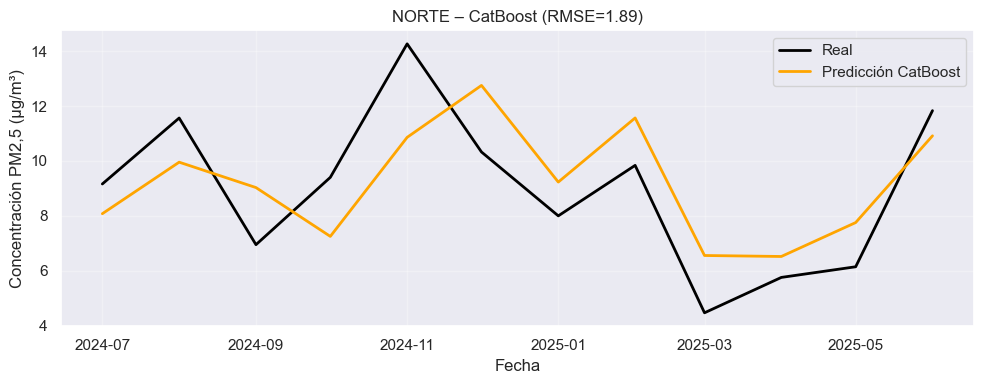

📁 Guardado gráfico: 07_Figs\07_predicciones_modelos_ML_MAG9\NORTE_CatBoost_predicciones_test.png
Entrenando modelo LightGBM ...
NORTE - LightGBM → RMSE: 2.100


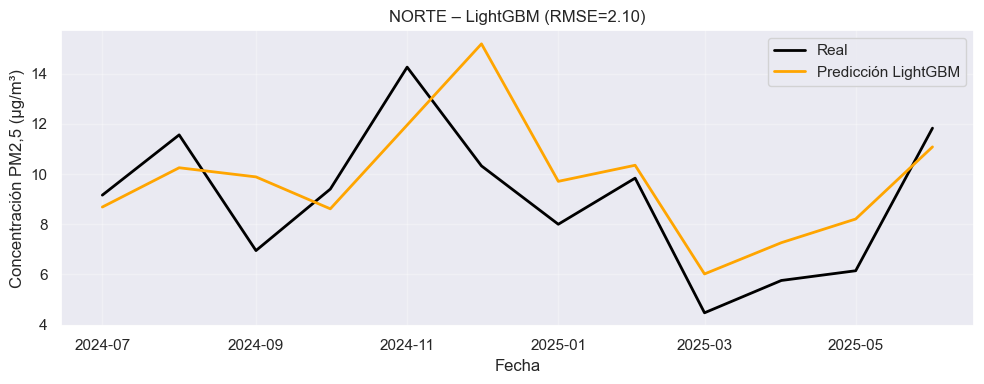

📁 Guardado gráfico: 07_Figs\07_predicciones_modelos_ML_MAG9\NORTE_LightGBM_predicciones_test.png
Entrenando modelo XGBoost ...
NORTE - XGBoost → RMSE: 2.199


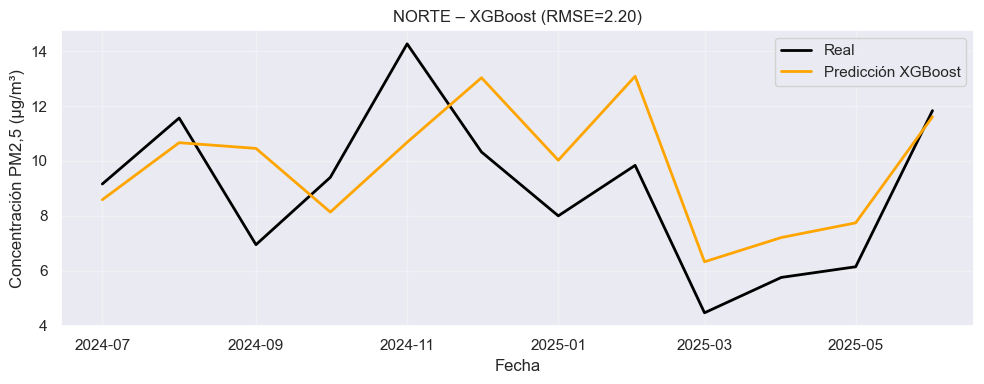

📁 Guardado gráfico: 07_Figs\07_predicciones_modelos_ML_MAG9\NORTE_XGBoost_predicciones_test.png

=== ZONA CENTRO ===
Entrenando modelo CatBoost ...
CENTRO - CatBoost → RMSE: 1.696


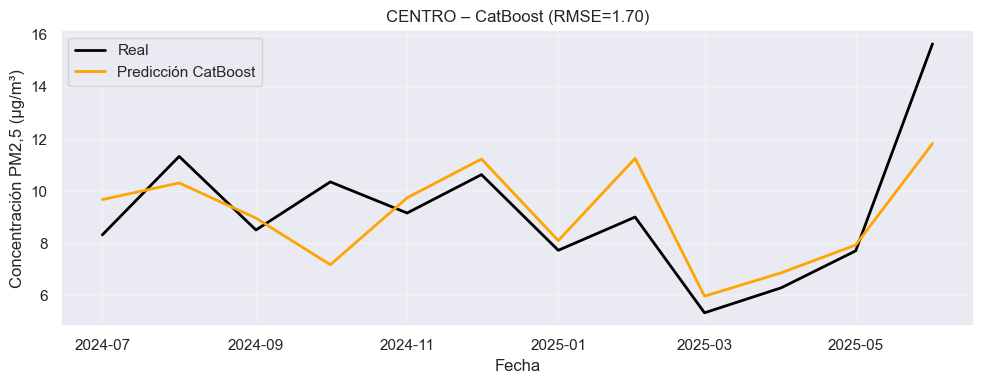

📁 Guardado gráfico: 07_Figs\07_predicciones_modelos_ML_MAG9\CENTRO_CatBoost_predicciones_test.png
Entrenando modelo LightGBM ...
CENTRO - LightGBM → RMSE: 1.587


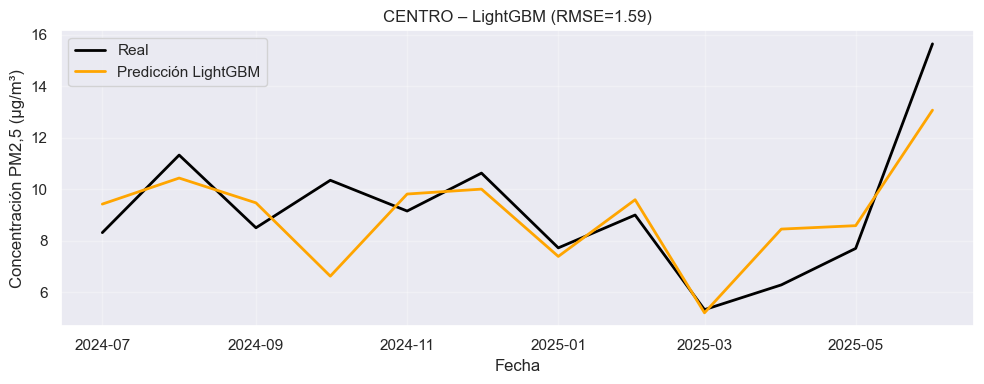

📁 Guardado gráfico: 07_Figs\07_predicciones_modelos_ML_MAG9\CENTRO_LightGBM_predicciones_test.png
Entrenando modelo XGBoost ...
CENTRO - XGBoost → RMSE: 1.724


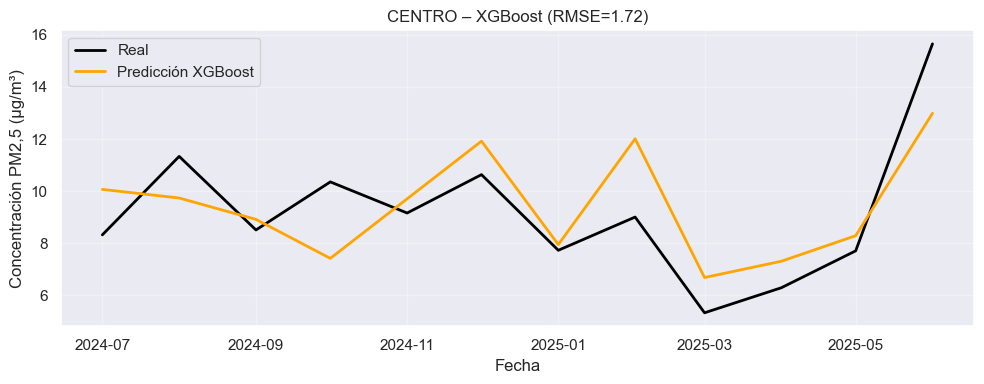

📁 Guardado gráfico: 07_Figs\07_predicciones_modelos_ML_MAG9\CENTRO_XGBoost_predicciones_test.png

=== ZONA SUR ===
Entrenando modelo CatBoost ...
SUR - CatBoost → RMSE: 2.188


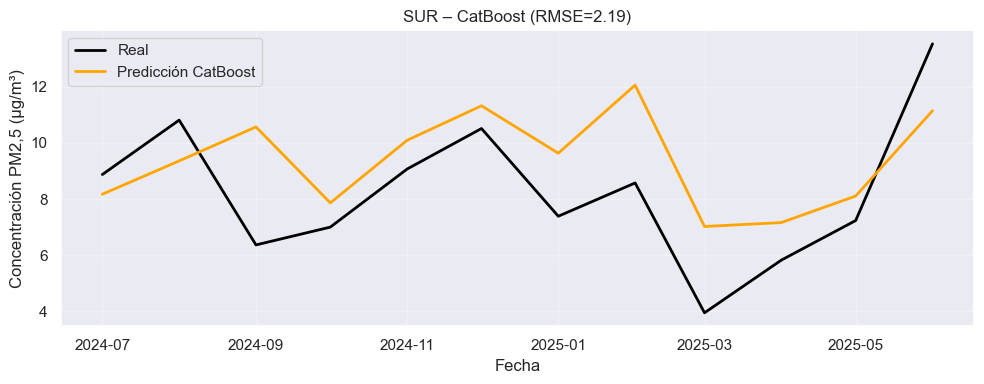

📁 Guardado gráfico: 07_Figs\07_predicciones_modelos_ML_MAG9\SUR_CatBoost_predicciones_test.png
Entrenando modelo LightGBM ...
SUR - LightGBM → RMSE: 2.072


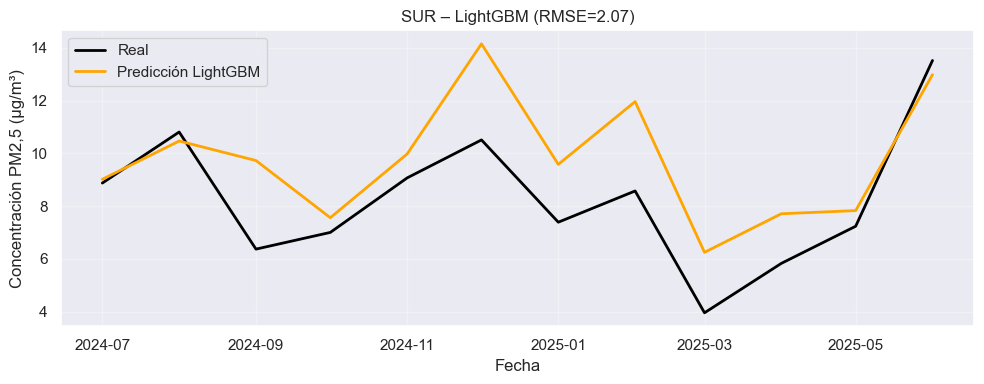

📁 Guardado gráfico: 07_Figs\07_predicciones_modelos_ML_MAG9\SUR_LightGBM_predicciones_test.png
Entrenando modelo XGBoost ...
SUR - XGBoost → RMSE: 2.608


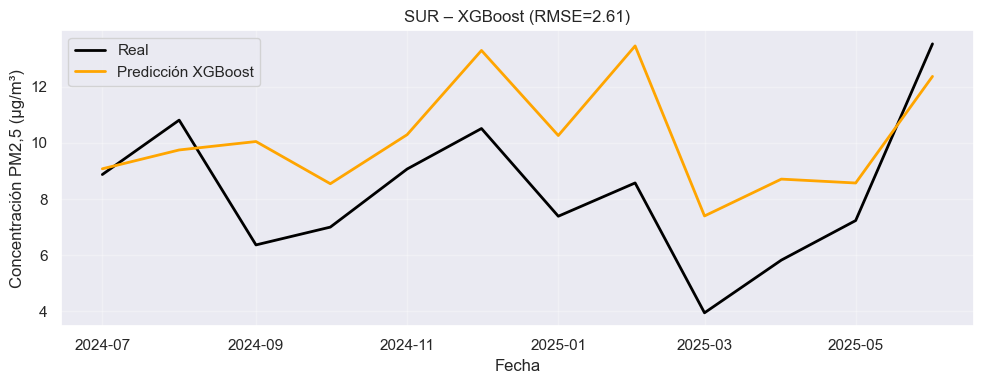

📁 Guardado gráfico: 07_Figs\07_predicciones_modelos_ML_MAG9\SUR_XGBoost_predicciones_test.png

>>> RESULTADOS COMPARATIVOS (RMSE test) <<<
  Zona   Modelo  RMSE_test  n_train  n_test
CENTRO LightGBM      1.587      162      12
CENTRO CatBoost      1.696      162      12
CENTRO  XGBoost      1.724      162      12
 NORTE CatBoost      1.895      162      12
 NORTE LightGBM      2.100      162      12
 NORTE  XGBoost      2.199      162      12
   SUR LightGBM      2.072      162      12
   SUR CatBoost      2.188      162      12
   SUR  XGBoost      2.608      162      12

📁 Guardado CSV resumen: 07_Figs\07_predicciones_modelos_ML_MAG9\RMSE_modelos_ML_comparativa.csv


In [67]:
# ------------------------------------------------------------
# Carpeta de salida
# ------------------------------------------------------------
CARPETA_BASE = "07_Figs"
SUBCARPETA = "07_predicciones_modelos_ML_MAG9"
CARPETA_SALIDA = os.path.join(CARPETA_BASE, SUBCARPETA)
os.makedirs(CARPETA_SALIDA, exist_ok=True)

# ------------------------------------------------------------
# Configuración de los modelos
# ------------------------------------------------------------
MODELOS = {
    "CatBoost": CatBoostRegressor(
        iterations=1000,
        learning_rate=0.05,
        depth=6,
        loss_function="RMSE",
        verbose=False,          # ← SILENCIA CatBoost
        random_state=42
    ),
    "LightGBM": LGBMRegressor(
        n_estimators=1000,
        learning_rate=0.05,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        verbose=-1              # ← SILENCIA LightGBM
    ),
    "XGBoost": XGBRegressor(
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        random_state=42,
        verbosity=0             # ← SILENCIA XGBoost
    )
}

# ------------------------------------------------------------
# Entrenar y evaluar para cada zona
# ------------------------------------------------------------

resultados_ml = []
predicciones_ml = {}

for zona in ["NORTE", "CENTRO", "SUR"]:
    print(f"\n=== ZONA {zona} ===")
    
    X_train = Xtr_zona[zona]
    y_train = ytr_zona[zona]
    X_test  = Xte_zona[zona]
    y_test  = yte_zona[zona]

    predicciones_ml[zona] = {}

    for nombre, modelo in MODELOS.items():
        print(f"Entrenando modelo {nombre} ...")

        # Entrenamiento
        modelo.fit(X_train, y_train)

        # Predicción sobre test
        y_pred = modelo.predict(X_test)
        
        # Evaluación usando tu función
        rmse_val = evaluar_modelo(f"{zona} - {nombre}", y_test, y_pred)

        # Guardar resultados
        resultados_ml.append({
            "Zona": zona,
            "Modelo": nombre,
            "RMSE_test": round(rmse_val, 3),
            "n_train": len(X_train),
            "n_test": len(X_test)
        })

        # Guardar predicciones para análisis o gráfico posterior
        df_pred = pd.DataFrame({
            "real": y_test.values,
            "pred": y_pred
        }, index=y_test.index)
        predicciones_ml[zona][nombre] = df_pred

        # Gráfico comparativo
        plt.figure(figsize=(10,4))
        plt.plot(y_test.index, y_test, label="Real", color="black", linewidth=2)
        plt.plot(y_test.index, y_pred, label=f"Predicción {nombre}", color="orange", linewidth=2)
        plt.title(f"{zona} – {nombre} (RMSE={rmse_val:.2f})")
        plt.xlabel("Fecha")
        plt.ylabel("Concentración PM2,5 (µg/m³)")
        plt.legend()
        plt.grid(alpha=0.3)
        plt.tight_layout()

        ruta_fig = os.path.join(CARPETA_SALIDA, f"{zona}_{nombre}_predicciones_test.png")
        plt.savefig(ruta_fig, dpi=150)
        plt.show()
        plt.close()

        print(f"📁 Guardado gráfico: {ruta_fig}")

# ------------------------------------------------------------
# Crear tabla resumen
# ------------------------------------------------------------
df_resultados_ml = pd.DataFrame(resultados_ml)
df_resultados_ml = df_resultados_ml.sort_values(["Zona", "RMSE_test"]).reset_index(drop=True)

print("\n>>> RESULTADOS COMPARATIVOS (RMSE test) <<<")
print(df_resultados_ml.to_string(index=False))

# ------------------------------------------------------------
# Guardar CSV resumen
# ------------------------------------------------------------
csv_resultados = os.path.join(CARPETA_SALIDA, "RMSE_modelos_ML_comparativa.csv")
df_resultados_ml.to_csv(csv_resultados, index=False)
print(f"\n📁 Guardado CSV resumen: {csv_resultados}")

Guardamos los resultados de los RMSE en la tabla resumen:

In [68]:
# Renombramos columnas de df_resultados_ml para que encajen con df_rmse
df_resultados_ml = df_resultados_ml.rename(
    columns={"Zona": "zona", "Modelo": "modelo"}
)[["modelo", "zona", "RMSE_test"]]

#### 4) PREDICCIÓN HASTA 2032. EVALUACIÓN PREDICCIÓN 2030

##### 4.1. MEJOR MODELO POR ZONA

Guardamos modelos ya entrenados

In [69]:
modelos_entrenados = {  # zona -> {modelo_nombre -> objeto_modelo_entrenado}
    "NORTE": {},
    "CENTRO": {},
    "SUR": {}
}

for zona in ["NORTE", "CENTRO", "SUR"]:
    ...
    for nombre, modelo in MODELOS.items():
        ...
        modelo.fit(X_train, y_train)

        # Guardar el modelo entrenado
        modelos_entrenados[zona][nombre] = modelo

Se elije el mejor modelo en función del valor de los RMSE calculados

In [70]:
mejores_modelos_ml = (
    df_resultados_ml
    .sort_values(["zona", "RMSE_test"])
    .groupby("zona")
    .first()
    .reset_index()
)

print("\n>>> MEJOR MODELO POR ZONA (según RMSE_test) <<<")
print(mejores_modelos_ml.to_string(index=False))


>>> MEJOR MODELO POR ZONA (según RMSE_test) <<<
  zona   modelo  RMSE_test
CENTRO LightGBM      1.587
 NORTE CatBoost      1.895
   SUR LightGBM      2.072


In [71]:
mejor_modelo_por_zona = {}
mejor_modelo_nombre = {}

for zona in df_resultados_ml["zona"].unique():
    fila_best = (
        df_resultados_ml[df_resultados_ml["zona"] == zona]
        .sort_values("RMSE_test")
        .iloc[0]
    )
    nombre_mejor = fila_best["modelo"]
    mejor_modelo_nombre[zona] = nombre_mejor
    mejor_modelo_por_zona[zona] = modelos_entrenados[zona][nombre_mejor]

print("\n>>> MEJOR MODELO POR ZONA (según RMSE_test) <<<")
for zona in mejor_modelo_por_zona:
    modelo = mejor_modelo_nombre[zona]
    print(f"🟢 {zona:<8} → {modelo}")


>>> MEJOR MODELO POR ZONA (según RMSE_test) <<<
🟢 CENTRO   → LightGBM
🟢 NORTE    → CatBoost
🟢 SUR      → LightGBM


##### 4.2. FORECAST ITERATIVO HASTA 2032

Dado que no se dispone de proyecciones mensuales de variables meteorológicas hasta 2032, se optó por mantener el componente exógeno del modelo ML mediante la climatología media mensual histórica. Es decir, para cada variable exógena se calculó la media de todos los valores observados para cada mes (enero–diciembre) y se usó esa media como valores para las condiciones típicas del mes en el horizonte de predicción


=== FORECAST ML HASTA 2032 PARA NORTE ===


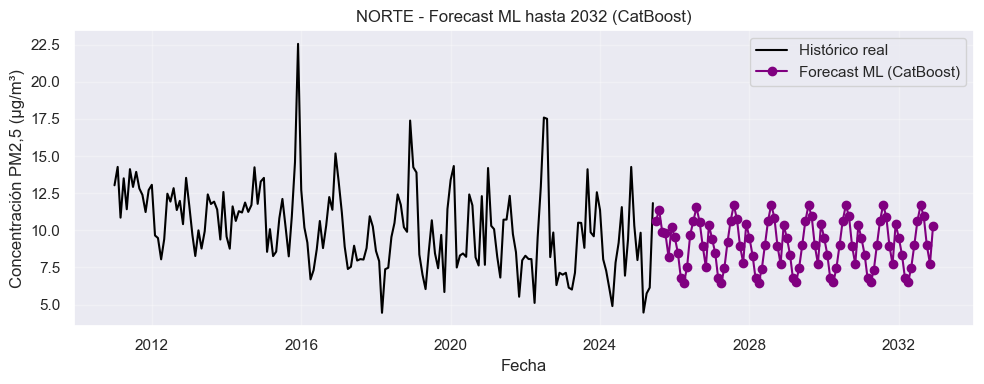

📁 Guardado gráfico forecast: 07_Figs\07_predicciones_modelos_ML_MAG9\NORTE_forecast_ML_hasta_2032_CatBoost.png

=== FORECAST ML HASTA 2032 PARA CENTRO ===


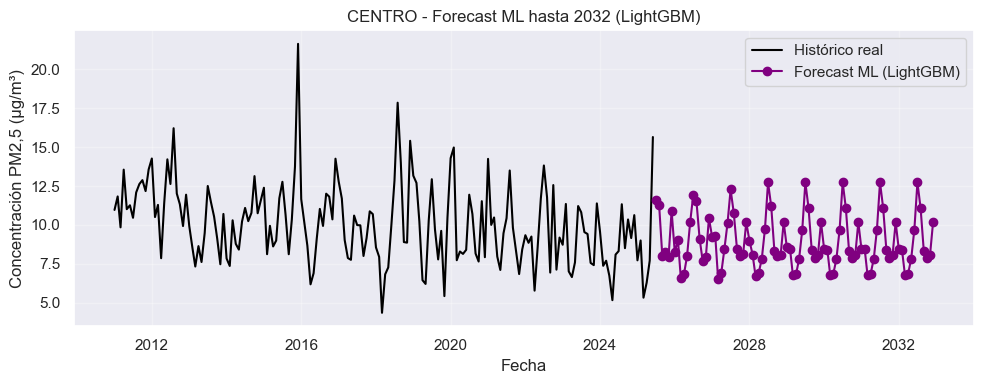

📁 Guardado gráfico forecast: 07_Figs\07_predicciones_modelos_ML_MAG9\CENTRO_forecast_ML_hasta_2032_LightGBM.png

=== FORECAST ML HASTA 2032 PARA SUR ===


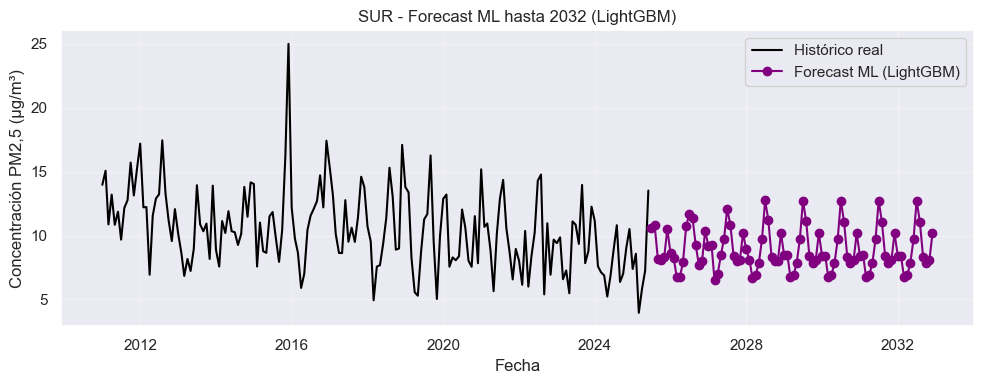

📁 Guardado gráfico forecast: 07_Figs\07_predicciones_modelos_ML_MAG9\SUR_forecast_ML_hasta_2032_LightGBM.png

>>> PROMEDIOS ANUALES PREVISTOS 2030 (MODELOS ML) <<<
  modelo   zona  promedio_anual_2030
CatBoost  NORTE                8.994
LightGBM CENTRO                8.861
LightGBM    SUR                8.861


In [72]:
# ============================================================
# FORECAST ML HASTA 2032 (USANDO MODELO GANADOR POR ZONA)
# Y PROMEDIOS ANUALES 2030
# ============================================================

# Lista de columnas exógenas que se usaron en el entrenamiento ML
columnas_exogenas_para_ML = [
"VIENTO_MAX_10 (km/h)", "VIENTO_MIN_10 (km/h)", "VIENTO_MED_10 (km/h)", "VIENTO_MAX_100 (km/h)", "VIENTO_MIN_100 (km/h)", "VIENTO_MED_100 (km/h)", "PRESION_MAX (hPa)", "PRESION_MIN (hPa)", "PRESION_MED (hPa)", "Superficie_incendiada_HA"
]

predicciones_futuras_ml = {}
promedios_2030_ml = []

for zona in ["NORTE", "CENTRO", "SUR"]:
    print(f"\n=== FORECAST ML HASTA 2032 PARA {zona} ===")

    # 1. Recuperar el mejor modelo ya entrenado para esta zona
    mejor_modelo = mejor_modelo_por_zona[zona]
    nombre_mejor_modelo = mejor_modelo_nombre[zona]

    # 2. Histórico ML de la zona (devuelto por preparar_datos_ml)
    #    Este df_ml_zona[zona] debe tener índice datetime mensual
    #    y columnas: target, mes, anio, t_index, lags, rollings, exógenas...
    df_hist = df_ml_zona[zona].copy().sort_index()

    # 3. Columnas de entrada exactas esperadas por el modelo
    #    (el orden tiene que ser idéntico al entrenamiento)
    feature_cols = Xtr_zona[zona].columns.tolist()

    # 4. Forecast iterativo hasta dic 2032 usando climatología mensual de exógenas
    df_forecast = forecast_autoregresivo_hasta_2032(
        df_ml_hist=df_hist,
        modelo_entrenado=mejor_modelo,
        feature_cols=feature_cols,
        fecha_fin_forecast="2032-12-31",
        lags=[1,2,3,12],
        usar_columnas_exogenas=columnas_exogenas_para_ML
    )

    # Guardamos predicción larga para esa zona
    predicciones_futuras_ml[zona] = {
        "modelo": nombre_mejor_modelo,
        "forecast": df_forecast
    }

    # 5. Calcular el promedio del año 2030 para esa zona
    df_2030 = df_forecast[df_forecast.index.year == 2030]
    promedio_2030 = df_2030["pred"].mean()

    promedios_2030_ml.append({
        "modelo": nombre_mejor_modelo,
        "zona": zona,
        "promedio_anual_2030": promedio_2030
    })

    # 6. Graficar histórico + predicción futura
    plt.figure(figsize=(10,4))
    plt.plot(df_hist.index, df_hist["target"], color="black", linewidth=1.5, label="Histórico real")
    plt.plot(df_forecast.index, df_forecast["pred"], color="purple", marker="o",
             linewidth=1.5, label=f"Forecast ML ({nombre_mejor_modelo})")

    plt.title(f"{zona} - Forecast ML hasta 2032 ({nombre_mejor_modelo})")
    plt.xlabel("Fecha")
    plt.ylabel("Concentración PM2,5 (µg/m³)")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()

    ruta_fig_forecast = os.path.join(
        CARPETA_SALIDA,
        f"{zona}_forecast_ML_hasta_2032_{nombre_mejor_modelo}.png"
    )
    plt.savefig(ruta_fig_forecast, dpi=150)
    plt.show()
    plt.close()

    print(f"📁 Guardado gráfico forecast: {ruta_fig_forecast}")

# ------------------------------------------------------------
# Convertimos la lista de promedios a DataFrame limpio
# ------------------------------------------------------------
df_promedios_2030_ml = pd.DataFrame(promedios_2030_ml)
df_promedios_2030_ml["promedio_anual_2030"] = df_promedios_2030_ml["promedio_anual_2030"].round(3)

print("\n>>> PROMEDIOS ANUALES PREVISTOS 2030 (MODELOS ML) <<<")
print(df_promedios_2030_ml.to_string(index=False))


### MODELOS DEEP LEARNING (LSTM y CNN)

Ahora vamos a entrenar dos arquitecturas por zona con modelos depp learning:

- LSTM (red recurrente que captura dependencias temporales largas)
- CNN1D causal (convoluciones sobre la serie temporal que detectan patrones locales/estacionales)
  * 1D = Unidimensional: los datos tienen una sola dimensión relevante para el modelo. En series temporales, esta dimensión es el tiempo.

1. Vamos a usar las mismas variables tabulares que ya tenemos de los modelos ML (lags, rolling, mes, exógenas climatológicas…), pero ahora tenemos que transformarlas en secuencias.
2. Evaluamos en el mismo conjunto test temporal (corte 2024-06-30).
3. Metemos sus RMSE en la tabla de comparación.
4. Preparamos (después) el forecast autoregresivo hasta 2032 con el mejor modelo por zona igual que hicimos con ML.
5. Metemos la predicción de 2030 en la tabls de comparación.

####  1) PREPARAR DATOS SECUENCIALES 

In [73]:
columnas_input_dl = [
    "target",
    "mes", "t_index",
    "roll3_mean", "roll6_mean", "roll12_mean",
    "VIENTO_MAX_10 (km/h)", "VIENTO_MIN_10 (km/h)", "VIENTO_MED_10 (km/h)", "VIENTO_MAX_100 (km/h)", "VIENTO_MIN_100 (km/h)", "VIENTO_MED_100 (km/h)", "PRESION_MAX (hPa)", "PRESION_MIN (hPa)", "PRESION_MED (hPa)", "Superficie_incendiada_HA"
]

In [74]:
CARPETA_BASE = "07_Figs"
SUBCARPETA = "08_deep_learning_MAG9"
CARPETA_SALIDA = os.path.join(CARPETA_BASE, SUBCARPETA)
os.makedirs(CARPETA_SALIDA, exist_ok=True)

####  2) ENTRENAR LSTM Y CNN1D PARA CADA ZONA

Tras una primera ejecución del modelo, observo un claro sobreajuste, por lo qur trato de mitigarlo:

**2.1. Añado EaarlyStopping:** Permite que el modelo se pare cuando deja de mejorar en validación.

**2.2. Añado Dropout en la LSTM:** El Dropout apaga aleatoriamente neuronas durante el entrenamiento para obligar al modelo a generalizar.

**2.3. Simplifico la CNN1D:** Le quito filtros a las distintas capas


=== ZONA NORTE (Deep Learning) ===
DL | Corte 2024-06-30 | train=150 muestras | test=12 muestras
   Shapes -> X_train (150, 12, 17), y_train (150,), X_test (12, 12, 17), y_test (12,)
LSTM shapes: y_test_dl (12,), y_pred_lstm (12,)
LSTM NORTE → RMSE: 2.776
CNN1D shapes: y_test_dl (12,), y_pred_cnn (12,)
CNN1D NORTE → RMSE: 2.718


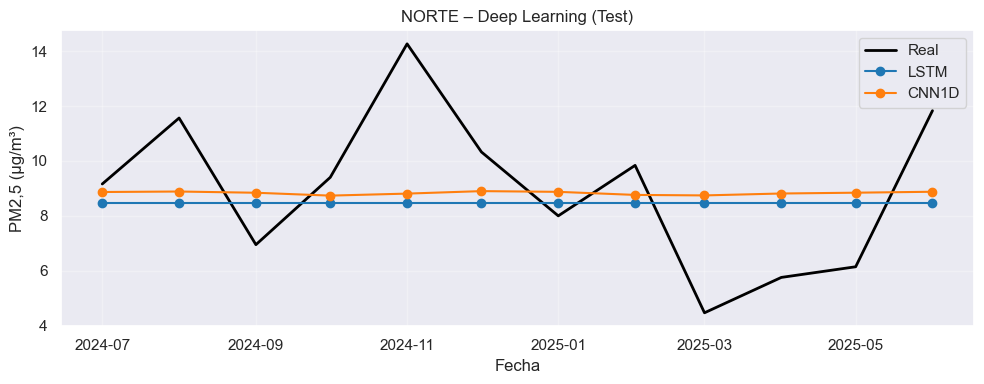

📁 Guardado gráfico: 07_Figs\08_deep_learning_MAG9\NORTE_DL_test_comparacion.png

=== ZONA CENTRO (Deep Learning) ===
DL | Corte 2024-06-30 | train=150 muestras | test=12 muestras
   Shapes -> X_train (150, 12, 17), y_train (150,), X_test (12, 12, 17), y_test (12,)
LSTM shapes: y_test_dl (12,), y_pred_lstm (12,)
LSTM CENTRO → RMSE: 2.670
CNN1D shapes: y_test_dl (12,), y_pred_cnn (12,)
CNN1D CENTRO → RMSE: 9.413


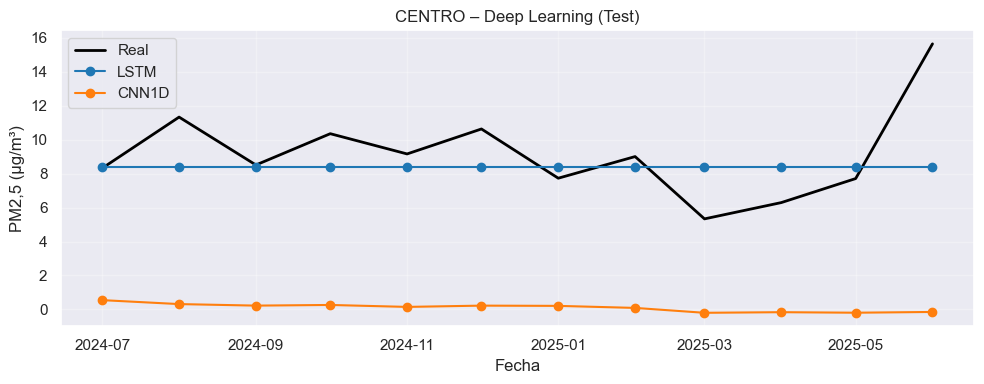

📁 Guardado gráfico: 07_Figs\08_deep_learning_MAG9\CENTRO_DL_test_comparacion.png

=== ZONA SUR (Deep Learning) ===
DL | Corte 2024-06-30 | train=150 muestras | test=12 muestras
   Shapes -> X_train (150, 12, 17), y_train (150,), X_test (12, 12, 17), y_test (12,)
LSTM shapes: y_test_dl (12,), y_pred_lstm (12,)
LSTM SUR → RMSE: 7.478
CNN1D shapes: y_test_dl (12,), y_pred_cnn (12,)
CNN1D SUR → RMSE: 6.118


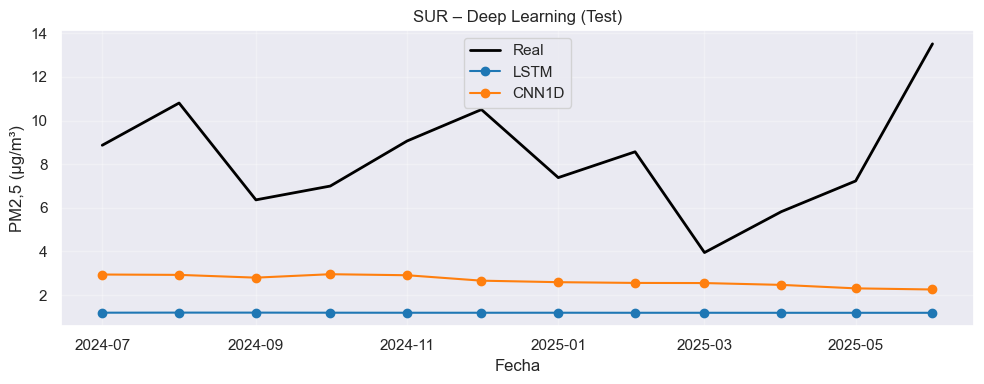

📁 Guardado gráfico: 07_Figs\08_deep_learning_MAG9\SUR_DL_test_comparacion.png

>>> RESULTADOS DEEP LEARNING (RMSE en test) <<<
  zona modelo  RMSE_test  n_train  n_test
 NORTE   LSTM      2.776      150      12
 NORTE  CNN1D      2.718      150      12
CENTRO   LSTM      2.670      150      12
CENTRO  CNN1D      9.413      150      12
   SUR   LSTM      7.478      150      12
   SUR  CNN1D      6.118      150      12


In [75]:
# Semilla global reproducible
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

callback_es = EarlyStopping(
    monitor="val_loss",
    patience=15,
    restore_best_weights=True
)

resultados_dl = []
predicciones_dl_test = {}
modelos_dl_entrenados = {"NORTE": {}, "CENTRO": {}, "SUR": {}}

for zona in ["NORTE", "CENTRO", "SUR"]:
    print(f"\n=== ZONA {zona} (Deep Learning) ===")

    df_ml = df_ml_zona[zona].copy().sort_index()
    cols_presentes = [c for c in columnas_input_dl if c in df_ml.columns]

    X_train_dl, y_train_dl, X_test_dl, y_test_dl, fechas_test_dl = construir_secuencias_dl(
        df_ml,
        fecha_corte="2024-06-30",
        window_size=12,
        columnas_input=cols_presentes,
        columna_objetivo="target"
    )

    n_steps  = X_train_dl.shape[1]
    n_feats  = X_train_dl.shape[2]

    # split interno train/val cronológico
    X_sub, y_sub, X_val, y_val = split_train_val(X_train_dl, y_train_dl, val_ratio=0.15)

    # --------- LSTM ---------
    lstm_model = build_lstm_model(n_steps, n_feats)
    lstm_model.fit(
        X_sub, y_sub,
        validation_data=(X_val, y_val),
        epochs=400,
        batch_size=12,
        verbose=0,
        callbacks=[callback_es]
    )

    y_pred_lstm = lstm_model.predict(X_test_dl, verbose=0).flatten()
    print(f"LSTM shapes: y_test_dl {y_test_dl.shape}, y_pred_lstm {y_pred_lstm.shape}")
    rmse_lstm = evaluar_modelo(f"LSTM {zona}", y_test_dl, y_pred_lstm)

    resultados_dl.append({
        "zona": zona,
        "modelo": "LSTM",
        "RMSE_test": rmse_lstm,
        "n_train": X_train_dl.shape[0],
        "n_test": X_test_dl.shape[0]
    })

    predicciones_dl_test[(zona, "LSTM")] = pd.DataFrame({
        "real": y_test_dl,
        "pred": y_pred_lstm
    }, index=fechas_test_dl)

    modelos_dl_entrenados[zona]["LSTM"] = {
        "model": lstm_model,
        "cols_input": cols_presentes,
        "window_size": 12
    }

    # --------- CNN1D ---------
    cnn_model = build_cnn1d_model(n_steps, n_feats)
    cnn_model.fit(
        X_sub, y_sub,
        validation_data=(X_val, y_val),
        epochs=400,
        batch_size=8,
        verbose=0,
        callbacks=[callback_es]
    )

    y_pred_cnn = cnn_model.predict(X_test_dl, verbose=0).flatten()
    print(f"CNN1D shapes: y_test_dl {y_test_dl.shape}, y_pred_cnn {y_pred_cnn.shape}")
    rmse_cnn = evaluar_modelo(f"CNN1D {zona}", y_test_dl, y_pred_cnn)

    resultados_dl.append({
        "zona": zona,
        "modelo": "CNN1D",
        "RMSE_test": rmse_cnn,
        "n_train": X_train_dl.shape[0],
        "n_test": X_test_dl.shape[0]
    })

    predicciones_dl_test[(zona, "CNN1D")] = pd.DataFrame({
        "real": y_test_dl,
        "pred": y_pred_cnn
    }, index=fechas_test_dl)

    modelos_dl_entrenados[zona]["CNN1D"] = {
        "model": cnn_model,
        "cols_input": cols_presentes,
        "window_size": 12
    }

    # --------- gráfico y guardado ---------
    plt.figure(figsize=(10,4))
    plt.plot(fechas_test_dl, y_test_dl, color="black", linewidth=2, label="Real")
    plt.plot(fechas_test_dl, y_pred_lstm, color="tab:blue", marker="o", label="LSTM")
    plt.plot(fechas_test_dl, y_pred_cnn, color="tab:orange", marker="o", label="CNN1D")
    plt.title(f"{zona} – Deep Learning (Test)")
    plt.ylabel("PM2,5 (µg/m³)")
    plt.xlabel("Fecha")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()

    ruta_png = os.path.join(CARPETA_SALIDA, f"{zona}_DL_test_comparacion.png")
    plt.savefig(ruta_png, dpi=150)
    plt.show()
    plt.close()

    print(f"📁 Guardado gráfico: {ruta_png}")

# resumen final
df_resultados_dl = pd.DataFrame(resultados_dl)
print("\n>>> RESULTADOS DEEP LEARNING (RMSE en test) <<<")
print(df_resultados_dl.round(3).to_string(index=False))

In [76]:
df_resultados_dl_std = df_resultados_dl.rename(
    columns={"modelo": "modelo", "zona": "zona", "RMSE_test": "RMSE_test"}
)[["modelo", "zona", "RMSE_test", "n_train", "n_test"]]

####  3) PREDICCIÓN HASTA 2032. EVALUACIÓN PREDICCIÓN 2030

In [77]:
for zona in ["NORTE", "CENTRO", "SUR"]:
    df_ml_zona[zona].columns = [c.strip() for c in df_ml_zona[zona].columns]
    df_ml_zona[zona] = df_ml_zona[zona][~df_ml_zona[zona].index.duplicated(keep="first")]
    df_ml_zona[zona].sort_index(inplace=True)


=== FORECAST DL HASTA 2032 PARA NORTE ===
   ➤ Mejor modelo DL en NORTE: CNN1D
   📁 Guardado forecast CSV: 07_Figs\08_deep_learning_MAG9\forecast_DL_NORTE_CNN1D_hasta_2032.csv


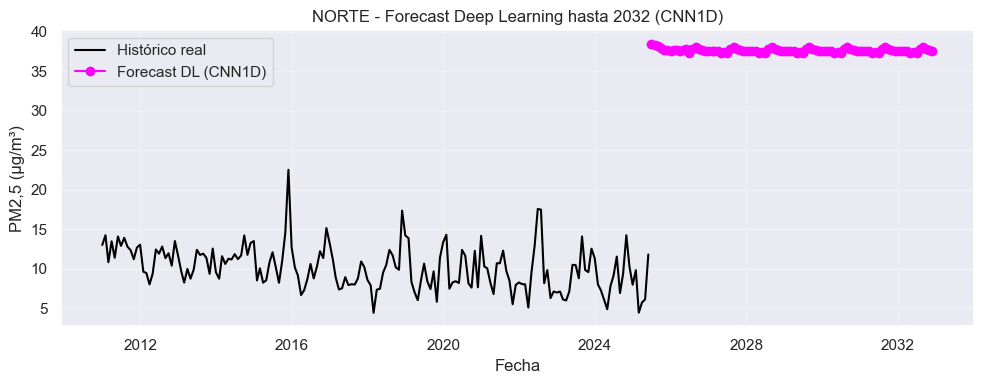

   📁 Guardado gráfico forecast: 07_Figs\08_deep_learning_MAG9\NORTE_forecast_DL_hasta_2032_CNN1D.png

=== FORECAST DL HASTA 2032 PARA CENTRO ===
   ➤ Mejor modelo DL en CENTRO: LSTM
   📁 Guardado forecast CSV: 07_Figs\08_deep_learning_MAG9\forecast_DL_CENTRO_LSTM_hasta_2032.csv


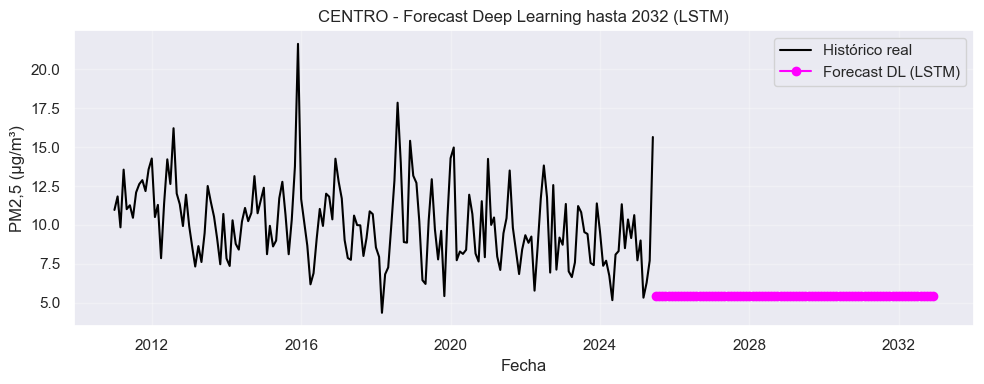

In [ ]:
promedios_2030_dl = []
predicciones_futuras_dl = {}

for zona in ["NORTE", "CENTRO", "SUR"]:
    print(f"\n=== FORECAST DL HASTA 2032 PARA {zona} ===")

    df_hist_zona = df_ml_zona[zona].copy().sort_index()

    # mejor modelo DL (menor RMSE_test)
    fila_best_dl = (
        df_resultados_dl[df_resultados_dl["zona"] == zona]
        .sort_values("RMSE_test")
        .iloc[0]
    )
    nombre_mejor_dl = fila_best_dl["modelo"]
    print(f"   ➤ Mejor modelo DL en {zona}: {nombre_mejor_dl}")

    info_mejor = modelos_dl_entrenados[zona][nombre_mejor_dl]
    modelo_dl         = info_mejor["model"]
    cols_input_mejor  = info_mejor["cols_input"]      # lista original de entrenamiento (19 cols)
    window_size_mejor = info_mejor["window_size"]     # 12

    df_forecast_dl = forecast_dl_hasta_2032(
        df_ml_hist=df_hist_zona,
        modelo_dl=modelo_dl,
        columnas_input_entrenamiento=cols_input_mejor,
        window_size=window_size_mejor,
        fecha_fin_forecast="2032-12-31"
    )

    predicciones_futuras_dl[zona] = {
        "modelo": nombre_mejor_dl,
        "forecast": df_forecast_dl
    }

    # promedio anual 2030
    df_2030_dl = df_forecast_dl[df_forecast_dl.index.year == 2030]
    promedio_2030_dl = df_2030_dl["pred"].mean()

    promedios_2030_dl.append({
        "modelo": nombre_mejor_dl,
        "zona": zona,
        "promedio_anual_2030": promedio_2030_dl
    })

    # guardar CSV forecast completo
    ruta_csv_forecast = os.path.join(
        CARPETA_SALIDA,
        f"forecast_DL_{zona}_{nombre_mejor_dl}_hasta_2032.csv"
    )
    df_forecast_dl.round(3).to_csv(ruta_csv_forecast)
    print(f"   📁 Guardado forecast CSV: {ruta_csv_forecast}")

    # gráfico histórico + forecast hasta 2032
    plt.figure(figsize=(10,4))
    plt.plot(df_hist_zona.index, df_hist_zona["target"], color="black", linewidth=1.5, label="Histórico real")
    plt.plot(df_forecast_dl.index, df_forecast_dl["pred"], color="magenta", marker="o",
             linewidth=1.5, label=f"Forecast DL ({nombre_mejor_dl})")
    plt.title(f"{zona} - Forecast Deep Learning hasta 2032 ({nombre_mejor_dl})")
    plt.xlabel("Fecha")
    plt.ylabel("PM2,5 (µg/m³)")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()

    ruta_png_forecast = os.path.join(
        CARPETA_SALIDA,
        f"{zona}_forecast_DL_hasta_2032_{nombre_mejor_dl}.png"
    )
    plt.savefig(ruta_png_forecast, dpi=150)
    plt.show()
    plt.close()

    print(f"   📁 Guardado gráfico forecast: {ruta_png_forecast}")

# resumen comparativo 2030 (DL)
df_promedios_2030_dl = pd.DataFrame(promedios_2030_dl)
df_promedios_2030_dl["promedio_anual_2030"] = df_promedios_2030_dl["promedio_anual_2030"].round(3)

print("\n>>> PROMEDIOS ANUALES PREVISTOS 2030 (Deep Learning - mejor modelo por zona) <<<")
print(df_promedios_2030_dl.to_string(index=False))


### CUADRO COMPARATIVA MODELOS I

In [ ]:
# ==========================================================
# 1️⃣ Convertir listas a DataFrames
# ==========================================================
df_rmse = pd.DataFrame(tabla_rmse_modelos)
df_pred_2030 = pd.DataFrame(tabla_predicciones_2030)

# Unir RMSEs de ARIMA/SARIMA + ML + deep learning
df_rmse = pd.concat([df_rmse, df_resultados_ml], ignore_index=True)
df_rmse = pd.concat(
    [df_rmse, df_resultados_dl_std],
    ignore_index=True
)

# Unir predicción 2030 de ARIMA/SARIMA + ML + deep learning
df_pred_2030 = pd.concat([df_pred_2030, df_promedios_2030_ml], ignore_index=True)
df_pred_2030 = pd.concat([df_pred_2030, df_promedios_2030_dl], ignore_index=True)

# ==========================================================
# 2️⃣ Agrupar predicciones 2030 (modelo + zona)
# ==========================================================
df_pred_2030_resumen = (
    df_pred_2030
    .drop(columns=["pred_2030"], errors="ignore")       # eliminar columna de predicción individual
    .groupby(["modelo", "zona"], as_index=False)        # agrupar por modelo y zona
    .agg({"promedio_anual_2030": "mean"})               # mantener promedio
    .sort_values(by=["zona", "promedio_anual_2030"], ascending=[True, True])
)

# ==========================================================
# 3️⃣ Ordenar tabla RMSE por zona
# ==========================================================
df_rmse = (
    df_rmse
    .sort_values(by=["zona", "RMSE_test"], ascending=[True, True])
    .drop(columns=["order", "seasonal_order", "AIC","n_train", "n_test"], errors="ignore")
)

# ==========================================================
# 4️⃣ Mostrar resultados
# ==========================================================
print("\n>>> TABLA DE RMSE POR MODELO Y ZONA (ordenada) <<<")
print(df_rmse.round(3).to_string(index=False))

print("\n>>> TABLA RESUMEN DE PROMEDIOS 2030 (agrupada) <<<")
print(df_pred_2030_resumen.round(3).to_string(index=False))

# ==========================================================
# 5️⃣ Filtrar solo los modelos con menor RMSE por zona
# ==========================================================
mejores_modelos_por_zona = (
    df_rmse
    .sort_values(["zona", "RMSE_test"], ascending=[True, True])
    .groupby("zona", as_index=False)
    .first()[["zona", "modelo", "RMSE_test"]]
)

print("\n>>> MODELOS CON MENOR RMSE POR ZONA <<<")
print(mejores_modelos_por_zona.round(3).to_string(index=False))

# ==========================================================
# 6️⃣ Filtrar predicciones 2030 solo de esos modelos
# ==========================================================
df_pred_mejores_2030 = pd.merge(
    mejores_modelos_por_zona[["zona", "modelo"]],
    df_pred_2030_resumen,
    on=["zona", "modelo"],
    how="left"
)

print("\n>>> PREDICCIONES 2030 DE LOS MEJORES MODELOS (por zona) <<<")
print(df_pred_mejores_2030.round(3).to_string(index=False))


### PREDICCIÓN CONSIDERANDO EL TRÁFICO

#### PREPARACIÓN DATOS

Ahora vamos a ejecutar los siguientes modelos, pero incluyendo la variable relativa al tráfico ("TOTAL_HOR_EXT"). Dado que esta variable no contiene valores coherentes antes de 2019, friltramos el dataframe, de modo que me quede con:

- Valores posteriores a 2019.
- Instancias con MAGNITUD = 9 (PM2,5)
- Las variables interesantes de antes + "TOTAL_HOR_EXT"
- Sobre este dataframe aplicaré los modelos:
  * CatBoost para las 3 zonas.
  * Adicionalmente, LightGBM para las zonas SUR y CENTRO

In [ ]:
df_traf = pd.read_parquet("05_DATASET_FINAL.parquet")

In [ ]:
df_traf.info()

In [ ]:
df_traf.head()

In [ ]:
# 1) Fecha a datetime una sola vez
df_traf["DIA/MES/ANO"] = pd.to_datetime(df_traf["DIA/MES/ANO"], errors="coerce")
if df_traf["DIA/MES/ANO"].isna().any():
    df_traf["DIA/MES/ANO"] = pd.to_datetime(df_traf["DIA/MES/ANO"], errors="coerce", dayfirst=True)

# 2) Crear columna year
df_traf["year"] = df_traf["DIA/MES/ANO"].dt.year

# 3) Filtrar MAGNITUD = 9 y year >= 2019
df_traf_2019_pm25 = df_traf[(df_traf["MAGNITUD"] == "9") & (df_traf["year"] >= 2019)].copy()

# 4) Diccionario por zona (no sobrescribas el DataFrame)
dfs_traf_2019_pm25 = {
    zona: sub_df.copy()
    for zona, sub_df in df_traf_2019_pm25.groupby("ZONA_ESTACION")
}

# Chequeo rápido
print(len(df_traf_2019_pm25), "filas desde 2019 (PM2,5).")
print("Zonas:", list(dfs_traf_2019_pm25.keys()))



In [ ]:
df_ejemplo = dfs_traf_2019_pm25["NORTE"]
df_ejemplo.head(5)

In [ ]:
# --- Filtrado de columnas por variables de interés ---
variables_interes = [
"ZONA_ESTACION","VIENTO_MAX_10 (km/h)", "VIENTO_MIN_10 (km/h)", "VIENTO_MED_10 (km/h)", "VIENTO_MAX_100 (km/h)", "VIENTO_MIN_100 (km/h)", "VIENTO_MED_100 (km/h)", "PRESION_MAX (hPa)", "PRESION_MIN (hPa)", "PRESION_MED (hPa)", "dow", "month", "Superficie_incendiada_HA","TOTAL_HOR_EXT"
]

# Creamos un nuevo diccionario con solo las columnas seleccionadas
dfs_mag_zona_traf_sel = {
    zona: sub_df[variables_interes].copy()
    for zona, sub_df in dfs_traf_2019_pm25.items()
    if all(col in sub_df.columns for col in variables_interes)
}

# --- Resumen ---
print(f"Sub–dataframes creados: {len(dfs_mag_zona_traf_sel)}")
for zona, df_sub in dfs_mag_zona_traf_sel.items():
    print(f"{zona}: {df_sub.shape[0]} filas, {df_sub.shape[1]} columnas")


In [ ]:
df_ejemplo = dfs_mag_zona_traf_sel["NORTE"]
df_ejemplo.head(5)

In [ ]:
# 1️⃣ Preparar diccionario de dataframes (ya MAG=9, desde 2019)
dfs_traf_2019_pm25_sel = {
    z: sub[[c for c in variables_interes + ["DIA/MES/ANO", "MEDICION_ugm3"] if c in sub.columns]].copy()
    for z, sub in dfs_traf_2019_pm25.items()
}

# 2️⃣ Crear datasets ML por zona
resultados_ml = preparar_para_modelos_por_zona(
    dfs_por_zona=dfs_traf_2019_pm25_sel,
    variables_interes=variables_interes,
    fecha_corte="2024-06-30",
    lags=[1,2,3,12]
)

# NORTE
Xtr_norte = resultados_ml["NORTE"]["X_train"]
ytr_norte = resultados_ml["NORTE"]["y_train"]
Xte_norte = resultados_ml["NORTE"]["X_test"]
yte_norte = resultados_ml["NORTE"]["y_test"]

# CENTRO
Xtr_centro = resultados_ml["CENTRO"]["X_train"]
ytr_centro = resultados_ml["CENTRO"]["y_train"]
Xte_centro = resultados_ml["CENTRO"]["X_test"]
yte_centro = resultados_ml["CENTRO"]["y_test"]

# SUR
Xtr_sur = resultados_ml["SUR"]["X_train"]
ytr_sur = resultados_ml["SUR"]["y_train"]
Xte_sur = resultados_ml["SUR"]["X_test"]
yte_sur = resultados_ml["SUR"]["y_test"]

for zona, datos in resultados_ml.items():
    Xtr, ytr = datos["X_train"], datos["y_train"]
    Xte, yte = datos["X_test"], datos["y_test"]
    print(f"{zona}: {Xtr.shape} train / {Xte.shape} test")


#### ENTRENAMIENTO MODELOS

In [ ]:
cat_models_traf = {}
lgbm_models_traf = {}
resultados_rmse_traf = []

# ---------------------------
# 1) CatBoost en las 3 zonas
# ---------------------------
for zona, datos in resultados_ml.items():
    Xtr, ytr = datos["X_train"], datos["y_train"]
    Xte, yte = datos["X_test"],  datos["y_test"]

    cat = CatBoostRegressor(
        iterations=1000,
        learning_rate=0.05,
        depth=6,
        loss_function="RMSE",
        random_state=42,
        verbose=False
    )
    # early stopping opcional
    cat.fit(Xtr, ytr, eval_set=(Xte, yte), verbose=False)

    pred = cat.predict(Xte)
    rmse = evaluar_modelo(f"CatBoost_TRAF [{zona}]", yte, pred)

    cat_models_traf[zona] = cat
    resultados_rmse_traf.append({
        "modelo": "CatBoost_TRAF",
        "zona": zona,
        "RMSE_test": rmse
    })

# -----------------------------------------
# 2) LightGBM en zonas: SUR y CENTRO
# -----------------------------------------
zonas_lgbm = ["SUR", "CENTRO"]
for zona in zonas_lgbm:
    if zona not in resultados_ml:
        print(f"⚠️ Zona {zona} no disponible en resultados_ml; omito LightGBM.")
        continue

    Xtr, ytr = resultados_ml[zona]["X_train"], resultados_ml[zona]["y_train"]
    Xte, yte = resultados_ml[zona]["X_test"],  resultados_ml[zona]["y_test"]

    # Asegúrate de que todo sea numérico; si hay categóricas, one-hot antes
    assert np.issubdtype(Xtr.dtypes.values[0], np.number), "Hay variables no numéricas en X"

    lgbm = LGBMRegressor(
        n_estimators=1000,
        learning_rate=0.05,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        verbose=-1
    )
    lgbm.fit(
        Xtr, ytr,
        eval_set=[(Xte, yte)],
        eval_metric="rmse",
        callbacks=[]  # o [lightgbm.early_stopping(100)] si quieres ES
    )

    pred = lgbm.predict(Xte)
    rmse = evaluar_modelo(f"LightGBM_TRAF [{zona}]", yte, pred)

    lgbm_models_traf[zona] = lgbm
    resultados_rmse_traf.append({
        "modelo": "LightGBM_TRAF",
        "zona": zona,
        "RMSE_test": rmse
    })

# -----------------------------------------
# 3) Cuadro resumen
# -----------------------------------------
df_resultados_traf = (
    pd.DataFrame(resultados_rmse_traf)
      .sort_values(["modelo", "zona"])
      .reset_index(drop=True)
)
print("\nResumen RMSE – Modelos con variable de tráfico:\n")
print(df_resultados_traf)


#### REPRESENTACION GRÁFICA

In [ ]:
CARPETA_BASE = "07_Figs"
SUBCARPETA   = "09_predicciones_tráfico_MAG9"

graficar_modelos_traf(
    resultados_ml=resultados_ml,
    cat_models_traf=cat_models_traf,        # requerido para graficar CatBoost
    lgbm_models_traf=globals().get("lgbm_models_traf", None),  # usar si existe
    carpeta_base=CARPETA_BASE,
    subcarpeta=SUBCARPETA,
    ytick_step=5
)

#### CUADRO COMPARATIVA RSME MODELOS

In [ ]:
# ==========================================================
# 1️⃣ Convertir lista base ARIMA/SARIMA en DataFrame
# ==========================================================
df_rmse = pd.DataFrame(tabla_rmse_modelos)

# ==========================================================
# 2️⃣ Añadir resultados ML clásicos (sin tráfico)
# ==========================================================
df_rmse = pd.concat(
    [df_rmse, df_resultados_ml, df_resultados_dl_std],
    ignore_index=True
)

# ==========================================================
# 3️⃣ Añadir resultados de modelos con TRÁFICO (CatBoost_TRAF + LightGBM_TRAF)
# ==========================================================
df_rmse = pd.concat(
    [df_rmse, df_resultados_traf],
    ignore_index=True
)

# ==========================================================
# 4️⃣ Ordenar por zona y por RMSE (mejor modelo arriba en cada zona)
# ==========================================================
df_rmse = (
    df_rmse
    .sort_values(by=["zona", "RMSE_test"], ascending=[True, True])
    .drop(columns=["order", "seasonal_order", "AIC", "n_train", "n_test"], errors="ignore")
    .reset_index(drop=True)
)

# ==========================================================
# 5️⃣ Mostrar tabla final
# ==========================================================
print("\n>>> TABLA DE RMSE POR MODELO Y ZONA (ordenada) <<<\n")
print(df_rmse.round(3).to_string(index=False))


In [ ]:
FECHA_FIN_FORE = "2032-12-31"
LAGS_USADOS = [1, 2, 3, 12]

# Diccionario donde guardaremos las predicciones futuras
preds_futuras_traf = {
    "CatBoost_TRAF": {},
    "LightGBM_TRAF": {}
}

# -----------------------------------
# 1) Forecast para modelos CatBoost
# -----------------------------------
for zona, datos in resultados_ml.items():
    if zona not in cat_models_traf:
        continue  # por si alguna zona no tiene CatBoost

    # Intentamos obtener el histórico ML de forma robusta
    df_ml_hist = (
        datos.get("df_ml") 
        if isinstance(datos, dict) and "df_ml" in datos 
        else datos.get("df_ml_hist") 
        if isinstance(datos, dict) and "df_ml_hist" in datos 
        else None
    )
    if df_ml_hist is None:
        raise ValueError(f"No encuentro 'df_ml' ni 'df_ml_hist' para la zona {zona} en resultados_ml.")

    df_ml_hist = df_ml_hist.copy().sort_index()

    # Columnas EXACTAS que el modelo espera como entrada
    feature_cols = datos["X_train"].columns.tolist()

    # Columnas exógenas: todo lo que no es target, mes, anio, t_index, lags o rollings
    columnas_exogenas = [
        c for c in df_ml_hist.columns
        if c not in ["target", "mes", "anio", "t_index"]
        and not c.startswith("lag_")
        and not c.startswith("roll")
    ]

    modelo_cat = cat_models_traf[zona]

    df_fore_cat = forecast_autoregresivo_hasta_2032(
        df_ml_hist=df_ml_hist,
        modelo_entrenado=modelo_cat,
        feature_cols=feature_cols,
        fecha_fin_forecast=FECHA_FIN_FORE,
        lags=LAGS_USADOS,
        usar_columnas_exogenas=columnas_exogenas
    )

    preds_futuras_traf["CatBoost_TRAF"][zona] = df_fore_cat

# -----------------------------------
# 2) Forecast para modelos LightGBM
# -----------------------------------
for zona, modelo_lgbm in lgbm_models_traf.items():
    if zona not in resultados_ml:
        continue

    datos = resultados_ml[zona]

    df_ml_hist = (
        datos.get("df_ml") 
        if isinstance(datos, dict) and "df_ml" in datos 
        else datos.get("df_ml_hist") 
        if isinstance(datos, dict) and "df_ml_hist" in datos 
        else None
    )
    if df_ml_hist is None:
        raise ValueError(f"No encuentro 'df_ml' ni 'df_ml_hist' para la zona {zona} en resultados_ml.")

    df_ml_hist = df_ml_hist.copy().sort_index()
    feature_cols = datos["X_train"].columns.tolist()

    columnas_exogenas = [
        c for c in df_ml_hist.columns
        if c not in ["target", "mes", "anio", "t_index"]
        and not c.startswith("lag_")
        and not c.startswith("roll")
    ]

    df_fore_lgbm = forecast_autoregresivo_hasta_2032(
        df_ml_hist=df_ml_hist,
        modelo_entrenado=modelo_lgbm,
        feature_cols=feature_cols,
        fecha_fin_forecast=FECHA_FIN_FORE,
        lags=LAGS_USADOS,
        usar_columnas_exogenas=columnas_exogenas
    )

    preds_futuras_traf["LightGBM_TRAF"][zona] = df_fore_lgbm

# Chequeo rápido
for modelo_key, dic_zonas in preds_futuras_traf.items():
    for zona, df_fore in dic_zonas.items():
        print(f"{modelo_key} – {zona}: {df_fore.index.min().date()} → {df_fore.index.max().date()}, {len(df_fore)} meses")

In [ ]:
# ==========================================================
# 1️⃣ Calcular promedio anual 2030 para cada modelo y zona
# ==========================================================

promedios_2030 = []

for modelo_key, dic_zonas in preds_futuras_traf.items():
    for zona, df_fore in dic_zonas.items():

        if df_fore.empty:
            continue

        df_aux = df_fore.copy()
        df_aux.index = pd.to_datetime(df_aux.index)

        # Filtrar solo 2030
        df_2030 = df_aux[df_aux.index.year == 2030]

        if df_2030.empty:
            continue

        promedio = df_2030["pred"].mean()

        promedios_2030.append({
            "zona": zona,
            "modelo": modelo_key,
            "PM25_promedio_2030": promedio
        })

df_prom_2030 = pd.DataFrame(promedios_2030)
df_prom_2030 = df_prom_2030.sort_values(["zona", "modelo"]).reset_index(drop=True)

print("\n>>> PROMEDIOS ANUALES 2030 (pred) PARA CADA MODELO Y ZONA <<<")
print(df_prom_2030.round(3).to_string(index=False))


### CUADRO COMPARATIVA MODELOS II

In [ ]:
# Partimos de:
# df_pred_2030_resumen  -> columnas: ['modelo', 'zona', 'promedio_anual_2030']
# df_prom_2030          -> columnas: ['zona', 'modelo', 'PM25_promedio_2030']

# 1) Renombrar la columna de df_prom_2030 para que coincida
df_prom_2030_ajust = df_prom_2030.rename(
    columns={"PM25_promedio_2030": "promedio_anual_2030"}
)[["modelo", "zona", "promedio_anual_2030"]]

# 2) Concatenar ambas tablas
df_pred_2030_resumen_act = (
    pd.concat([df_pred_2030_resumen, df_prom_2030_ajust], ignore_index=True)
      .sort_values(["zona", "modelo"])
      .drop_duplicates(subset=["zona", "modelo"], keep="last")
      .reset_index(drop=True)
)

print("\n>>> TABLA RESUMEN DE PROMEDIOS 2030 (agrupada) – ACTUALIZADA <<<")
print(df_pred_2030_resumen_act.round(3).to_string(index=False))



In [ ]:
df_pred_2030_resumen.head()

In [ ]:
df_pred_2030_resumen.columns

In [ ]:
# ==========================================================
# 4️⃣ Mostrar resultados
# ==========================================================
print("\n>>> TABLA DE RMSE POR MODELO Y ZONA (ordenada) <<<")
print(df_rmse.round(3).to_string(index=False))

print("\n>>> TABLA RESUMEN DE PROMEDIOS 2030 (agrupada, ACTUALIZADA) <<<")
print(df_pred_2030_resumen_act.round(3).to_string(index=False))

# ==========================================================
# 5️⃣ Filtrar solo los modelos con menor RMSE por zona
# ==========================================================
mejores_modelos_por_zona = (
    df_rmse
    .sort_values(["zona", "RMSE_test"], ascending=[True, True])
    .groupby("zona", as_index=False)
    .first()[["zona", "modelo", "RMSE_test"]]
)

print("\n>>> MODELOS CON MENOR RMSE POR ZONA <<<")
print(mejores_modelos_por_zona.round(3).to_string(index=False))

# ==========================================================
# 6️⃣ Filtrar predicciones 2030 solo de esos modelos
#     usando la tabla ACTUALIZADA
# ==========================================================
df_pred_mejores_2030 = pd.merge(
    mejores_modelos_por_zona[["zona", "modelo"]],
    df_pred_2030_resumen_act,
    on=["zona", "modelo"],
    how="left"
)

print("\n>>> PREDICCIONES 2030 DE LOS MEJORES MODELOS (por zona) <<<")
print(df_pred_mejores_2030.round(3).to_string(index=False))


## PREDICCIONES MEJORES RESULTADOS

In [ ]:
# ==========================================================
# 0️⃣ CONFIGURACIÓN INICIAL
# ==========================================================
CARPETA_BASE = "07_Figs"
SUBCARPETA   = "10_MEJORES PREDICCIONES_MAG9"
CARPETA_SALIDA = os.path.join(CARPETA_BASE, SUBCARPETA)
os.makedirs(CARPETA_SALIDA, exist_ok=True)

# ==========================================================
# 1️⃣ PARAMETROS GLOBALES
# ==========================================================
FECHA_FIN_FORE  = "2032-12-31"
FECHA_MIN_FULL  = "2010-01-01"
FECHA_MIN_TRAF  = "2019-01-01"
FECHA_MAX_TODOS = "2032-12-31"
LAGS_USADOS     = [1, 2, 3, 12]

# Exógenas del pipeline ML general
EXOG_FULL = [
    "VIENTO_MAX_10 (km/h)", "VIENTO_MIN_10 (km/h)", "VIENTO_MED_10 (km/h)",
    "VIENTO_MAX_100 (km/h)", "VIENTO_MIN_100 (km/h)", "VIENTO_MED_100 (km/h)",
    "PRESION_MAX (hPa)", "PRESION_MIN (hPa)", "PRESION_MED (hPa)",
    "Superficie_incendiada_HA"
]

# Exógenas del pipeline con tráfico
EXOG_TRAF = EXOG_FULL + ["TOTAL_HOR_EXT"]

# ==========================================================
# 2️⃣ COMPROBACIONES DE OBJETOS NECESARIOS
# ==========================================================
# Pipeline ML general
assert "df_mensuales" in globals(),           "Falta df_mensuales."
assert "df_ml_zona" in globals(),             "Falta df_ml_zona (por zona)."
assert "Xtr_zona" in globals(),               "Falta Xtr_zona."
assert "ytr_zona" in globals(),               "Falta ytr_zona."
assert "mejor_modelo_por_zona" in globals(),  "Falta mejor_modelo_por_zona."
assert "mejor_modelo_nombre" in globals(),    "Falta mejor_modelo_nombre."

# Pipeline tráfico
assert "dfs_traf_2019_pm25" in globals(),     "Falta dfs_traf_2019_pm25."
assert "agrupar_mensual" in globals(),        "Falta agrupar_mensual()."
assert "preparar_datos_ml" in globals(),      "Falta preparar_datos_ml()."
assert "cat_models_traf" in globals(),        "Falta cat_models_traf (CatBoost_TRAF por zona)."

# Utilidades comunes
assert "forecast_autoregresivo_hasta_2032" in globals(), "Falta forecast_autoregresivo_hasta_2032()."
assert "alinear_X_a_features" in globals(),              "Falta alinear_X_a_features()."
assert "plot_largo_por_zona_ml" in globals(),            "Falta plot_largo_por_zona_ml()."

# ==========================================================
# 3️⃣ HISTÓRICOS PARA FORECAST
#     - NORTE/CENTRO: df_ml_zona (pipeline ML general)
#     - SUR: a partir de tráfico (2019+)
# ==========================================================

# ---------- NORTE (ML general, FULL) ----------
df_ml_norte = df_ml_zona["NORTE"].copy()
# asegurar índice fecha
if not isinstance(df_ml_norte.index, pd.DatetimeIndex):
    if "DIA/MES/ANO" in df_ml_norte.columns:
        df_ml_norte["DIA/MES/ANO"] = pd.to_datetime(df_ml_norte["DIA/MES/ANO"], errors="coerce")
        df_ml_norte = df_ml_norte.set_index("DIA/MES/ANO")
    else:
        raise ValueError("df_ml_zona['NORTE'] no tiene índice fecha ni columna 'DIA/MES/ANO'.")

df_ml_norte = df_ml_norte.sort_index()
df_ml_norte_hist = df_ml_norte.loc[
    (df_ml_norte.index >= FECHA_MIN_FULL) & (df_ml_norte.index <= FECHA_MAX_TODOS)
].copy()

# ---------- CENTRO (ML general, FULL) ----------
df_ml_centro = df_ml_zona["CENTRO"].copy()
if not isinstance(df_ml_centro.index, pd.DatetimeIndex):
    if "DIA/MES/ANO" in df_ml_centro.columns:
        df_ml_centro["DIA/MES/ANO"] = pd.to_datetime(df_ml_centro["DIA/MES/ANO"], errors="coerce")
        df_ml_centro = df_ml_centro.set_index("DIA/MES/ANO")
    else:
        raise ValueError("df_ml_zona['CENTRO'] no tiene índice fecha ni columna 'DIA/MES/ANO'.")

df_ml_centro = df_ml_centro.sort_index()
df_ml_centro_hist = df_ml_centro.loc[
    (df_ml_centro.index >= FECHA_MIN_FULL) & (df_ml_centro.index <= FECHA_MAX_TODOS)
].copy()

# ---------- SUR (pipeline tráfico, MAG9) ----------
# Usamos el raw de tráfico 2019+ para construir un df_mensual y luego df_ml_sur
df_sur_traf = dfs_traf_2019_pm25["SUR"].copy()

df_sur_mensual = agrupar_mensual(df_sur_traf)
df_sur_mensual["DIA/MES/ANO"] = pd.to_datetime(
    dict(year=df_sur_mensual["year"],
         month=df_sur_mensual["month"],
         day=1)
)
df_sur_mensual = (
    df_sur_mensual
    .sort_values(["year", "month"])
    .set_index("DIA/MES/ANO")
)

# construimos df_ml_sur coherente con forecast_autoregresivo_hasta_2032
Xtr_sur_traf, ytr_sur_traf, Xte_sur_traf, yte_sur_traf, df_ml_sur = preparar_datos_ml(
    df_sur_mensual.reset_index(),
    fecha_corte="2025-06-30",
    lags=LAGS_USADOS,
    usar_columnas_exogenas=EXOG_TRAF
)

df_ml_sur = df_ml_sur.copy()
if not isinstance(df_ml_sur.index, pd.DatetimeIndex):
    if "DIA/MES/ANO" in df_ml_sur.columns:
        df_ml_sur["DIA/MES/ANO"] = pd.to_datetime(df_ml_sur["DIA/MES/ANO"], errors="coerce")
        df_ml_sur = df_ml_sur.set_index("DIA/MES/ANO")
    else:
        raise ValueError("df_ml_sur no tiene índice fecha ni columna 'DIA/MES/ANO'.")

df_ml_sur = df_ml_sur.sort_index()
df_ml_sur_hist = df_ml_sur.loc[
    (df_ml_sur.index >= FECHA_MIN_TRAF) & (df_ml_sur.index <= FECHA_MAX_TODOS)
].copy()

# ==========================================================
# 4️⃣ SELECCIÓN DE MODELOS POR ZONA
#     - NORTE: mejor modelo ML (pipeline general)
#     - CENTRO: mejor modelo ML (pipeline general)
#     - SUR: CatBoost_TRAF (pipeline tráfico)
# ==========================================================
modelo_norte  = mejor_modelo_por_zona["NORTE"]     # p.ej. CatBoost/LightGBM/XGB
modelo_centro = mejor_modelo_por_zona["CENTRO"]
modelo_sur    = cat_models_traf["SUR"]             # CatBoost_TRAF

# Columnas efectivas que cada modelo espera (orden correcto)
feat_norte  = cols_del_modelo(modelo_norte,  Xtr_zona["NORTE"])
feat_centro = cols_del_modelo(modelo_centro, Xtr_zona["CENTRO"])
feat_sur    = cols_del_modelo(modelo_sur,    Xtr_sur_traf)

# Alinear X_train a las columnas del modelo
Xtr_norte_al  = alinear_X_a_features(Xtr_zona["NORTE"],  feat_norte)
Xtr_centro_al = alinear_X_a_features(Xtr_zona["CENTRO"], feat_centro)
Xtr_sur_al    = alinear_X_a_features(Xtr_sur_traf,       feat_sur)

# ==========================================================
# 5️⃣ FORECAST AUTORREGRESIVO HASTA 2032
# ==========================================================
df_fore_norte = forecast_autoregresivo_hasta_2032(
    df_ml_hist=df_ml_norte_hist,
    modelo_entrenado=modelo_norte,
    feature_cols=feat_norte,
    fecha_fin_forecast=FECHA_FIN_FORE,
    lags=LAGS_USADOS,
    usar_columnas_exogenas=[c for c in EXOG_FULL if c in df_ml_norte_hist.columns]
)

df_fore_centro = forecast_autoregresivo_hasta_2032(
    df_ml_hist=df_ml_centro_hist,
    modelo_entrenado=modelo_centro,
    feature_cols=feat_centro,
    fecha_fin_forecast=FECHA_FIN_FORE,
    lags=LAGS_USADOS,
    usar_columnas_exogenas=[c for c in EXOG_FULL if c in df_ml_centro_hist.columns]
)

df_fore_sur = forecast_autoregresivo_hasta_2032(
    df_ml_hist=df_ml_sur_hist,
    modelo_entrenado=modelo_sur,
    feature_cols=feat_sur,
    fecha_fin_forecast=FECHA_FIN_FORE,
    lags=LAGS_USADOS,
    usar_columnas_exogenas=[c for c in EXOG_TRAF if c in df_ml_sur_hist.columns]
)

# Unificamos en un diccionario homogéneo
predicciones_futuras_ml = {
    "NORTE":  {"modelo": mejor_modelo_nombre["NORTE"],  "forecast": df_fore_norte},
    "CENTRO": {"modelo": mejor_modelo_nombre["CENTRO"], "forecast": df_fore_centro},
    "SUR":    {"modelo": "CatBoost_TRAF",               "forecast": df_fore_sur},
}

# ==========================================================
# 6️⃣ GRÁFICOS LARGOS CON IC POR ZONA
# ==========================================================
plot_largo_por_zona_ml(
    zona="NORTE",
    df_hist=df_ml_norte_hist,
    modelo_entrenado=modelo_norte,
    X_train=Xtr_norte_al,
    y_train=ytr_zona["NORTE"],
    df_forecast=df_fore_norte,
    nombre_modelo=mejor_modelo_nombre["NORTE"],
    ruta_salida_dir=CARPETA_SALIDA,
    feature_cols=feat_norte,
    mostrar=True
)

plot_largo_por_zona_ml(
    zona="CENTRO",
    df_hist=df_ml_centro_hist,
    modelo_entrenado=modelo_centro,
    X_train=Xtr_centro_al,
    y_train=ytr_zona["CENTRO"],
    df_forecast=df_fore_centro,
    nombre_modelo=mejor_modelo_nombre["CENTRO"],
    ruta_salida_dir=CARPETA_SALIDA,
    feature_cols=feat_centro,
    mostrar=True
)

plot_largo_por_zona_ml(
    zona="SUR",
    df_hist=df_ml_sur_hist,
    modelo_entrenado=modelo_sur,
    X_train=Xtr_sur_al,
    y_train=ytr_sur_traf,
    df_forecast=df_fore_sur,
    nombre_modelo="CatBoost_TRAF",
    ruta_salida_dir=CARPETA_SALIDA,
    feature_cols=feat_sur,
    mostrar=True
)

print(f"\n✅ Figuras guardadas en: {CARPETA_SALIDA}")

# ==========================================================
# 7️⃣ MEDIA ANUAL 2030 POR ZONA Y MODELO
# ==========================================================
resumen_2030 = []
for zona, pack in predicciones_futuras_ml.items():
    df_pred = pack["forecast"].copy()
    df_pred.index = pd.to_datetime(df_pred.index)

    df_2030 = df_pred[df_pred.index.year == 2030]
    if df_2030.empty:
        continue

    media_2030 = df_2030["pred"].mean()
    resumen_2030.append({
        "zona": zona,
        "modelo": pack["modelo"],
        "media_2030_MEDICION_ugm3_pred": media_2030
    })

df_media_2030 = (
    pd.DataFrame(resumen_2030)
      .sort_values("zona")
      .reset_index(drop=True)
)

print("\n📘 Media anual 2030 de MEDICION_ugm3 (por zona y modelo):")
if df_media_2030.empty:
    print("No hay predicciones para 2030. Revisa FECHA_FIN_FORE.")
else:
    print(df_media_2030.round(3).to_string(index=False))


In [ ]:
# ==========================================================
# 8️⃣ GRÁFICO COMPARATIVO ANUAL (3 ZONAS) HASTA 2032
# ==========================================================
# Construimos una tabla con la media anual de predicciones por zona
df_anuales_list = []

for zona, pack in predicciones_futuras_ml.items():
    df_fore = pack["forecast"].copy()
    df_fore.index = pd.to_datetime(df_fore.index)

    df_tmp = df_fore.copy()
    df_tmp["anio"] = df_tmp.index.year
    serie_anual = df_tmp.groupby("anio")["pred"].mean().rename(zona)
    df_anuales_list.append(serie_anual)

df_anual_3zonas = pd.concat(df_anuales_list, axis=1)

# Opcional: si quieres quedarte solo con años futuros, por ejemplo desde 2025
df_anual_3zonas = df_anual_3zonas[df_anual_3zonas.index >= 2025]

print("\n>>> PREDICCIONES ANUALES MEDIAS POR AÑO Y ZONA <<<")
print(df_anual_3zonas.round(3).to_string())

plt.figure(figsize=(9, 4.5))

for zona, pack in predicciones_futuras_ml.items():
    if zona not in df_anual_3zonas.columns:
        continue
    etiqueta = f"{zona} – {pack['modelo']}"
    plt.plot(df_anual_3zonas.index,
             df_anual_3zonas[zona].values,
             marker="o",
             label=etiqueta)

plt.title("Predicciones anuales (media año) por zona y modelo hasta 2032")
plt.xlabel("Año")
plt.ylabel("PM2,5 (µg/m³)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()

ruta_fig_anual = os.path.join(CARPETA_SALIDA, "comparativo_anual_3_zonas_hasta_2032.png")
plt.savefig(ruta_fig_anual, dpi=150)
plt.show()
plt.close()

print(f"📁 Gráfico comparativo anual guardado en: {ruta_fig_anual}")

# ==========================================================
# 9️⃣ GRÁFICO COMPARATIVO MENSUAL – AÑO 2030 (3 ZONAS)
# ==========================================================
plt.figure(figsize=(9, 4.5))

for zona, pack in predicciones_futuras_ml.items():
    df_fore = pack["forecast"].copy()
    df_fore.index = pd.to_datetime(df_fore.index)

    df_2030 = df_fore[df_fore.index.year == 2030]
    if df_2030.empty:
        continue

    etiqueta = f"{zona} – {pack['modelo']}"
    plt.plot(df_2030.index,
             df_2030["pred"].values,
             marker="o",
             label=etiqueta)

plt.title("Predicciones mensuales – Año 2030 (tres zonas / mejores modelos)")
plt.xlabel("Mes de 2030")
plt.ylabel("PM2,5 (µg/m³)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()

ruta_fig_mensual_2030 = os.path.join(CARPETA_SALIDA, "comparativo_mensual_2030_3_zonas.png")
plt.savefig(ruta_fig_mensual_2030, dpi=150)
plt.show()
plt.close()

print(f"📁 Gráfico comparativo mensual 2030 guardado en: {ruta_fig_mensual_2030}")


In [ ]:
df_pred_centro = predicciones_largo_plazo ["CENTRO"]["pred"].copy()
df_pred_centro.index = pd.to_datetime(df_pred_centro.index)

In [ ]:
df_pred_centro = df_pred_centro

In [ ]:
df_pred_centro = df_pred_centro.to_frame(name="pred")

In [ ]:
df_pred_centro

In [ ]:
df_pred_centro.to_parquet("07.04_df_pm2_5_centro.parquet", engine="pyarrow", index=False)